
# 🎯 Goal: Building an Early Warning System


---

## Introduction: an Early Warning System based on Anomaly Detection

Financial assets, in the medium to long term, tend to generate **positive risk premia and positive real returns** - see for example [UBS Global Investment Returns Yearbook 2025](https://www.ubs.com/global/en/investment-bank/insights-and-data/2025/global-investment-returns-yearbook-2025.html), supported by basic economic principles:

- For **equities**, the return on capital invested in business activities.
- For **bonds**, the remuneration for:
  - the temporary deprivation of money (and consumption).
  - and the compensation for default risk.

However, financial markets periodically experience **crises** in which asset returns deviate from these principles for periods that may be short... or not.

Investor **risk appetite** fluctuates over time—rising in optimistic phases and falling during times of uncertainty. As a result, asset prices move accordingly.

In market jargon, we refer to:

- **Risk-on** situations:  
  >Investors are willing to take risks and bid up the prices of risky assets (equities, corporate bonds, riskier sovereign bonds, most commodities, etc.).

- **Risk-off** situations:  
  >Investors become more risk-averse, sell risky assets (driving prices down), and shift to safer investments (cash, short-term bonds of safe-haven countries, sometimes gold, etc.).  
  These periods are typically associated with **high systemic risk**.

Financial institutions would like to detect risk-on vs. risk-off regimes **as early as possible**: identifying these situations early – it's more *nowcasting* than *forecasting* – as it is often enough to significantly outperform the market and increase your reputation as an asset manager.

So, this is our motivation.

---

<br>

## 🧠 What are we trying to do?

We try to algorithmically detect risk-on vs. risk-off regimes using Data Science, a relatively new approach.

To formalize this:

- **Risk-on** periods ⟶ _Normal_
- **Risk-off** periods ⟶ _Abnormal_

We can use Machine Learning to create a model that identifies **financial anomalies** in real time: this would be an example of an **Early Warning System** built using **Anomaly Detection** techniques.

> More precisely, we are dealing with what is typically known as **Novelty Detection**, as opposed to **Outlier Detection**, both subfields of Anomaly Detection. Here the taxonomy and nomenclature are not univocal (generally: Novelty = supervised or semi-supervised, and Outlier = unsupervised), and to tell the truth not even very interesting: the important thing is to solve a problem...

This is just **one possible approach** to building such a an Early Warning System.  We focus on it because it's based on a widely used class of ML models and allows us to explore important ideas in unsupervised and supervised learning, useful for many other purposes in the Fintech field.

📖 **Further reading:**  
A comprehensive survey of systemic risk and anomaly detection techniques is available here:  
👉 [A Survey of Systemic Risk Analytics – OFR Working Paper 0001](https://www.financialresearch.gov/working-papers/files/OFRwp0001_BisiasFloodLoValavanis_ASurveyOfSystemicRiskAnalytics.pdf)


See also, especially for the bibliography and to understand the variety of approaches that can be adopted:

- [Risk Measurement and Systemic Risk](https://www.bis.org/cgfs/conf/mar02.htm)
- [A Systematic Review of Early Warning System in Finance](https://arxiv.org/pdf/2310.00490)
- [Systemic Risk Measures: Taking Stock from 1927 to 2023](https://www.nber.org/system/files/working_papers/w33211/w33211.pdf)

<br>


---


<br>

After a quick **warm-up using artificial data** to introduce some key concepts, we'll apply these concepts to a real-world dataset (from Bloomberg). The dataset is anonymous, mostly clean, but **not** transformed, normalized, or scaled.

The dataset is called `Dataset4_EWS.xlsx`.

<br>

In [1]:
# Import necessary libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visualization settings
sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.5)

'''
# Mount Google Drive to access files
# Skip remounting if already mounted
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    print("Drive already mounted or not in Colab environment.")
'''

'\n# Mount Google Drive to access files\n# Skip remounting if already mounted\ntry:\n    from google.colab import drive\n    drive.mount(\'/content/drive\')\nexcept:\n    print("Drive already mounted or not in Colab environment.")\n'

### **Introduction to Anomaly Detection - using artificial data**

We start with a simple but effective method for anomaly detection. We will uses synthetic data to better understand some key points.

#### 👁️‍🗨️ **God Mode = ON: we simulate the world**

We create a **synthetic universe of investment returns** where:

- **Normal data** comes from a 2D Gaussian with moderate variance and centered around $(1,1)$.
- **Abormal data = anomalies** drawn from a different Gaussian  
  with larger variance and centered far away at $(-5, -6)$ (of course, you can/should change the parameters of the Data Generation Process).


We generate:
- 10,000 normal points.
- 40 anomalies.

These are then combined into a single dataset for our Anomaly Detection experiment. So the overall density function is a **Gaussian Mixture** (btw: a fairly realistic distribution for market data).

But we know the full truth, or *ground truth* — because WE designed the system. So we can judge the model, any model on this dataset.


<br>

### **Data Visualization**

We plot the data in two ways:

- **Unlabeled scatter plot**: to visualize the full dataset as it would appear in a real setting.
- **Labeled scatter plot**: with anomalies highlighted, for inspection and model evaluation.

<br>


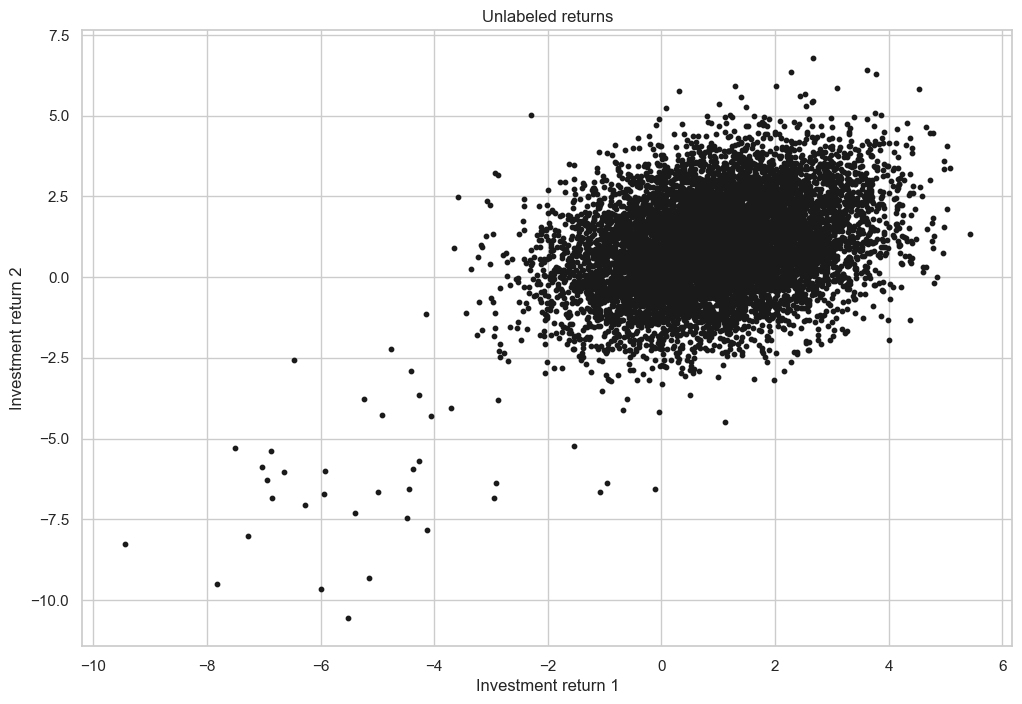

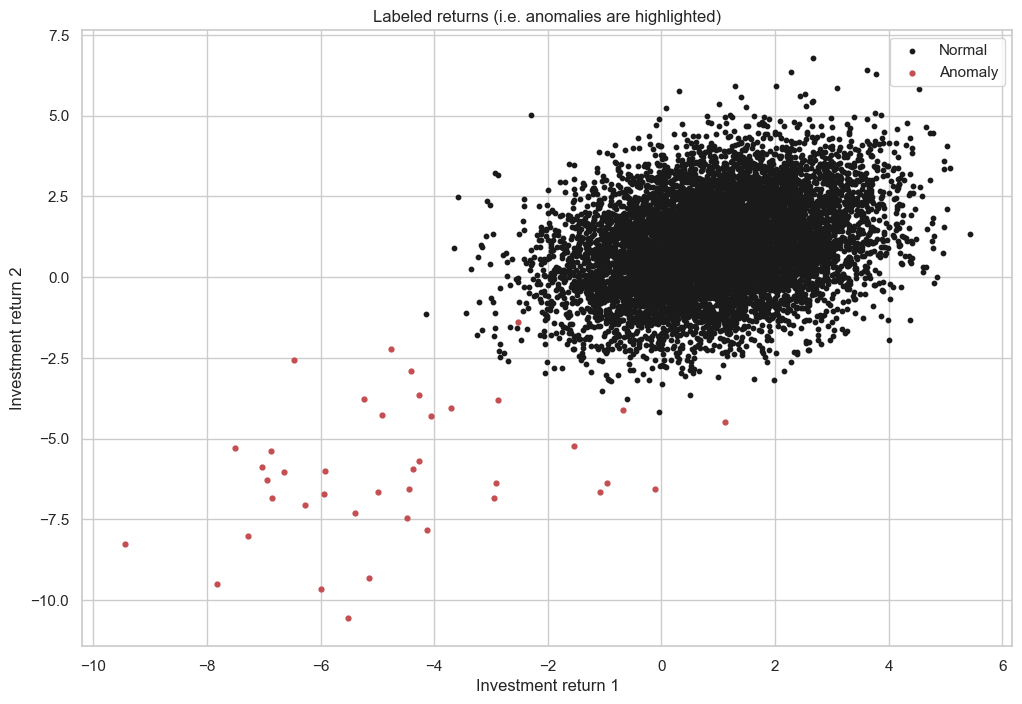

In [2]:
from scipy.stats import multivariate_normal
from sklearn.metrics import precision_score, recall_score, f1_score

# Set the style for our plots
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]


# Set random seed for reproducibility
np.random.seed(42)

# First variable: "ordinary returns = non-anomalous data"
mu1 = np.array([1, 1])  # Mean of the 1st component
sigma1 = np.array([[1.7, 0.5], [0.5, 1.9]])  # Covariance of the 1st component
nobs1 = 10000

# Second variable: "unusual returns = anomalies"
mu2 = np.array([-5, -6])  # Mean of the 2nd component
sigma2 = np.array([[4.5, 0.95], [0.95, 3.5]])  # Covariance of the 2nd component
nobs2 = 40

# Generate random samples from multivariate normal distributions
r1 = np.random.multivariate_normal(mu1, sigma1, nobs1)
r2 = np.random.multivariate_normal(mu2, sigma2, nobs2)

# Combine the two sets into one dataset
X = np.vstack((r1, r2))
y = np.hstack((np.zeros(nobs1), np.ones(nobs2)))

# Plot the data without labels
plt.figure(figsize=(12, 8))
plt.scatter(X[:, 0], X[:, 1], c='k', s=10)
plt.xlabel('Investment return 1')
plt.ylabel('Investment return 2')
plt.title('Unlabeled returns')
plt.show()

# Plot the data with labels (anomalies in red)
plt.figure(figsize=(12, 8))
plt.scatter(X[y==0, 0], X[y==0, 1], c='k', s=10, label='Normal')
plt.scatter(X[y==1, 0], X[y==1, 1], c='r', s=12, label='Anomaly')
plt.xlabel('Investment return 1')
plt.ylabel('Investment return 2')
plt.title('Labeled returns (i.e. anomalies are highlighted)')
plt.legend()
plt.show()



### **Modeling Strategy – God Mode = OFF**

So far, in "God Mode ON", we’ve created the world. Now we pretend we didn’t.

We step into the shoes of someone who:

- Observes a dataset coming from an unknown Data Generation Process (DGP).
- Knows which points are abnormal (at least a decent subset), for example because they have been labelled by an expert.
- Wants to detect which points are **abnormal**, i.e., **anomalies**.

A fairly typical situation.


Our strategy:

1. **Model the normal** – Fit a multivariate Gaussian (MVG) density only on the normal observations.
2. **Score everything** – Use the MVG to assign a likelihood score $p(x)$ to each new observation.
3. **Flag anomalies** – If $p(x)$ is lower than some threshold $\varepsilon$, we flag it as an anomaly.

This leads to a simple decision rule:

$$
\text{Anomaly} \quad \Longleftrightarrow \quad p(x) < \varepsilon
$$

This approach is probabilistic, quite interpretable, and (despite its simplicity) surprisingly effective when anomalies are rare and normality is structured.

---

#### 🧠 What are we really doing?

- We do **not** assume the entire dataset is Gaussian.  
  (In fact, we know it's a Gaussian mixture — but we ignore that on purpose.)

- We only assume that the **normal part** of the data can be well approximated by a multivariate Gaussian.

- We use the fitted MVG as a proxy for **how normality looks**, and measure how much new observations deviate from it.

> 💡 We’re not learning what anomalies *are*.  
> We’re learning what *normal* is — and flagging anything that looks very different.


---

#### Formal Summary

We fit:

- $\mu = \text{mean of normal data}$
- $\Sigma = \text{covariance of normal data}$

Then for any observation $x$:

$$
p(x) = \frac{1}{(2\pi)^{k/2} |\Sigma|^{1/2}} \exp\left(-\frac{1}{2}(x - \mu)^T \Sigma^{-1} (x - \mu)\right)
$$

We classify $x$ as **anomaly** if:

$$
p(x) < \varepsilon
$$

We choose our **hyperparamer** $\varepsilon$ by maximizing the **F1 score** on the validation set (which includes anomalies). Anyway, you can decide to maximize any metric you think is good as Optimization metric (F1 is just a reasonable and comfy choice).

---
<br>

 🧠 **Short Machine Learning epistemology note**

While the core method (fitting a multivariate Gaussian density) is unsupervised (because density estimation is an unsupervised metod), we apply it in a **supervised framework**:
- We use **labeled data** (anomalies) during cross-validation to choose the threshold $\varepsilon$. This means: supervised.
- We evaluate the model using **supervised metrics** like precision, recall, and F1 score.

So overall, this should be considered a **supervised model**. Or, **semi-supervised**. Again, it's just terminology.

📌 **Lesson**: the nature of a model depends not just on how it’s built,  but on how it’s **used** (also, think about Logistic Regression, a regression model typically used as a classifier).

<br>

### **Splitting data: Train / Cross-Validation / Test Set Construction**

We adopt the **fairly classic train/cv/test partition**. But there are some peculiarities though: in anomaly detection, **data is typically split in a way that emphasizes the modeling of normal behavior**.

<br>

#### **Training Set (`X_train`)**

- Contains only **normal data** (i.e., no anomalies).
- Extracted as the first 6,000 observations from the normal sample: `r1[:6000]`.
- Used to estimate the MVG distribution of "normal" behavior.

This is intentional:  
we want the model to learn the statistical structure of normal data **without contamination** from anomalies.

<br>

#### **Cross-Validation Set (`X_cross_val`)**

- Contains a **mixture** of:
  - 2,000 **normal** points: `r1[6000:8000]`.
  - 20 **anomalies** (50% of total anomalies): `r2[:20]`.
- Used to **tune the hyperparameter, the threshold** $\varepsilon$, which controls the anomaly detection cutoff.

<br>

#### **Test Set (`X_test`)**

- Also a **mixture** of:
  - 2,000 **normal** points: `r1[8000:]`.
  - 20 **anomalies** (remaining 50%): `r2[20:]`.
- Used to evaluate the **final performance** of the trained model on **unseen data** (i.e., out-of-sample, or using the hold-out set).

<br>

---

This data split structure is common in Anomaly Detection when:

- Anomalies are **rare** (which is often the case, btw, otherwise they are not considered anomalies...).
- The goal is to carefully model "normal" data.
- There are **not enough anomalies** to learn their distribution directly

Note that this setup differs from standard supervised learning, where all classes are typically distributed proportionally across training, validation, and test sets.

<br>

<br>

---

Note: we don't reshuffle here in this first exercise only because it's an artifical sample of i.i.d. observations, with a known structure.  Otherwise: **reshuffle, always**.

<br>

In [3]:
# Note (yes, again: I want to stress the idea): we don't reshuffle here,
# only because this is an artificial sample of i.i.d. observations
# In real applications, you should ALWAYS RESHUFFLE your data

# Split the normal data (60/20/20 a common choice, with this dataset size)
X_train = r1[:6000]  # 60% of X|y=0
X_cross_val = np.vstack((r1[6000:8000], r2[:20]))  # 20% of X|y=0 and 50% of X|y=1
X_test = np.vstack((r1[8000:], r2[20:]))  # 20% of X|y=0 and 50% of X|y=1

# Create corresponding labels
y_cross_val = np.zeros(len(X_cross_val))
y_cross_val[-20:] = 1
y_test = np.zeros(len(X_test))
y_test[-20:] = 1


Let's visualize what data we have in our train/cv(test) partition.

In [4]:
split_summary = pd.DataFrame({
    'Set': ['Train', 'Cross-Validation', 'Test (Hold-Out)'],
    'Normal points': [len(X_train), 2000, 2000],
    'Anomalies': [0, 20, 20],
    'Total': [len(X_train), len(X_cross_val), len(X_test)]
})

display(split_summary)


Set  Normal points  Anomalies  Total
0             Train           6000          0   6000
1  Cross-Validation           2000         20   2020
2   Test (Hold-Out)           2000         20   2020

### **Model fit: estimate MVG parameters**

We estimate the mean vector $\mu$ and covariance matrix $\Sigma$ of the multivariate normal distribution, using only the training set (i.e., normal data).

Standard Maximum Likelihood estimators:

- $\mu = \text{mean}(X_{\text{train}})$  
- $\Sigma = \text{cov}(X_{\text{train}})$

<br>


In [5]:
# Estimate the parameters of the multivariate Gaussian
mu = np.mean(X_train, axis=0)
sigma = np.cov(X_train, rowvar=False)

#other estimators to try: shrinkage, robust, weighted, wolf?, etc.

### **Threshold Selection via Cross-Validation**

We compute the probability density $p(x)$ for each point in the cross-validation set.  
Then we search for the threshold $\varepsilon$ that maximizes the F1 score.

For each candidate $\varepsilon$:
- Points with $p(x) < \varepsilon$ are classified as anomalies
- We compare predictions to ground truth labels
- We compute precision, recall, and F1 score.

We retain the $\varepsilon$ that yields the best F1.

📌 **Why F1?**

You already know the story... The **choice of evaluation metric depends on the application**, on the business case. In short:
- If false negatives are critical, **recall** might be prioritized
- If false positives are costly, **precision** could be preferred
- F1 is a **balanced compromise**: the harmonic mean of precision and recall

In this example, we use F1 because we aim for a good trade-off without favoring one type of error, and also abecause it's just an example - you instead think carefully about which metric to use and why...

<br>


In [ ]:
# Compute the probability density function for the cross-validation set
mv_normal = multivariate_normal(mean=mu, cov=sigma)
p = mv_normal.pdf(X_cross_val)

# Find the range of epsilon values to search
min_epsilon = np.min(p)
max_epsilon = np.max(p)
step_size = (max_epsilon - min_epsilon) / 1000

# Find the best epsilon using F1 score
best_epsilon = 0
best_f1 = 0

epsilon_values = np.arange(min_epsilon, max_epsilon, step_size)
for epsilon in epsilon_values:
    predictions = (p < epsilon).astype(int)

    # Calculate precision and recall
    tp = np.sum((predictions == 1) & (y_cross_val == 1))
    fp = np.sum((predictions == 1) & (y_cross_val == 0))
    fn = np.sum((predictions == 0) & (y_cross_val == 1))

    # Avoid division by zero
    if tp + fp == 0 or tp + fn == 0:
        continue

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    # Calculate F1 score
    if precision + recall > 0:  # Avoid division by zero
        f1 = 2 * precision * recall / (precision + recall)

        if f1 > best_f1:
            best_f1 = f1
            best_epsilon = epsilon

print(f"Best F1 Score: {best_f1:.4f}")
print(f"Best Epsilon: {best_epsilon:.8f}")

#other metrics to try: precision, recall, f1, auc, etc.
#here false positives are costly, so we should focus on precision and recall


Best F1 Score: 0.9048
Best Epsilon: 0.00009187


/Users/mouadh/Fintech_Projects/Business_Case_4/venv/lib/python3.12/site-packages/scipy/stats/_covariance.py:630: RuntimeWarning: divide by zero encountered in matmul
  return x @ self._LP
/Users/mouadh/Fintech_Projects/Business_Case_4/venv/lib/python3.12/site-packages/scipy/stats/_covariance.py:630: RuntimeWarning: overflow encountered in matmul
  return x @ self._LP
/Users/mouadh/Fintech_Projects/Business_Case_4/venv/lib/python3.12/site-packages/scipy/stats/_covariance.py:630: RuntimeWarning: invalid value encountered in matmul
  return x @ self._LP


### **Final evaluation on test set**

We apply the best threshold $\varepsilon$ to the test set (out-of-sample approach), which contains both normal points and previously unseen anomalies.

We compute some usual metrics of the model’s performance:
- **Precision**.
- **Recall**.
- **F1 Score**.

<br>

---

### Visual Inspection

The scatter plot highlights:

- **Normal points** in black.
- **True anomalies** in red.
- **False positives** (normal misclassified as anomaly) in yellow.
- **False negatives** (anomalies missed by the model) in magenta.

This helps understand both the **quantitative** and **qualitative** behavior of the model.


Test Precision: 0.8636
Test Recall: 0.9500
Test F1 Score: 0.9048


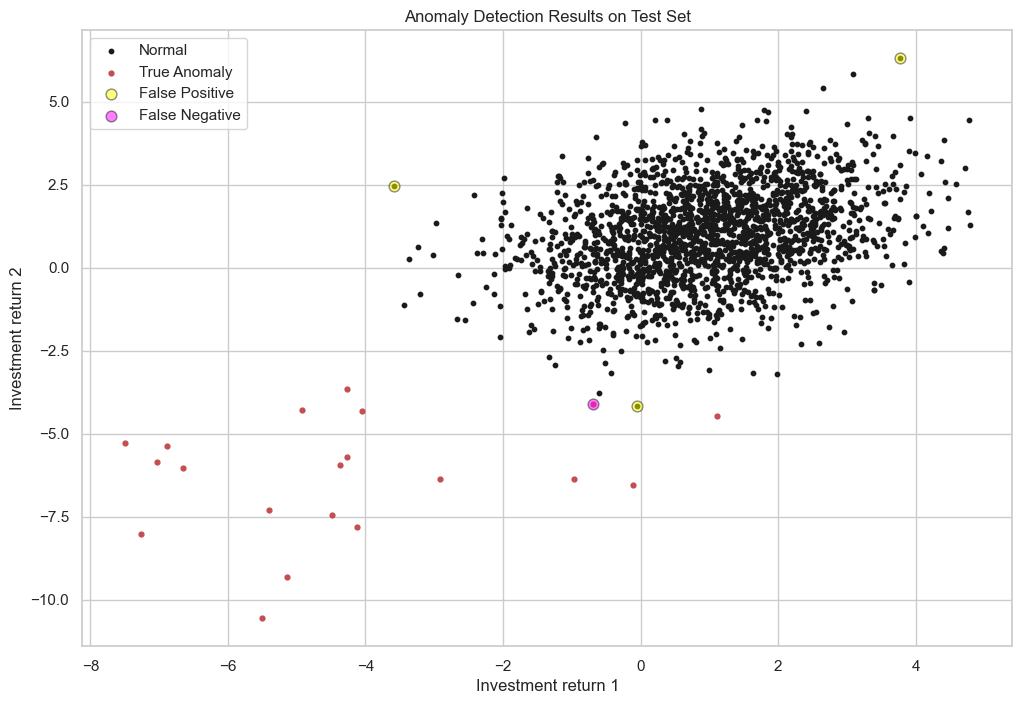

In [7]:
# Compute the probability density function for the test set
p_test = mv_normal.pdf(X_test)

# Make predictions using the best epsilon
predictions = (p_test < best_epsilon).astype(int)

# Calculate metrics
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")

# Visualize the results
plt.figure(figsize=(12, 8))
plt.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], c='k', s=10, label='Normal')
plt.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], c='r', s=12, label='True Anomaly')
plt.scatter(X_test[(predictions==1) & (y_test==0), 0],
            X_test[(predictions==1) & (y_test==0), 1],
            c='yellow', s=60, alpha=0.5, marker='o', edgecolors='k', label='False Positive')
plt.scatter(X_test[(predictions==0) & (y_test==1), 0],
            X_test[(predictions==0) & (y_test==1), 1],
            c='magenta', s=60, alpha=0.5, marker='o', edgecolors='k', label='False Negative')
plt.xlabel('Investment return 1')
plt.ylabel('Investment return 2')
plt.title('Anomaly Detection Results on Test Set')
plt.legend()
plt.show()


## Real-World dataset

We now switch to a **real-world dataset** from Bloomberg, consisting of weekly observations of:

- Market and macroeconomic indicators (e.g., indices, rates).
- A response variable `Y` indicating **anomalous periods** (e.g., market stress events).


---

### Visual Preview: MSCI USA and Anomaly Periods

We inspect our features and plot a key equity index, the MSCI USA index (`MXUS`), over time, highlighting the periods where `Y = 1` as **risk-on/risk-off windows**.

This allows a quick visual check of:

- The distribution of anomalous events in time.
- Their potential correspondence with market drops or volatility clusters.

<br>


In [8]:
# Define the path to the dataset
#file_path = '/content/drive/MyDrive/PoliMI/Dataset4_EWS.xlsx'
file_path = 'Dataset4_EWS.xlsx'

Data columns: ['Data', 'BDIY', 'CRY', 'Cl1', 'DXY', 'ECSURPUS', 'EMUSTRUU', 'EONIA', 'GBP', 'GT10', 'GTDEM10Y', 'GTDEM2Y', 'GTDEM30Y', 'GTGBP20Y', 'GTGBP2Y', 'GTGBP30Y', 'GTITL10YR', 'GTITL2YR', 'GTITL30YR', 'GTJPY10YR', 'GTJPY2YR', 'GTJPY30YR', 'JPY', 'LF94TRUU', 'LF98TRUU', 'LG30TRUU', 'LMBITR', 'LP01TREU', 'LUACTRUU', 'LUMSTRUU', 'MXBR', 'MXCN', 'MXEU', 'MXIN', 'MXJP', 'MXRU', 'MXUS', 'US0001M', 'USGG2YR', 'USGG30YR', 'USGG3M', 'VIX', 'XAUBGNL', 'Y']
Data shape: (1111, 42)
Total number of records: 1111
Time period: from 01/11/2000 to 04/20/2021
Frequency: W-TUE
Number of variables: 42
Number of anomalies: 237 (21.33%)

Metadata and statistics:


Ticker                     Description         Mean      Std.Dev  \
0        BDIY                Baltic Dry Index  2259.860486  2017.811888   
1         CRY              TR/CC CRB ER Index   245.247649    68.278081   
2         Cl1         Generic 1st 'CL' Future    60.708101    25.900813   
3         DXY               DOLLAR INDEX SPOT    90.934982    11.379095   
4    ECSURPUS  Bloomberg ECO US Surprise Inde     0.036153     0.349453   
5    EMUSTRUU                EM USD Aggregate   704.379495   309.951768   
6       EONIA  EMMI EURO OverNight Index Aver     1.363676     1.721894   
7         GBP              British Pound Spot     1.569618     0.212340   
8        GT10                 US TREASURY N/B     3.266748     1.332464   
9    GTDEM10Y        BUNDESREPUB. DEUTSCHLAND     2.448365     1.851558   
10    GTDEM2Y         BUNDESSCHATZANWEISUNGEN     1.431110     1.876061   
11   GTDEM30Y        BUNDESREPUB. DEUTSCHLAND     3.039282     1.779526   
12   GTGBP20Y              UK TSY 1 1/4% 2041     3.445731     1.366188   
13    GTGBP2Y              UK TSY 0 1/8% 2023     2.299739     2.128539   
14   GTGBP30Y              UK TSY 0 5/8% 2050     3.450121     1.263211   
15  GTITL10YR        BUONI POLIENNALI DEL TES     3.680791     1.465289   
16   GTITL2YR        BUONI POLIENNALI DEL TES     2.104911     1.700726   
17  GTITL30YR        BUONI POLIENNALI DEL TES     4.426725     1.274729   
18  GTJPY10YR           JAPAN (10 YEAR ISSUE)     0.904126     0.643985   
19   GTJPY2YR            JAPAN (2 YEAR ISSUE)     0.150180     0.297519   
20  GTJPY30YR           JAPAN (30 YEAR ISSUE)     1.724494     0.720026   
21        JPY               Japanese Yen Spot   106.605734    12.840754   
22   LF94TRUU         Global Inflation-Linked   259.052663    75.934443   
23   LF98TRUU         US Corporate High Yield  1231.258119   553.121000   
24   LG30TRUU               Global High Yield   804.720625   370.251996   
25     LMBITR            Municipal Bond Index   883.615439   241.507125   
26   LP01TREU         Pan-European High Yield   232.109928   109.917622   
27   LUACTRUU                       Corporate  2077.306949   690.731794   
28   LUMSTRUU                        U.S. MBS  1637.293510   417.229338   
29       MXBR                     MSCI BRAZIL  1903.216436   986.468254   
30       MXCN                      MSCI CHINA    53.933159    24.738356   
31       MXEU                     MSCI EUROPE   107.877138    20.795973   
32       MXIN                      MSCI INDIA   693.156616   405.527014   
33       MXJP                      MSCI JAPAN   784.846292   200.076443   
34       MXRU                     MSCI RUSSIA   648.681377   299.096020   
35       MXUS                        MSCI USA  1606.997102   698.481956   
36    US0001M           ICE LIBOR USD 1 Month     1.836073     1.909032   
37    USGG2YR            US Generic Govt 2 Yr     1.990358     1.710307   
38   USGG30YR           US Generic Govt 30 Yr     3.908324     1.178592   
39     USGG3M           US Generic Govt 3 Mth     1.575151     1.802895   
40        VIX           Cboe Volatility Index    19.992169     8.642157   
41    XAUBGNL                         XAUBGNL   987.463744   494.623740   

          Min          Max  Missing values Missing (%)  
0   291.00000  11793.00000               0       0.00%  
1   106.29290    467.57000               0       0.00%  
2    10.01000    140.97000               0       0.00%  
3    71.32900    119.82000               0       0.00%  
4    -0.97400      0.99100               0       0.00%  
5   230.52670   1286.35300               0       0.00%  
6    -0.49800      5.73000               0       0.00%  
7     1.17230      2.08520               0       0.00%  
8     0.50800      6.74800               0       0.00%  
9    -0.79400      5.64400               0       0.00%  
10   -0.96800      5.26400               0       0.00%  
11   -0.47100      6.25400               0       0.00%  
12    0.48920      5.24180              

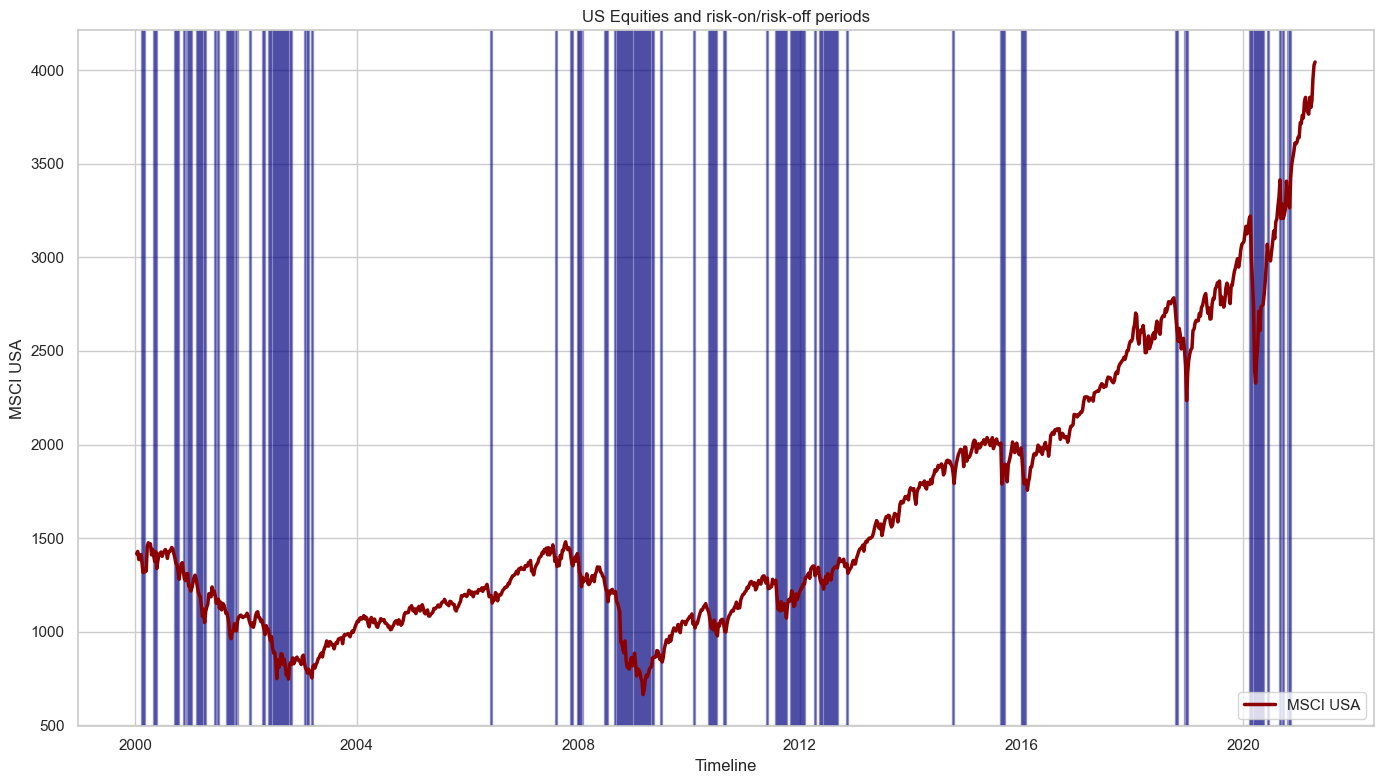

In [10]:
# Set visualization style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

# Load the data from the Excel file
# First sheet contains market data with dates and anomaly labels, second sheet contains metadata
data_df = pd.read_excel(file_path, sheet_name='Markets')
metadata_df = pd.read_excel(file_path, sheet_name='Metadata')

# Check the structure of the loaded data
print("Data columns:", data_df.columns.tolist())

# Extract date and anomaly label columns
date_col = 'Date' if 'Date' in data_df.columns else data_df.columns[0]
y_col = 'Y' if 'Y' in data_df.columns else None

# Convert dates to datetime format
data_df[date_col] = pd.to_datetime(data_df[date_col], dayfirst=True)  # Date format is dd/mm/yy

# Set date as index
data_df = data_df.set_index(date_col)

# Extract features (all columns except Y if it exists)
if y_col:
    X_df = data_df.drop(y_col, axis=1)
    y = data_df[y_col].values
else:
    X_df = data_df
    y = None

# Display basic information about the dataset
print(f"Data shape: {X_df.shape}")
print(f"Total number of records: {len(X_df)}")
print(f"Time period: from {X_df.index.min().strftime('%m/%d/%Y')} to {X_df.index.max().strftime('%m/%d/%Y')}")
print(f"Frequency: {pd.infer_freq(X_df.index) or 'Weekly'}")
print(f"Number of variables: {X_df.shape[1]}")
if y_col:
    print(f"Number of anomalies: {np.sum(y == 1)} ({np.mean(y == 1)*100:.2f}%)")

# Create a more comprehensive metadata table with additional statistics
enhanced_metadata = []

# Determine the correct column names for ticker and description
ticker_col = 'ticker' if 'ticker' in metadata_df.columns else metadata_df.columns[0]
desc_col = 'description' if 'description' in metadata_df.columns else metadata_df.columns[1] if len(metadata_df.columns) > 1 else ticker_col

for ticker in X_df.columns:
    # Get metadata for this ticker if available
    meta_row = metadata_df[metadata_df[ticker_col] == ticker] if ticker in metadata_df[ticker_col].values else pd.DataFrame()

    # Get description or use ticker if not found
    description = meta_row[desc_col].values[0] if not meta_row.empty and desc_col in meta_row.columns else ticker

    # Calculate statistics for this series
    series = X_df[ticker]

    enhanced_metadata.append({
        'Ticker': ticker,
        'Description': description,
        'Mean': series.mean(),
        'Std.Dev': series.std(),
        'Min': series.min(),
        'Max': series.max(),
        'Missing values': series.isna().sum(),
        'Missing (%)': f"{series.isna().mean()*100:.2f}%"
    })

# Create enhanced metadata dataframe
enhanced_meta_df = pd.DataFrame(enhanced_metadata)

# Display the enhanced metadata
print("\nMetadata and statistics:")
display(enhanced_meta_df)

# Create a plot with anomalies as vertical bars and MXUS as a line
if y_col and 'MXUS' in X_df.columns:
    fig, ax = plt.subplots(figsize=(14, 8))

    # Plot MXUS line
    ax.plot(X_df.index, X_df['MXUS'], color='darkred', linewidth=2.5, label='MSCI USA')

    # Get the y-axis limits after plotting MXUS
    y_min, y_max = ax.get_ylim()

    # For each anomaly point (Y=1), create a vertical span across the entire plot
    for i, (date, is_anomaly) in enumerate(zip(X_df.index, y)):
        if is_anomaly == 1:
            ax.axvspan(date, date + pd.Timedelta(days=7), alpha=0.3, color='navy', label='Risk-on/Risk-off' if i == 0 else "")

    # Set labels and title
    ax.set_xlabel('Timeline')
    ax.set_ylabel('MSCI USA')
    ax.set_title('US Equities and risk-on/risk-off periods')

    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='best')

    plt.tight_layout()
    plt.show()
else:
    print("Either 'Y' column or 'MXUS' column is missing in the dataset.")


# EDA: Stationarity analysis and feature preparation

### Stationarity matters

Many/most models — especially those based on statistical distributions — assume that the data is **stationary**, i.e., its statistical properties (mean, variance) do not change over time.

This is particularly important for Anomaly Detection models like the one we use, which rely on estimating a **stable distribution**.

---

#### Why is stationarity important?

- Without stationarity, **mean and variance shift** over time.
- This makes density estimates unreliable.
- What looks like an anomaly could simply be a change in regime or trend.

> 📌 A stable model requires stable inputs.

<br>

---

### How do we check for stationarity?

We explore:

- Visual inspection of the series.
- Basic transformations (e.g., log-returns).
- You can perform formal statistical tests, e.g., [Augmented Dickey-Fuller](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html).

The goal is to identify variables that exhibit **mean-reverting behavior** or that can be transformed into stationary form.

<br>

Let's start analyzing a bond yield (for example, 10-year Italian BTP) to understand:
* stationarity through time graphs of levels and first differences.
* shape of the distribution with histograms and QQ-plot.

<br>

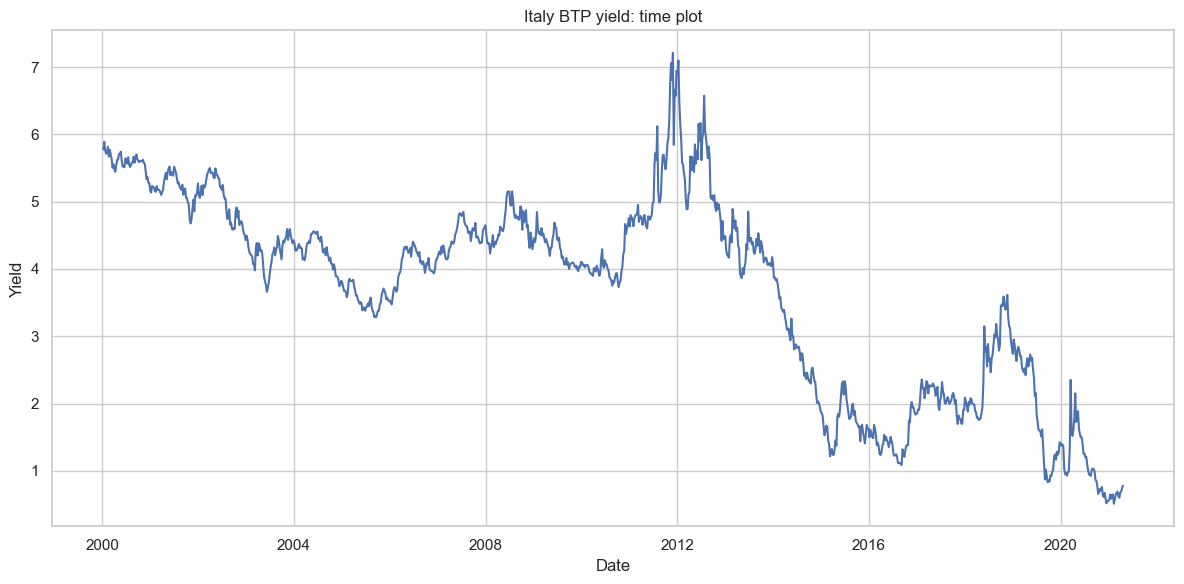

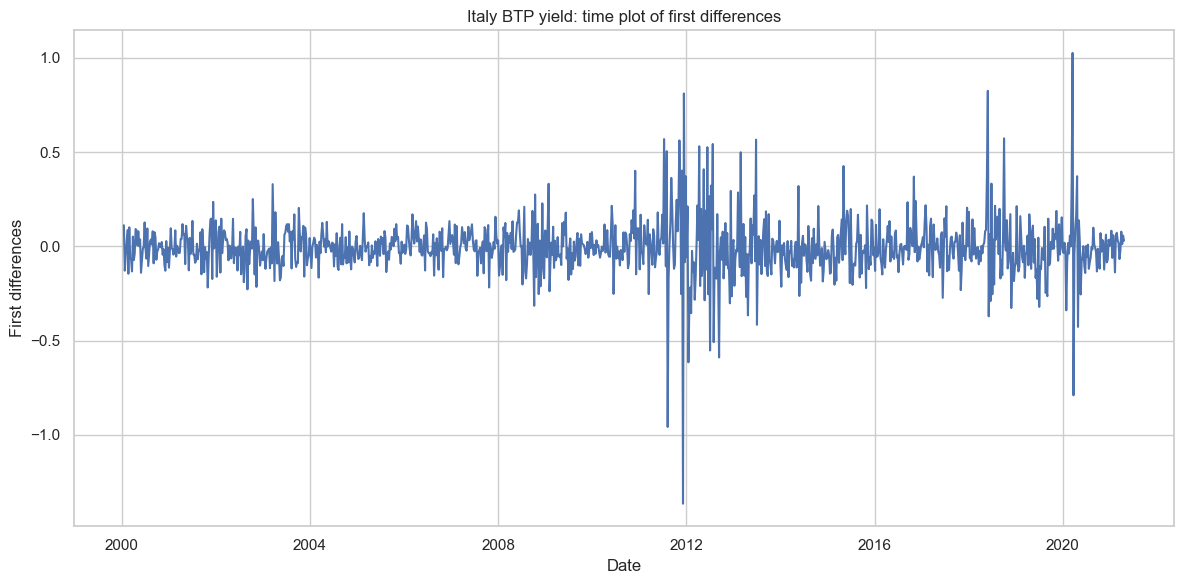

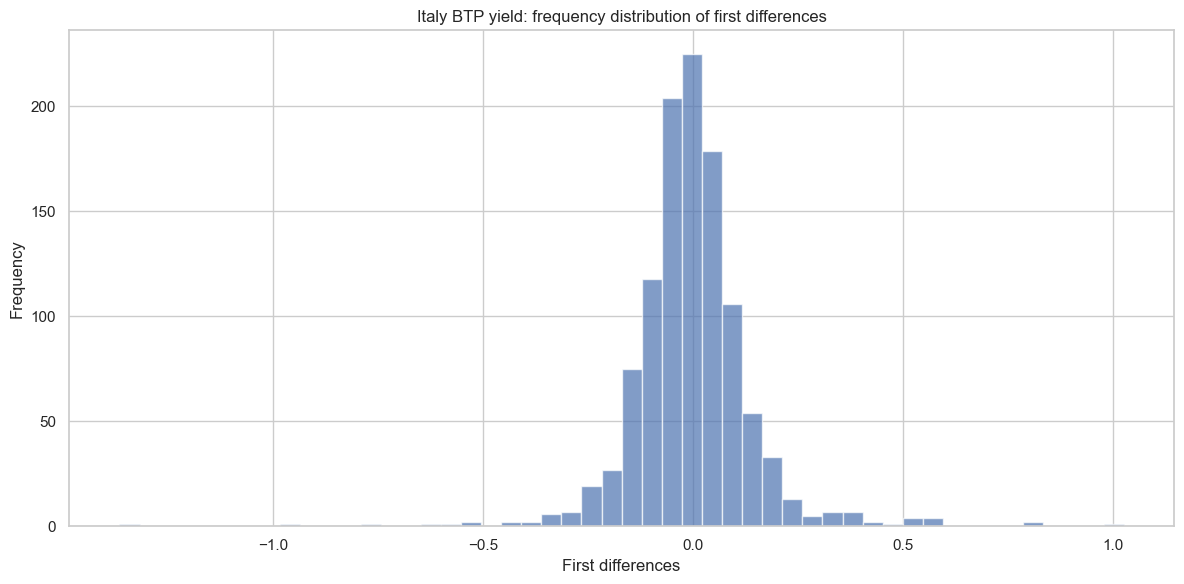

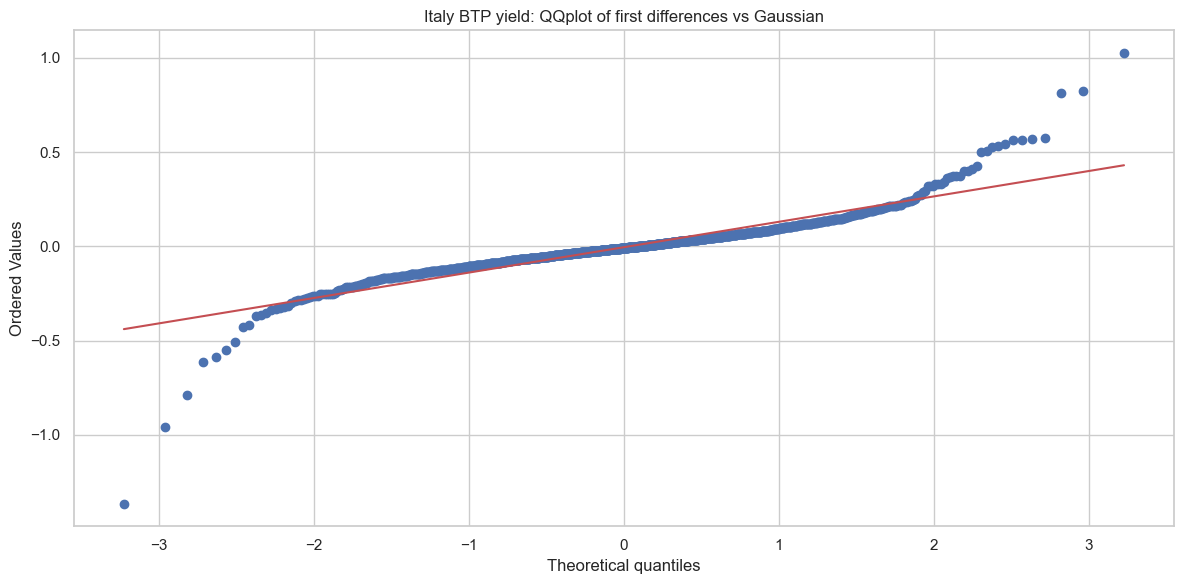

In [12]:
from scipy import stats
import statsmodels.api as sm

# Set visualization style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]

# Analyze a bond yield (interest rate) - Italian BTP 10Yrs
if 'GTITL10YR' in X_df.columns:
    # Time plot of levels
    plt.figure(figsize=(12, 6))
    plt.plot(X_df.index, X_df['GTITL10YR'])
    plt.title('Italy BTP yield: time plot')
    plt.xlabel('Date')
    plt.ylabel('Yield')
    plt.tight_layout()
    plt.show()

    # Time plot of first differences
    plt.figure(figsize=(12, 6))
    plt.plot(X_df.index[1:], np.diff(X_df['GTITL10YR']))
    plt.title('Italy BTP yield: time plot of first differences')
    plt.xlabel('Date')
    plt.ylabel('First differences')
    plt.tight_layout()
    plt.show()

    # Histogram of first differences
    plt.figure(figsize=(12, 6))
    plt.hist(np.diff(X_df['GTITL10YR']), bins=50, alpha=0.7)
    plt.title('Italy BTP yield: frequency distribution of first differences')
    plt.xlabel('First differences')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

    # QQ plot of first differences vs Gaussian
    plt.figure(figsize=(12, 6))
    stats.probplot(np.diff(X_df['GTITL10YR']), dist="norm", plot=plt)
    plt.title('Italy BTP yield: QQplot of first differences vs Gaussian')
    plt.tight_layout()
    plt.show()


<br>

Now let's do the same with a (relevant) equity index.

<br>

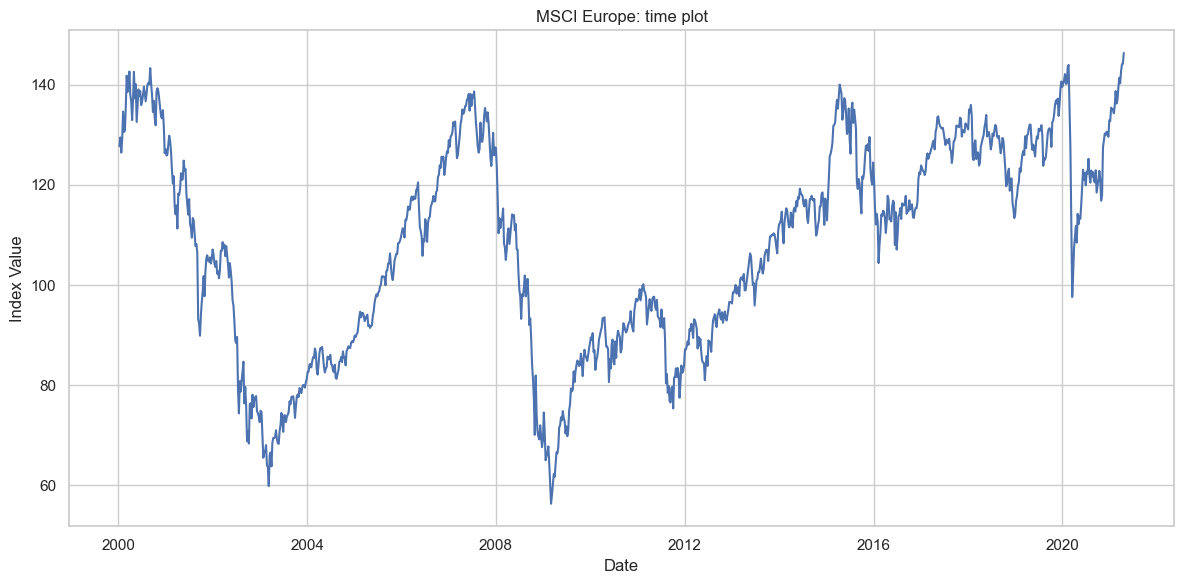

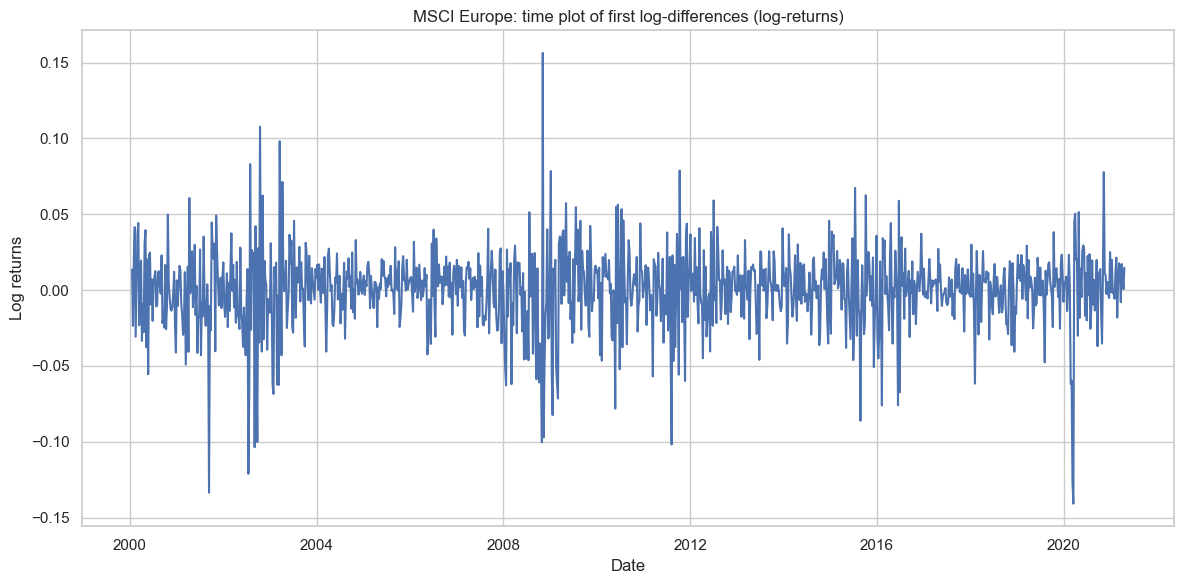

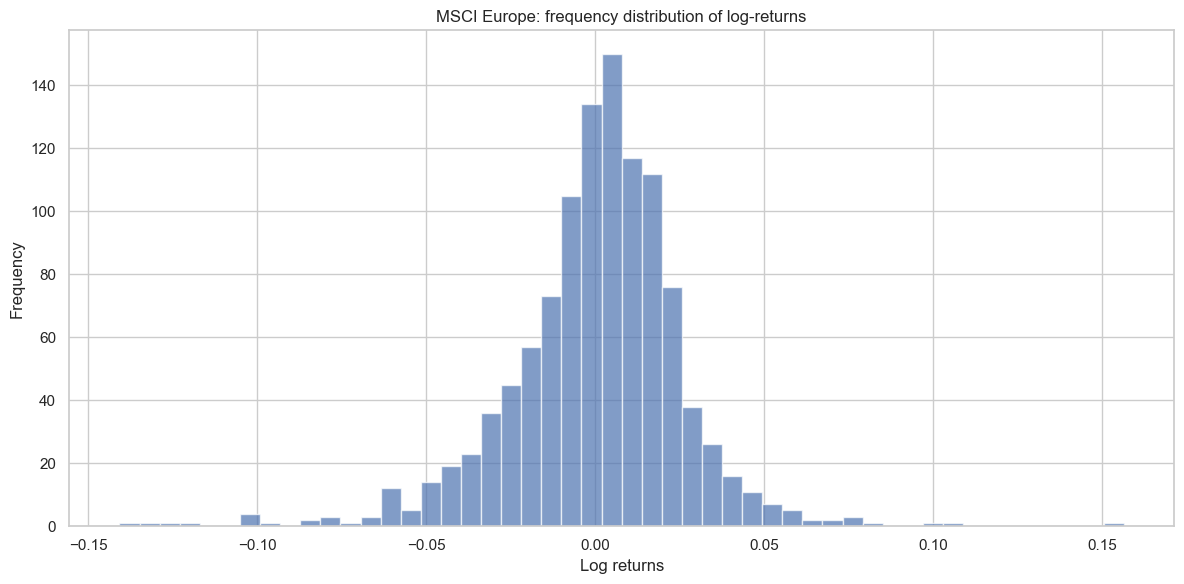

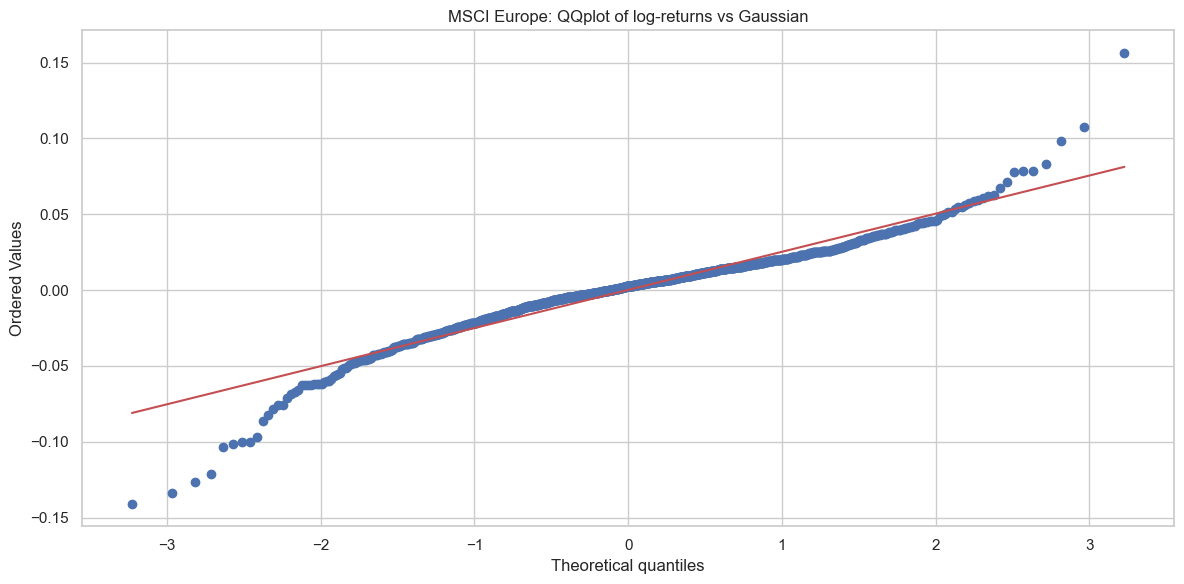

In [13]:
# Analyze an equity asset - MSCI Europe
if 'MXEU' in X_df.columns:
    # Time plot of levels
    plt.figure(figsize=(12, 6))
    plt.plot(X_df.index, X_df['MXEU'])
    plt.title('MSCI Europe: time plot')
    plt.xlabel('Date')
    plt.ylabel('Index Value')
    plt.tight_layout()
    plt.show()

    # Time plot of log returns
    plt.figure(figsize=(12, 6))
    log_returns = np.diff(np.log(X_df['MXEU']))
    plt.plot(X_df.index[1:], log_returns)
    plt.title('MSCI Europe: time plot of first log-differences (log-returns)')
    plt.xlabel('Date')
    plt.ylabel('Log returns')
    plt.tight_layout()
    plt.show()

    # Histogram of log returns
    plt.figure(figsize=(12, 6))
    plt.hist(log_returns, bins=50, alpha=0.7)
    plt.title('MSCI Europe: frequency distribution of log-returns')
    plt.xlabel('Log returns')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

    # QQ plot of log returns vs Gaussian
    plt.figure(figsize=(12, 6))
    stats.probplot(log_returns, dist="norm", plot=plt)
    plt.title('MSCI Europe: QQplot of log-returns vs Gaussian')
    plt.tight_layout()
    plt.show()


<br>

Now an economic surprise index: [the Bloomberg Economic US Surprise Index](https://www.babypips.com/forexpedia/bloomberg-us-economic-surprise-index#:~:text=The%20Bloomberg%20U.S.%20Economic%20Surprise,downside%20relative%20to%20market%20expectations).

<br>

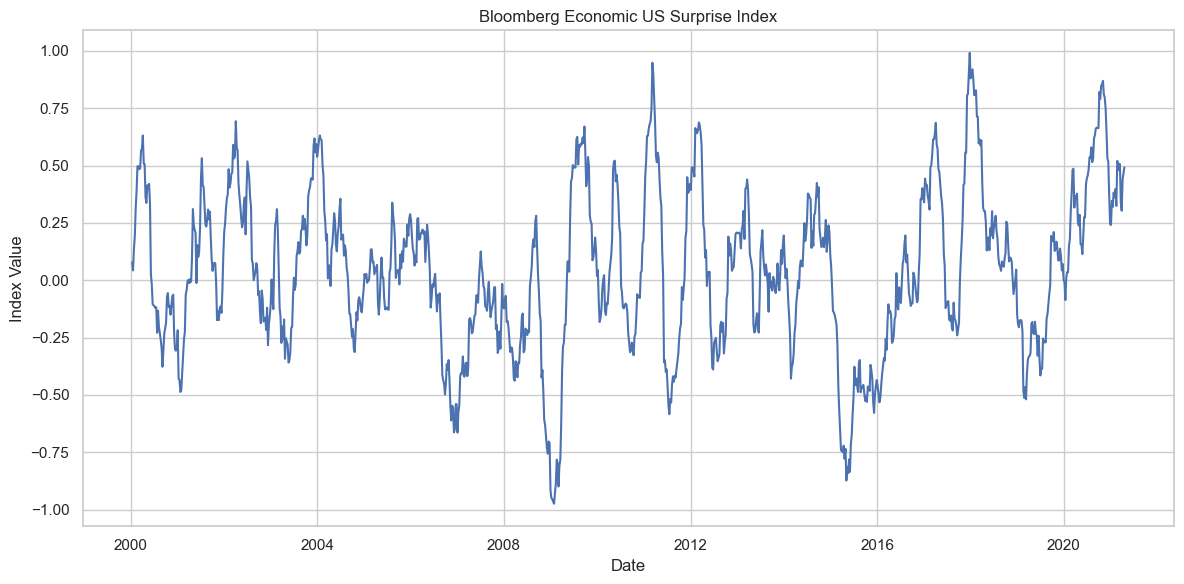

In [14]:
# Analyze the Bloomberg Economic US Surprise Index
if 'ECSURPUS' in X_df.columns:
    plt.figure(figsize=(12, 6))
    plt.plot(X_df.index, X_df['ECSURPUS'])
    plt.title('Bloomberg Economic US Surprise Index')
    plt.xlabel('Date')
    plt.ylabel('Index Value')
    plt.tight_layout()
    plt.show()


<br>

Let's check if we have negative interest rates. If a variable can take negative values, you cannot use log-differences, only first-differences - I recommend that you always use first differences, for interest rates and bond yields (not for bond indices).

<br>

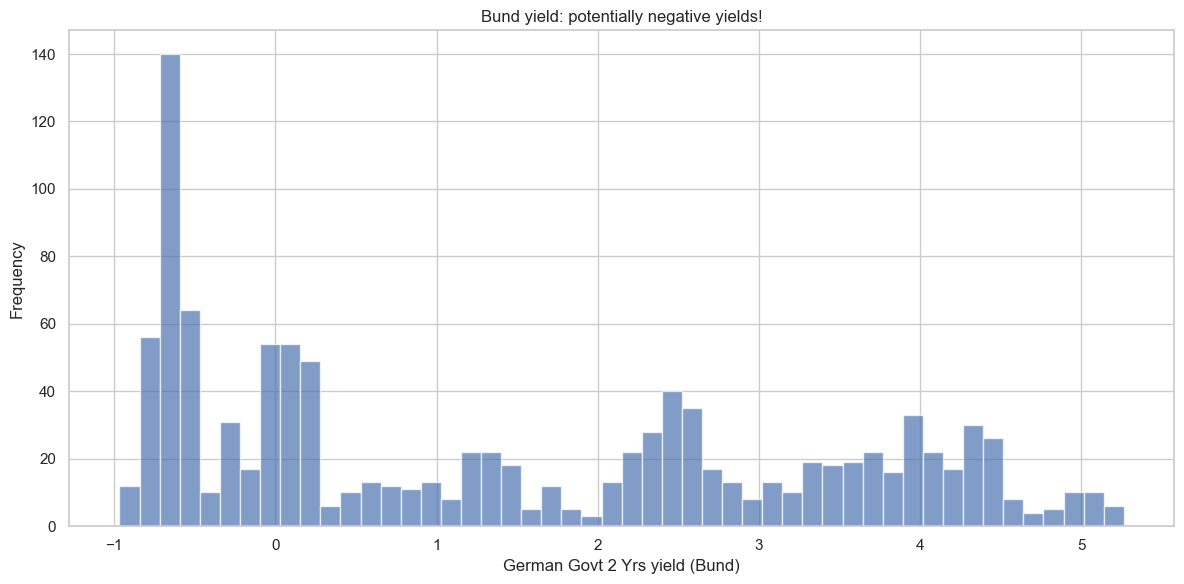

In [15]:
# Check for negative values in interest rates
if 'GTDEM2Y' in X_df.columns:
    plt.figure(figsize=(12, 6))
    plt.hist(X_df['GTDEM2Y'], bins=50, alpha=0.7)
    plt.title('Bund yield: potentially negative yields!')
    plt.xlabel('German Govt 2 Yrs yield (Bund)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()


## Coping with stationarity

### Stationarity Transformation

Unless we are using **cointegration** techniques, we need the data to be **stationary**. For an introduction to the idea of cointegration see  [Cointegration](https://en.wikipedia.org/wiki/Cointegration).

This means that the **joint distribution** of the features must be stable over time.

The rationale is intuitive:

- We want to use historical data to infer patterns related to systemic risk.
- If the underlying structure shifts over time, any model based on past behavior becomes unreliable.

> A non-stationary model is not just inaccurate — it’s structurally **wrong**.

---

#### How we transform the data

- **Indices and currencies**: log-differenced (they are strictly positive).
- **Interest rates and yields**: first differences (they can be negative or close to zero).
- **Economic surprise index**: left as is (already roughly stationary). Note: Do not take this as a rule for macroeconomic variables; many are non-stationary, sometimes they need to be differentiated TWICE (sic).


Only the **features** are transformed — not the labels, i.e., our vector Y.

> For **more background** (that many ML tutorials skip entirely):  
> - [Forecasting: Principles and Practice – Stationarity](https://otexts.com/fpp3/stationarity.html)  
> - [Cointegration and ECMs – Sørensen](https://www.uh.edu/~bsorense/coint.pdf)

<br>

In [16]:
# Make data stationary based on variable type
# So w define lists of variables by type
indices_currencies = [col for col in X_df.columns if col in [
    'XAUBGNL', 'BDIY', 'CRY', 'Cl1', 'DXY', 'EMUSTRUU', 'GBP', 'JPY', 'LF94TRUU',
    'LF98TRUU', 'LG30TRUU', 'LMBITR', 'LP01TREU', 'LUACTRUU', 'LUMSTRUU',
    'MXBR', 'MXCN', 'MXEU', 'MXIN', 'MXJP', 'MXRU', 'MXUS', 'VIX'
]]

interest_rates = [col for col in X_df.columns if col in [
    'EONIA', 'GTDEM10Y', 'GTDEM2Y', 'GTDEM30Y', 'GTGBP20Y', 'GTGBP2Y', 'GTGBP30Y',
    'GTITL10YR', 'GTITL2YR', 'GTITL30YR', 'GTJPY10YR', 'GTJPY2YR', 'GTJPY30YR',
    'US0001M', 'USGG3M', 'USGG2YR', 'GT10', 'USGG30YR'
]]

# Create a new dataframe for stationary data
stationary_df = pd.DataFrame(index=X_df.index[1:])

# Apply log-differences to indices and currencies (always positive)
for col in indices_currencies:
    if col in X_df.columns:
        stationary_df[col] = np.diff(np.log(X_df[col]))

# Apply first differences to interest rates (can be negative or very close to 0)
for col in interest_rates:
    if col in X_df.columns:
        stationary_df[col] = np.diff(X_df[col])

# Keep Bloomberg Economic US Surprise Index as is (already stationary)
if 'ECSURPUS' in X_df.columns:
    stationary_df['ECSURPUS'] = X_df['ECSURPUS'].values[1:]

# Adjust the response variable to match the new data length
if y is not None:
    y_stationary = y[1:]
else:
    y_stationary = None


## Multivariate perspective

Matrix of scatter plots comparing our Xs by using the our Y as grouping variable (I plot just a selection of features, and they are already too many).

I guess you can spot visual differences in the behavior of variables during normal and abnormal periods.

<br>

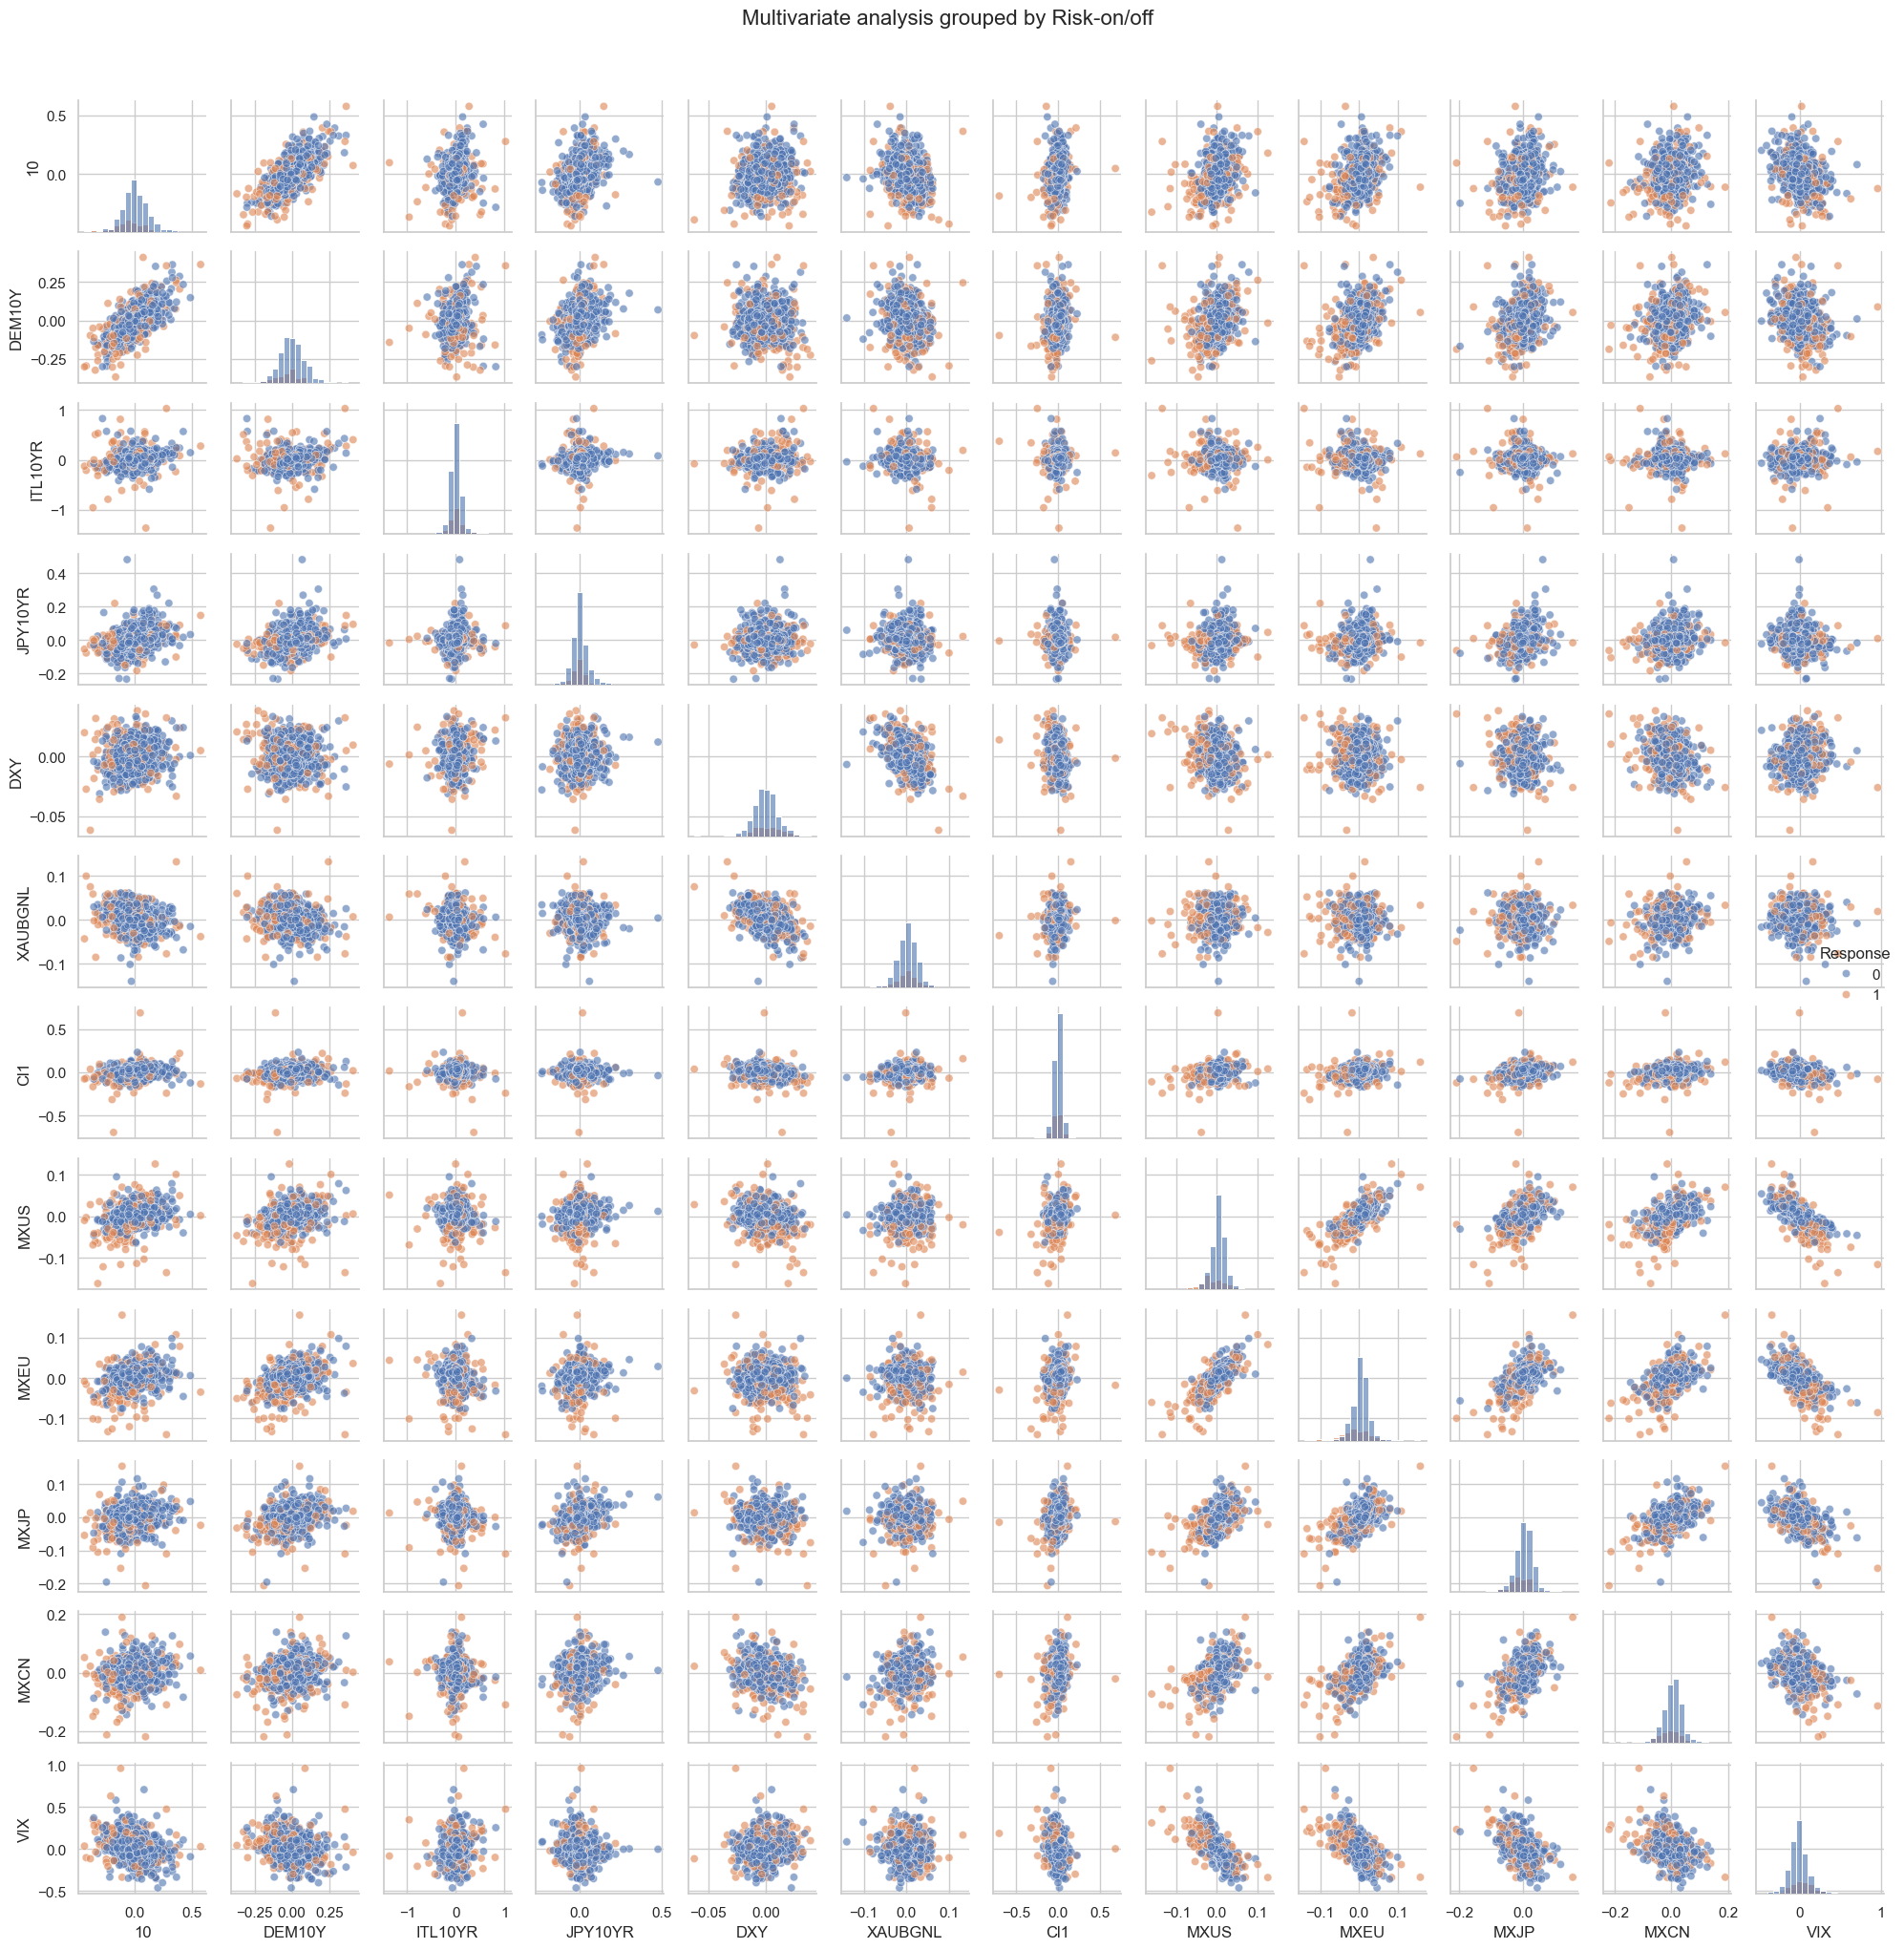

In [17]:
# Create a matrix of scatter plots with Y as grouping variable
# Select a subset of variables for visualization (otherwise the chart is too big)
plot_vars = []
plot_names = []

# Add interest rates (first differences)
for col in ['GT10', 'GTDEM10Y', 'GTITL10YR', 'GTJPY10YR']:
    if col in stationary_df.columns:
        plot_vars.append(stationary_df[col])
        plot_names.append(col.replace('GT', ''))

# Add indices and currencies (log differences)
for col in ['DXY', 'XAUBGNL', 'Cl1', 'MXUS', 'MXEU', 'MXJP', 'MXCN', 'VIX']:
    if col in stationary_df.columns:
        plot_vars.append(stationary_df[col])
        plot_names.append(col)

# Convert to numpy array for plotting
plot_data = np.column_stack(plot_vars)

# Create a custom pairplot with grouping by Y
if y_stationary is not None and len(plot_vars) > 0:
    # Create a DataFrame with the selected variables and the response
    plot_df = pd.DataFrame(plot_data, columns=plot_names)
    plot_df['Response'] = y_stationary

    # Create a pairplot with different colors for Y=0 and Y=1
    g = sns.pairplot(plot_df, hue='Response', diag_kind='hist',
                     plot_kws={'alpha': 0.6}, diag_kws={'alpha': 0.6, 'bins': 20})

    # Customize the plot
    g.fig.suptitle('Multivariate analysis grouped by Risk-on/off', y=1.02, fontsize=16)
    g.fig.set_size_inches(20, 20)
    plt.tight_layout()
    plt.show()


## MVG-based anomaly detector with supervised threshold tuning

We now apply our **Multivariate Gaussian anomaly detector**  to this real-world dataset of financial assets.

We follow the same steps as with synthetic data:

1. Fit the distribution of normal data.
2. Score all points using the estimated PDF.
3. Tune the threshold $\varepsilon$ on a labeled validation set.
4. Evaluate on a held-out test set.

<br>

Let's start with **reshuffling and splitting** our data.

<br>

In [18]:
# Step 1: shuffle and split data into training, validation, and test sets
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

# Set visualization style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]

# Convert to numpy arrays for easier manipulation
X = stationary_df.values
y = y_stationary

# Step 1: Creating training/cross-validation/test set with reshuffling

# Reshuffle the data (this will break down autocorrelation)
X_shuffled, y_shuffled = shuffle(X, y, random_state=42)

# Separate normal and anomalous examples
X_normal = X_shuffled[y_shuffled == 0]
X_anomaly = X_shuffled[y_shuffled == 1]

# Calculate sizes for each set
n_normal = X_normal.shape[0]
n_anomaly = X_anomaly.shape[0]

# Training set: 80% of normal examples
train_size = int(0.8 * n_normal)
X_train = X_normal[:train_size]

# Cross-validation set: 10% of normal examples and 50% of anomalies
cv_normal_size = int(0.1 * n_normal)
cv_anomaly_size = int(0.5 * n_anomaly)
X_cv_normal = X_normal[train_size:train_size + cv_normal_size]
X_cv_anomaly = X_anomaly[:cv_anomaly_size]
X_cross_val = np.vstack((X_cv_normal, X_cv_anomaly))
y_cross_val = np.hstack((np.zeros(cv_normal_size), np.ones(cv_anomaly_size)))

# Test set: 10% of normal examples and 50% of anomalies
X_test_normal = X_normal[train_size + cv_normal_size:]
X_test_anomaly = X_anomaly[cv_anomaly_size:]
X_test = np.vstack((X_test_normal, X_test_anomaly))
y_test = np.hstack((np.zeros(len(X_test_normal)), np.ones(len(X_test_anomaly))))

# We'll standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_cross_val = scaler.transform(X_cross_val)
X_test = scaler.transform(X_test)

print(f"Training set size: {X_train.shape[0]} (all normal)")
print(f"Cross-validation set size: {X_cross_val.shape[0]} ({cv_normal_size} normal, {cv_anomaly_size} anomalies)")
print(f"Test set size: {X_test.shape[0]} ({len(X_test_normal)} normal, {len(X_test_anomaly)} anomalies)")


Training set size: 698 (all normal)
Cross-validation set size: 205 (87 normal, 118 anomalies)
Test set size: 207 (88 normal, 119 anomalies)


### Model fit and threshold tuning

We fit the model on the training set, compute the PDF on the validation set, and search for the best threshold $\varepsilon$ by maximizing the F1 score.


In [20]:
# Step 2: Training the model (estimating parameters of multivariate Gaussian)

# Calculate mean vector
mu = np.mean(X_train, axis=0)

# Calculate covariance matrix
sigma = np.cov(X_train, rowvar=False)

print(f"Mean vector shape: {mu.shape}")
print(f"Covariance matrix shape: {sigma.shape}")


Mean vector shape: (42,)
Covariance matrix shape: (42, 42)


/Users/mouadh/Fintech_Projects/Business_Case_4/venv/lib/python3.12/site-packages/numpy/linalg/_linalg.py:2383: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/mouadh/Fintech_Projects/Business_Case_4/venv/lib/python3.12/site-packages/numpy/linalg/_linalg.py:2383: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/mouadh/Fintech_Projects/Business_Case_4/venv/lib/python3.12/site-packages/numpy/linalg/_linalg.py:2383: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Best F1 score on CV set: 0.7616
Best Epsilon: 8.09971191e-14
Corresponding Precision: 0.6250
Corresponding Recall: 0.9746


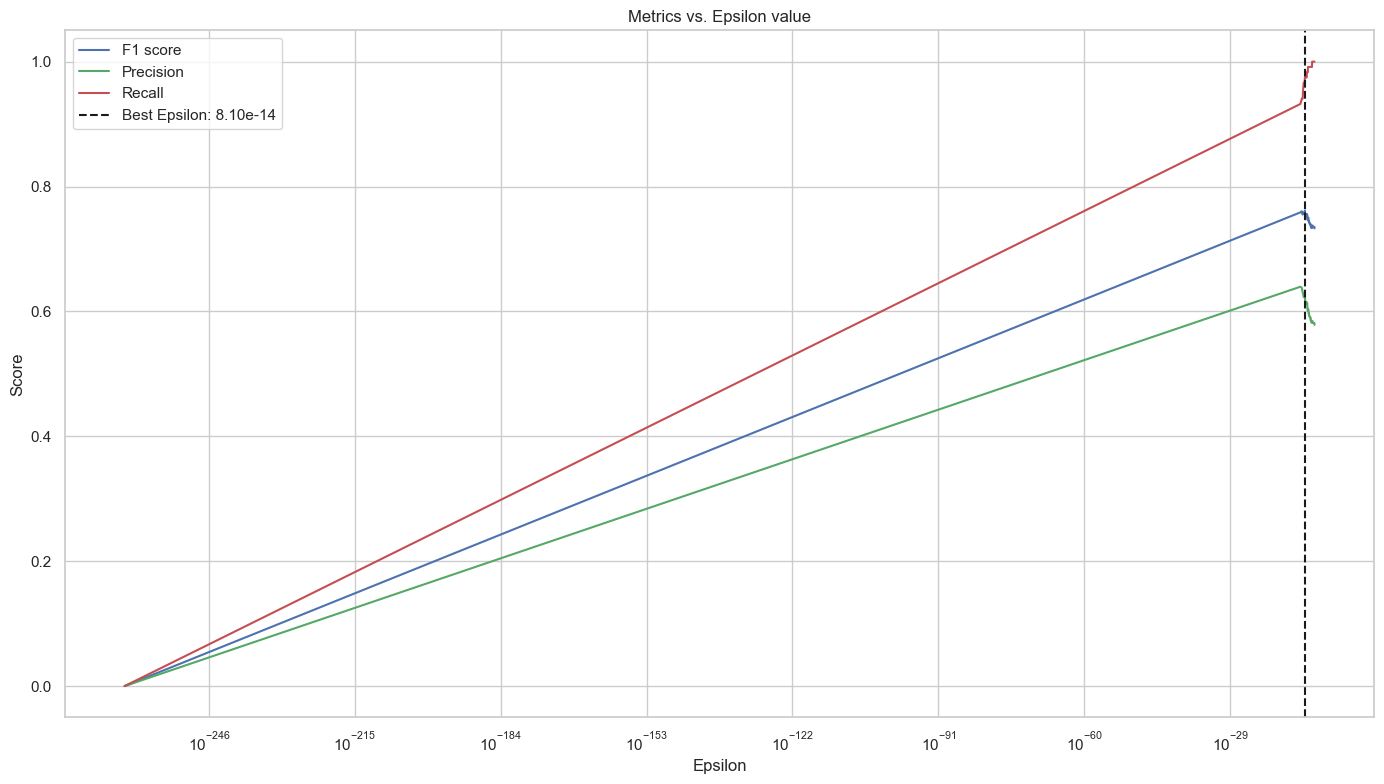

In [21]:
# Step 3: Fine tuning the hyperparameter, the threshold ϵ

# Function to calculate multivariate Gaussian PDF
def multivariate_gaussian_pdf(X, mu, sigma):
    """Calculate the multivariate Gaussian probability density function"""
    n = mu.shape[0]

    # Handle potential numerical issues with the covariance matrix
    # Add a small regularization term to ensure positive definiteness
    sigma_reg = sigma + np.eye(n) * 1e-8

    # Calculate determinant and inverse
    try:
        det = np.linalg.det(sigma_reg)
        inv = np.linalg.inv(sigma_reg)
    except np.linalg.LinAlgError:
        # If still having issues, use pseudo-inverse
        print("Warning: Using pseudo-inverse for covariance matrix")
        det = max(np.linalg.det(sigma_reg), 1e-10)
        inv = np.linalg.pinv(sigma_reg)

    # Calculate PDF for each example
    p = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        x_mu = X[i] - mu
        p[i] = (1.0 / (np.power(2 * np.pi, n/2) * np.sqrt(det))) * \
               np.exp(-0.5 * x_mu.dot(inv).dot(x_mu))

    return p

# Compute the probability density function for the cross-validation set
p_cv = multivariate_gaussian_pdf(X_cross_val, mu, sigma)

# Find the range of epsilon values to search
min_epsilon = np.min(p_cv)
max_epsilon = np.max(p_cv)
step_size = (max_epsilon - min_epsilon) / 1000

# Find the best epsilon using F1 score
best_epsilon = 0
best_f1 = 0
best_precision = 0
best_recall = 0

epsilon_values = np.arange(min_epsilon, max_epsilon, step_size)
f1_scores = []
precisions = []
recalls = []

for epsilon in epsilon_values:
    predictions = (p_cv < epsilon).astype(int)

    # Calculate metrics
    precision = precision_score(y_cross_val, predictions, zero_division=0)
    recall = recall_score(y_cross_val, predictions, zero_division=0)

    # Calculate F1 score
    if precision + recall > 0:  # Avoid division by zero
        f1 = 2 * precision * recall / (precision + recall)
    else:
        f1 = 0

    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    if f1 > best_f1:
        best_f1 = f1
        best_epsilon = epsilon
        best_precision = precision
        best_recall = recall

print(f"Best F1 score on CV set: {best_f1:.4f}")
print(f"Best Epsilon: {best_epsilon:.8e}")
print(f"Corresponding Precision: {best_precision:.4f}")
print(f"Corresponding Recall: {best_recall:.4f}")

# Plot F1 score, precision, and recall vs epsilon
plt.figure(figsize=(14, 8))
plt.plot(epsilon_values, f1_scores, 'b-', label='F1 score')
plt.plot(epsilon_values, precisions, 'g-', label='Precision')
plt.plot(epsilon_values, recalls, 'r-', label='Recall')
plt.axvline(x=best_epsilon, color='k', linestyle='--', label=f'Best Epsilon: {best_epsilon:.2e}')
plt.xlabel('Epsilon')
plt.ylabel('Score')
plt.title('Metrics vs. Epsilon value')
plt.legend()
plt.xscale('log')  # Log scale for better visualization
plt.grid(True)
plt.tight_layout()
plt.show()


### Model evaluation on test set

We apply the selected threshold to the test set (unseen data) and evaluate the results using precision, recall, F1 score, and confusion matrix (*HINT*: You can pick different metrics, e.g. AUC).

We visualize the classification outcome using two selected features (that you can change...) to better understand false positives and false negatives in feature space.



Test set performance:
Precision: 0.6031
Recall: 0.9832
F1 Score: 0.7476

Confusion Matrix:
True Negatives: 11
False Positives: 77
False Negatives: 2
True Positives: 117


/Users/mouadh/Fintech_Projects/Business_Case_4/venv/lib/python3.12/site-packages/numpy/linalg/_linalg.py:2383: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/mouadh/Fintech_Projects/Business_Case_4/venv/lib/python3.12/site-packages/numpy/linalg/_linalg.py:2383: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/mouadh/Fintech_Projects/Business_Case_4/venv/lib/python3.12/site-packages/numpy/linalg/_linalg.py:2383: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


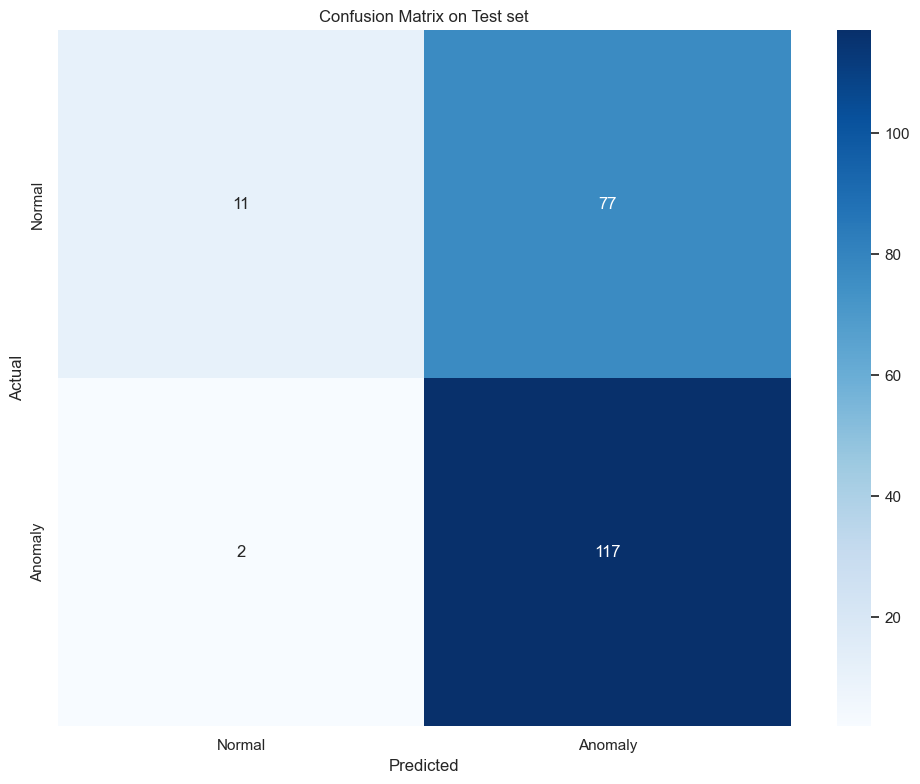

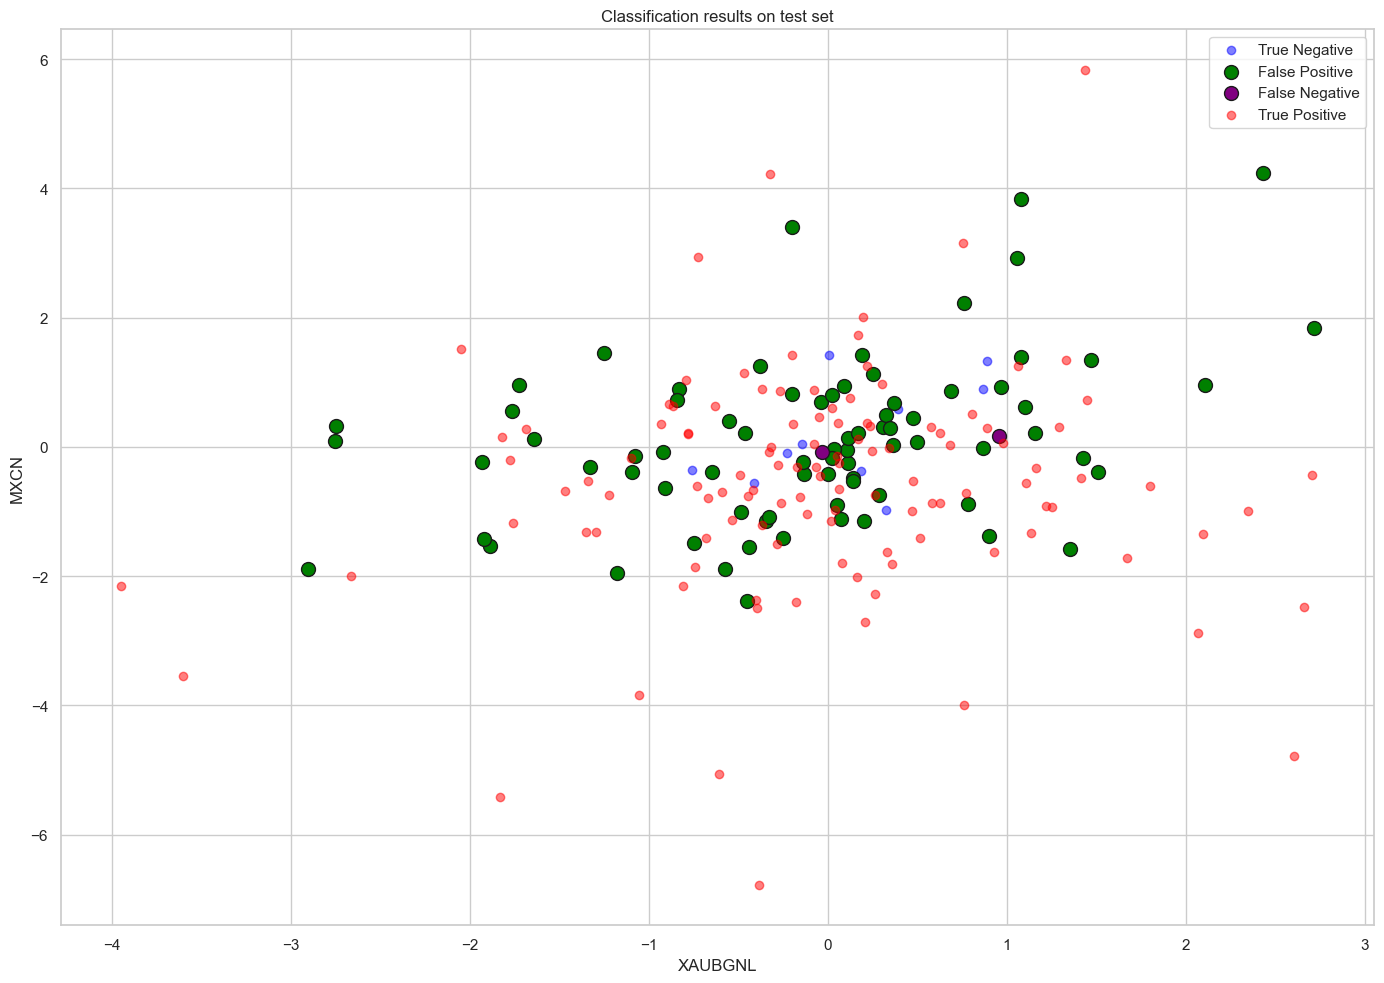

In [22]:
from sklearn.metrics import confusion_matrix

# Step 4: Testing the model

# Compute the probability density function for the test set
p_test = multivariate_gaussian_pdf(X_test, mu, sigma)

# Make predictions using the best epsilon
predictions = (p_test < best_epsilon).astype(int)

# Calculate metrics
MVG_precision = precision_score(y_test, predictions, zero_division=0)
MVG_recall = recall_score(y_test, predictions, zero_division=0)
MVG_f1 = f1_score(y_test, predictions, zero_division=0)

print("\nTest set performance:")
print(f"Precision: {MVG_precision:.4f}")
print(f"Recall: {MVG_recall:.4f}")
print(f"F1 Score: {MVG_f1:.4f}")

# Create confusion matrix
cm = confusion_matrix(y_test, predictions)
tn, fp, fn, tp = cm.ravel()

print("\nConfusion Matrix:")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test set')
plt.tight_layout()
plt.show()


# Visualize examples of correctly and incorrectly classified points
# Select two features for visualization
if X_test.shape[1] >= 2:
    # Choose two features (columns) for visualization
    feature1_idx = 22  # First feature
    feature2_idx = 15  # Second feature

    # Get feature names
    feature1_name = stationary_df.columns[feature1_idx]
    feature2_name = stationary_df.columns[feature2_idx]

    plt.figure(figsize=(14, 10))

    # True negatives (correctly classified normal points)
    plt.scatter(X_test[(y_test == 0) & (predictions == 0), feature1_idx],
                X_test[(y_test == 0) & (predictions == 0), feature2_idx],
                c='blue', marker='o', alpha=0.5, label='True Negative')

    # False positives (normal points classified as anomalies)
    plt.scatter(X_test[(y_test == 0) & (predictions == 1), feature1_idx],
                X_test[(y_test == 0) & (predictions == 1), feature2_idx],
                c='green', marker='o', s=100, edgecolors='k', label='False Positive')

    # False negatives (anomalies classified as normal)
    plt.scatter(X_test[(y_test == 1) & (predictions == 0), feature1_idx],
                X_test[(y_test == 1) & (predictions == 0), feature2_idx],
                c='purple', marker='o', s=100, edgecolors='k', label='False Negative')

    # True positives (correctly classified anomalies)
    plt.scatter(X_test[(y_test == 1) & (predictions == 1), feature1_idx],
                X_test[(y_test == 1) & (predictions == 1), feature2_idx],
                c='red', marker='o', alpha=0.5, label='True Positive')

    plt.xlabel(feature1_name)
    plt.ylabel(feature2_name)
    plt.title('Classification results on test set')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### Global visualization via PCA

We apply **Principal Component Analysis (PCA)** to project the high-dimensional feature space  onto the first two principal components.

This allows a compact visualization of the test set, highlighting where the model correctly or incorrectly classified points.

Each point is categorized as:

- **True Positive**: anomaly detected correctly.
- **False Positive**: normal point flagged as anomaly.
- **False Negative**: anomaly missed by the model.
- **True Negative**: normal point correctly ignored.

> 📌 This view helps assess whether **misclassifications** tend to concentrate  
> in specific regions of the feature space or appear randomly scattered.

---

> 🔎 Interestingly enough, anomalies do **not** cluster at the periphery of the PCA space, contrary to what can be seen with a simple 2-variable market model.

> Instead, they are spread across the projection — indicating that the “anomalousness” is not necessarily aligned with the top components of variance.

This is because there are many variables and both the mapping and the behavior of the markets are complex.

This also highlights a limitation of **density-based models with linear projections**: anomalies may hide in dense regions or align with patterns that require more **complex or nonlinear representations** to detect effectively.

<br>

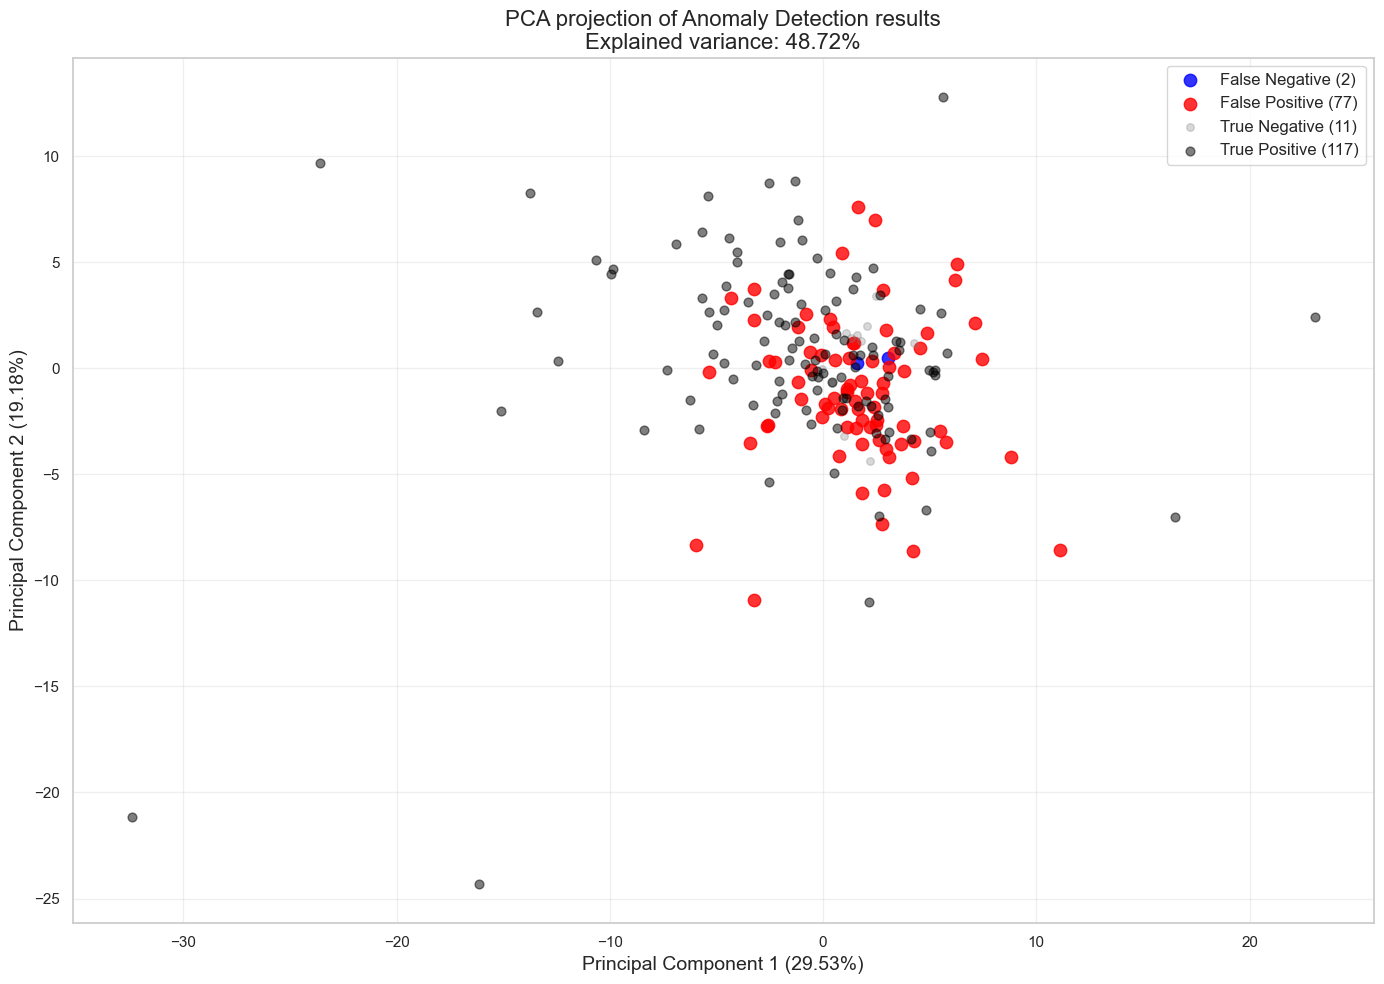

Variance explained by first two principal components: 48.72%


In [23]:
# PCA visualization of anomalies
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

# Create a DataFrame for easier plotting
pca_df = pd.DataFrame(X_test_pca, columns=['PC1', 'PC2'])
pca_df['Actual'] = y_test
pca_df['Predicted'] = predictions

# Create classification categories
pca_df['Category'] = 'Unknown'
pca_df.loc[(y_test == 0) & (predictions == 0), 'Category'] = 'True Negative'
pca_df.loc[(y_test == 0) & (predictions == 1), 'Category'] = 'False Positive'
pca_df.loc[(y_test == 1) & (predictions == 0), 'Category'] = 'False Negative'
pca_df.loc[(y_test == 1) & (predictions == 1), 'Category'] = 'True Positive'

# Calculate explained variance (just to know...)
explained_variance = pca.explained_variance_ratio_
total_variance = sum(explained_variance)

# Plot the PCA projection
plt.figure(figsize=(14, 10))

# Define colors and markers
colors = {'True Negative': 'gray', 'True Positive': 'black',
          'False Positive': 'red', 'False Negative': 'blue'}

# Use same marker for all to simplify
markers = {'True Negative': 'o', 'True Positive': 'o',
           'False Positive': 'o', 'False Negative': 'o'}

# Make misclassified points very visible
alphas = {'True Negative': 0.3, 'True Positive': 0.5,
          'False Positive': 0.8, 'False Negative': 0.8}

sizes = {'True Negative': 30, 'True Positive': 40,
         'False Positive': 80, 'False Negative': 80}

# Plot each category
for category, group in pca_df.groupby('Category'):
    plt.scatter(group['PC1'], group['PC2'],
                color=colors[category],
                marker=markers[category],
                alpha=alphas[category],
                s=sizes[category],
                label=f"{category} ({len(group)})")

# Title and labels
plt.title(f'PCA projection of Anomaly Detection results\nExplained variance: {total_variance:.2%}', fontsize=16)
plt.xlabel(f'Principal Component 1 ({explained_variance[0]:.2%})', fontsize=14)
plt.ylabel(f'Principal Component 2 ({explained_variance[1]:.2%})', fontsize=14)

# Grid and legend
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

# Print variance explained
print(f"Variance explained by first two principal components: {total_variance:.2%}")


### Nonlinear projection with UMAP

To go beyond linear projections like PCA, we apply **[UMAP](https://umap-learn.readthedocs.io/en/latest/)** — a nonlinear dimensionality reduction technique that captures **manifold structure** in the data.

Unlike PCA, UMAP can preserve local and global relationships even when the geometry is twisted or curved, which might be the case. Like PCA we use the first two UMAP dimensions (equivalents of PC1 and PC2).


> 🔎 Again, in this plot, anomalies do **not** concentrate on the periphery. Instead, they are interspersed across the UMAP space — confirming that the distinction between normal and abnormal is not simply a matter of “being far away,” but of **subtle deviations in structure**. Furthermore, the "compactness" in data representation that comes from the use of dimensionality reduction techniques does not always fit well with the idea of ​​Anomaly Detection (which deals with rare cases).

<br>

This motivates the use of more **expressive models** in future modeling iterations.

<br>


/Users/mouadh/Fintech_Projects/Business_Case_4/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/mouadh/Fintech_Projects/Business_Case_4/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mouadh/Fintech_Projects/Business_Case_4/venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


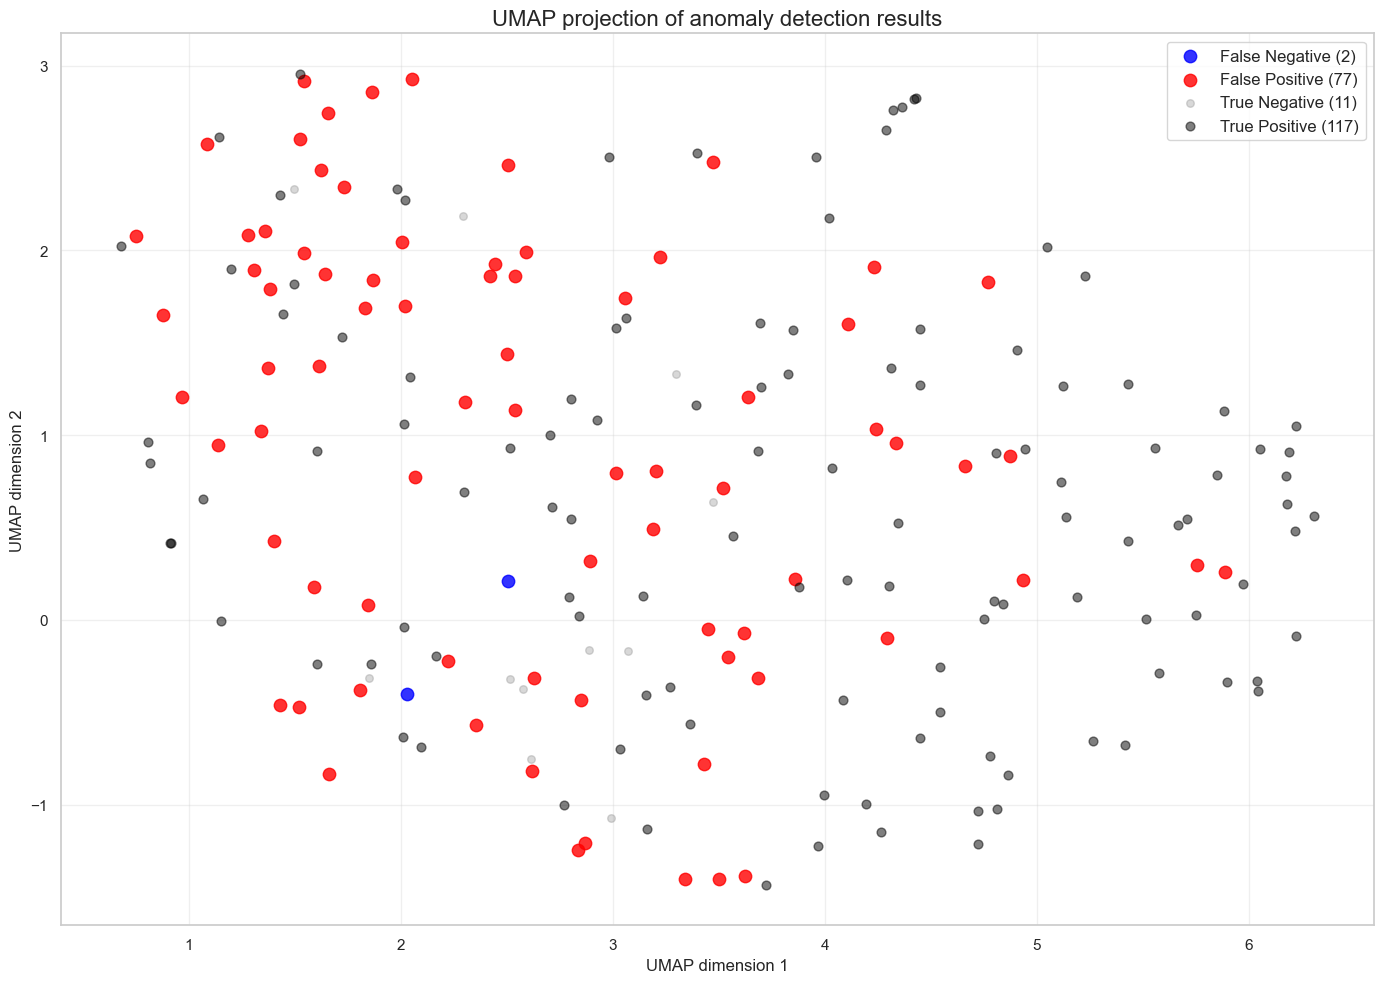

In [26]:
import umap.umap_ as umap

# Fit UMAP on the test set
reducer = umap.UMAP(random_state=42)
X_test_umap = reducer.fit_transform(X_test)

# Add UMAP projection to dataframe
umap_df = pd.DataFrame(X_test_umap, columns=['UMAP1', 'UMAP2'])
umap_df['Category'] = pca_df['Category']  # Same classification labels

# Color and size configuration, same as before
colors = {'True Negative': 'gray', 'True Positive': 'black',
          'False Positive': 'red', 'False Negative': 'blue'}

sizes = {'True Negative': 30, 'True Positive': 40,
         'False Positive': 80, 'False Negative': 80}

alphas = {'True Negative': 0.3, 'True Positive': 0.5,
          'False Positive': 0.8, 'False Negative': 0.8}

# Plot
plt.figure(figsize=(14, 10))
for category, group in umap_df.groupby('Category'):
    plt.scatter(group['UMAP1'], group['UMAP2'],
                c=colors[category],
                s=sizes[category],
                alpha=alphas[category],
                label=f"{category} ({len(group)})")

plt.title('UMAP projection of anomaly detection results', fontsize=16)
plt.xlabel('UMAP dimension 1')
plt.ylabel('UMAP dimension 2')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


<br>

### HINTs
#### 🛠️ Understand model's behavior

As always, it's wise to start from simple models and understand them.

In order to do that:
- Try to understand the situation using **other dimensionality reduction techniques**, e.g. [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html), UMAP (with 3 dimensions), [PACMAP](https://pypi.org/project/pacmap/), [Spectral Embedding](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.spectral_embedding.html). Try using **3D charts**.
- **Do this for synthetic data as well**, trying to generate other data, too (with more "separated"/less "separated" anomalies, adding dimensions - i.e. variables, going from 2 to 3 to 4, and so on... observing how the results change), and **compare the results with real data from Bloomberg** to understand the scope and limitations of the model. Do that also using other models - see below.
- Try **better estimators** for the mean and the covariance, say, [Ledoit-Wolf](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.LedoitWolf.html#sklearn.covariance.LedoitWolf) for the covariance.
- Try **different version of this elliptic model** - see [Elliptic Envelope].(https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope)
- **"Give the model more financial context"**. For example, you can see that the "anomaly" label has often been attributed to extremely negative markets and that the multivariate probability density also signals abnormally good markets as anomalous. Thus, you can try take into account this "asymmetry". For example, segment the dataset into assets whose behavior is homogeneous (eg the group of interest rates, the group of equity indices, the "safest" assets, etc.), use the Cumulative Distribution Function (the CDF, instead of the PDF), so we you check when Prob(x1< p, x2 < p,...), and obtain separate sub-scores to be combined in an aggregate score.  Use a discriminating variable, which separates abnormally positive situations from abnormally negative ones, for example an aggregate equity index (in bad situations equities tend to go down, overall), or a volatility index. So if the discriminating variable, say an aggregate equity index, it is above a given threshold K, we cannot say it's a risk-off (anomalous) situation. Note that if you introduce this new threshold, you have another hyperparameter to tune in crossvalidation...


These are just examples: use your financial know-how and data science tool-kit.

<br>


## Comparing Anomaly Detection Models

We now compare several anomaly detection methods — from simpler models to deep learning.

All models are tested on the **same financial dataset**, and evaluated using consistent metrics: **Precision, Recall, F1 Score, Confusion Matrix, ROC Curve**, and **PCA projections** (you might use UMAP as well).

The categories of models are:

- **MVG Baseline**: our probabilistic model trained on normal data only - it's our baseline model, the benchmark.
- **Supervised models**: Random Forest, SVM.
- **Unsupervised models**: Isolation Forest, Local Outlier Factor, One-Class SVM, Gaussian Mixture.
- **Deep learning**: Autoencoder trained on normal data, scored via reconstruction error.

The goal is not just to compare performance, but to reflect on **methodological trade-offs** between complexity and interpretability, data requirements, and flexibility. We want to understand pros and cons.


In [27]:
# Step 0: Functions and utilities for comparison of supervised and unsupervised Anomaly Detection methods

from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.svm import OneClassSVM, SVC
from sklearn.neighbors import LocalOutlierFactor

# Set visualization style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]

# We already have X_train, X_cross_val, y_cross_val, X_test, y_test from previous code cells
# We'll standardize the data for better performance with many algorithms
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_cv_scaled = scaler.transform(X_cross_val)
X_test_scaled = scaler.transform(X_test)

# Function to evaluate and visualize model performance
def evaluate_model(y_true, y_pred, y_score, model_name):
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"\n{model_name} Performance:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Anomaly'],
                yticklabels=['Normal', 'Anomaly'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()
    plt.show()

    # ROC Curve
    if y_score is not None:  # Some models don't provide probability scores
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()

    return precision, recall, f1

# Function to visualize results in PCA space
def visualize_pca(X, y_true, y_pred, model_name):
    # Apply PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Create a DataFrame for plotting
    pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    pca_df['Actual'] = y_true
    pca_df['Predicted'] = y_pred

    # Create classification categories
    pca_df['Category'] = 'Unknown'
    pca_df.loc[(y_true == 0) & (y_pred == 0), 'Category'] = 'True Negative'
    pca_df.loc[(y_true == 0) & (y_pred == 1), 'Category'] = 'False Positive'
    pca_df.loc[(y_true == 1) & (y_pred == 0), 'Category'] = 'False Negative'
    pca_df.loc[(y_true == 1) & (y_pred == 1), 'Category'] = 'True Positive'

    # Calculate explained variance
    explained_variance = pca.explained_variance_ratio_
    total_variance = sum(explained_variance)

    # Plot
    plt.figure(figsize=(12, 8))

    # Define colors and sizes
    colors = {'True Negative': 'gray', 'True Positive': 'black',
              'False Positive': 'red', 'False Negative': 'blue'}
    alphas = {'True Negative': 0.3, 'True Positive': 0.5,
              'False Positive': 0.8, 'False Negative': 0.8}
    sizes = {'True Negative': 30, 'True Positive': 40,
             'False Positive': 80, 'False Negative': 80}

    # Plot each category
    for category, group in pca_df.groupby('Category'):
        plt.scatter(group['PC1'], group['PC2'],
                    color=colors[category],
                    alpha=alphas[category],
                    s=sizes[category],
                    label=f"{category} ({len(group)})")

    plt.title(f'PCA projection - {model_name}\nExplained variance: {total_variance:.2%}', fontsize=16)
    plt.xlabel(f'PC1 ({explained_variance[0]:.2%})', fontsize=14)
    plt.ylabel(f'PC2 ({explained_variance[1]:.2%})', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

# Store results for comparison
results = []



### Supervised models

These models are trained using the anomaly labels we have.  
Thus, they explicitly learn to separate normal and anomalous cases based on known examples.

We use two common algos:

- **Random Forest Classifier**.
- **Support Vector Machine (SVM)**.

The training set includes both normal and anomalous data, combined from the original training and validation sets.

⚠️ Note on **data preparation for Supervised models**

Since our original training set contains only normal data (by design),  
we combine it with the cross-validation set to build a **supervised training set**.

This allows models like **Random Forest** and **SVM**, which require labeled anomalies, to actually learn how to separate normal from anomalous observations.

We are not using the validation set for hyperparameter tuning here,  
but simply to increase the pool of labeled data available for supervised learning. It's a simple data split - you can use k-fold cross validation. But be careful, too many folds (k=large) risk having few examples for the training, so even this simple approach has a reason. Try.

<br>

SUPERVISED ANOMALY DETECTION METHODS

Training Random Forest classifier...

Random Forest (Supervised) Performance:
Precision: 1.0000
Recall: 0.0252
F1 Score: 0.0492


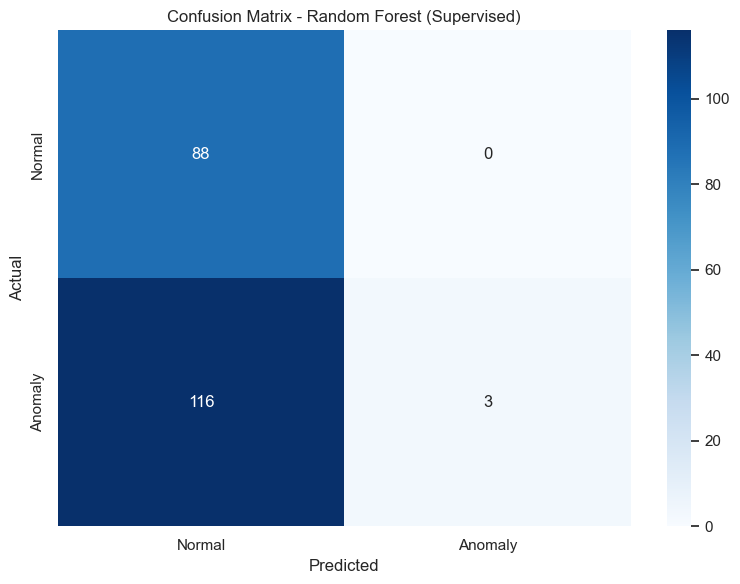

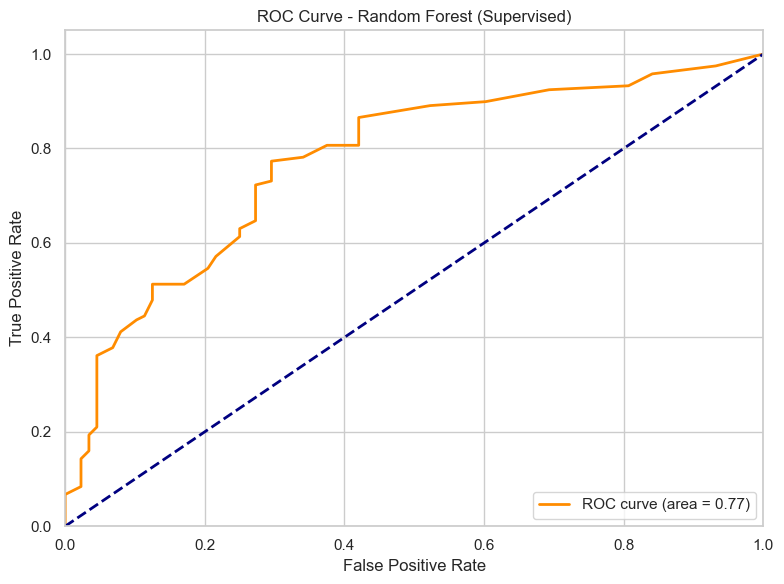

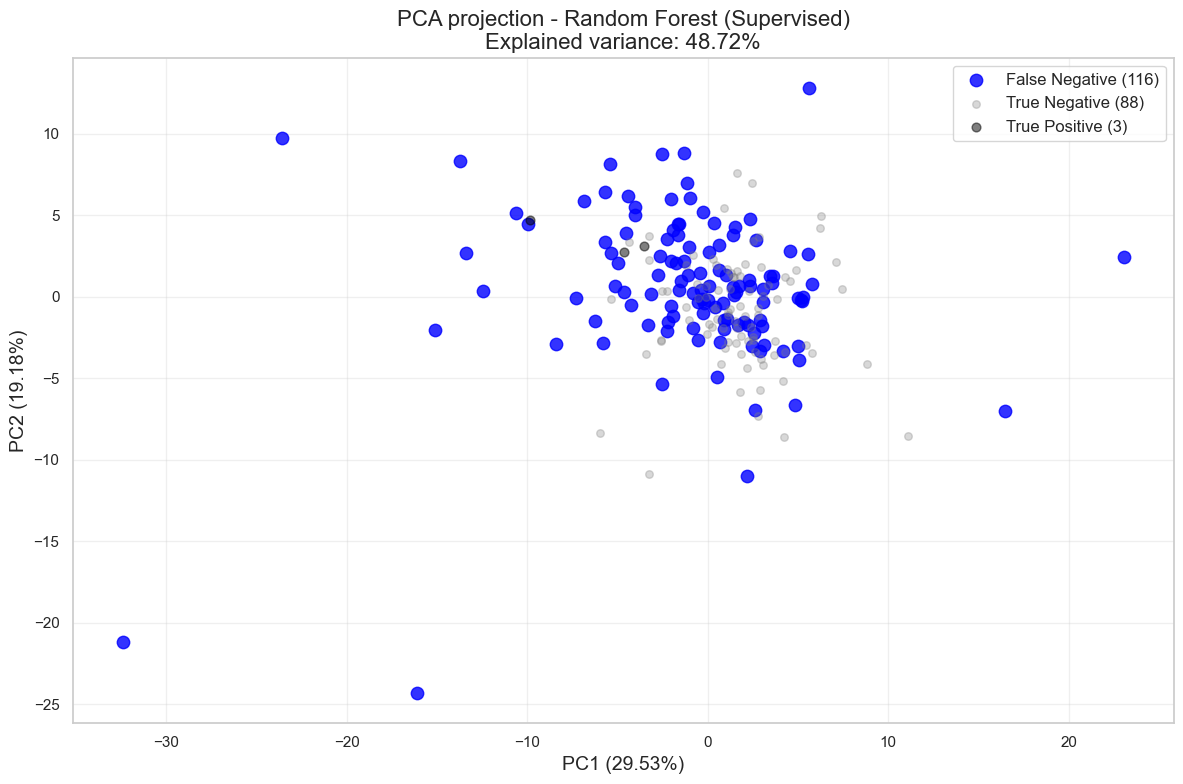


Training Support Vector Machine...

SVM (Supervised) Performance:
Precision: 0.8841
Recall: 0.5126
F1 Score: 0.6489


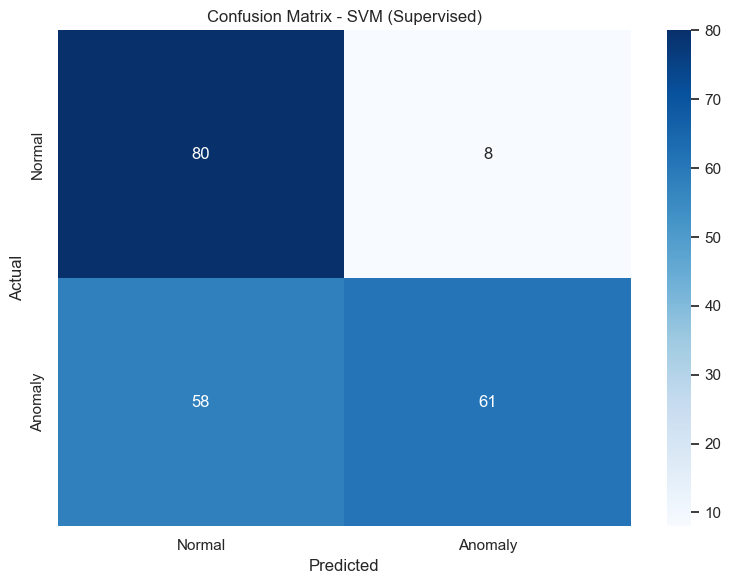

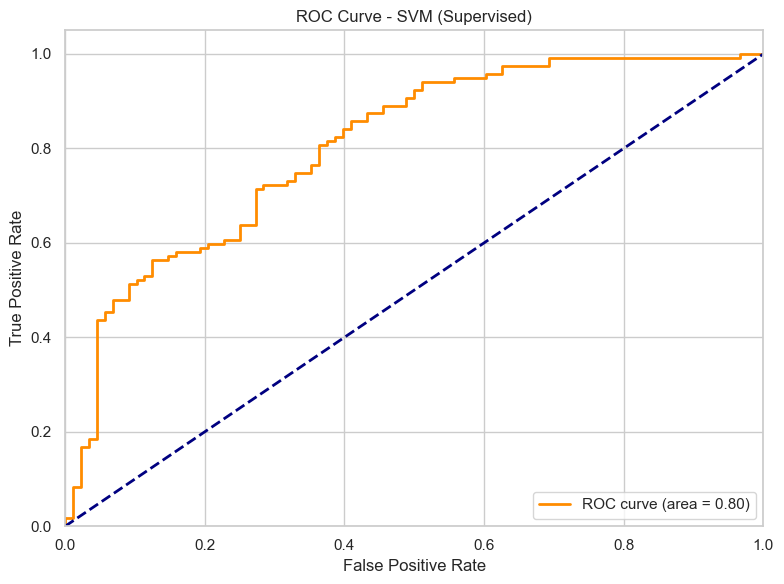

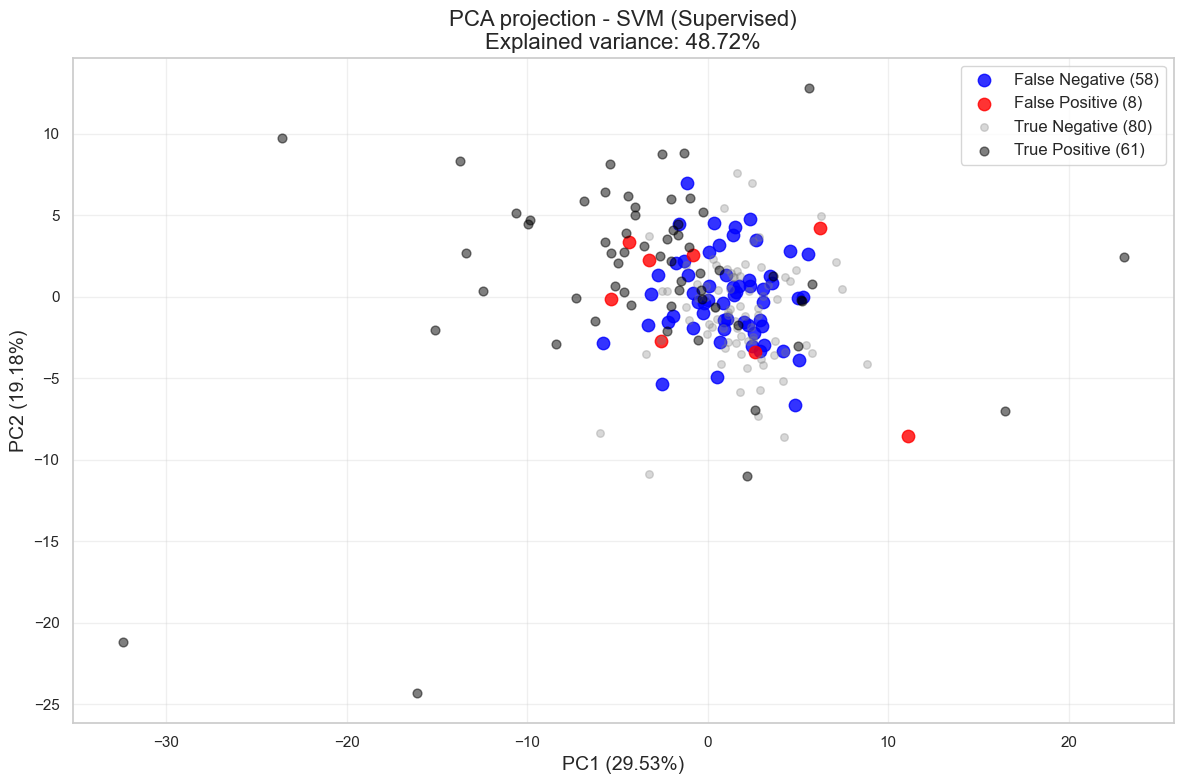

In [28]:
# 1. SUPERVISED APPROACHES

print("=" * 50)
print("SUPERVISED ANOMALY DETECTION METHODS")
print("=" * 50)

# 1.1 Random Forest Classifier
print("\nTraining Random Forest classifier...")
# For supervised methods, we need to combine training and cross-validation sets in order to have some anomalies to train with
X_train_cv = np.vstack((X_train_scaled, X_cv_scaled))
y_train_cv = np.hstack((np.zeros(len(X_train_scaled)), y_cross_val))

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train_cv, y_train_cv)  # Train on combined data

# Predict on test set
rf_pred = rf_model.predict(X_test_scaled)
rf_score = rf_model.predict_proba(X_test_scaled)[:, 1]  # Probability of class 1 (anomaly)

# Evaluate
rf_metrics = evaluate_model(y_test, rf_pred, rf_score, "Random Forest (Supervised)")
visualize_pca(X_test_scaled, y_test, rf_pred, "Random Forest (Supervised)")
results.append(("Random Forest (Supervised)", *rf_metrics))

# 1.2 Support Vector Machine
print("\nTraining Support Vector Machine...")
svm_model = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)
svm_model.fit(X_train_cv, y_train_cv)

# Predict on test set
svm_pred = svm_model.predict(X_test_scaled)
svm_score = svm_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate
svm_metrics = evaluate_model(y_test, svm_pred, svm_score, "SVM (Supervised)")
visualize_pca(X_test_scaled, y_test, svm_pred, "SVM (Supervised)")
results.append(("SVM (Supervised)", *svm_metrics))


And here we have come face to face with a mega-problem of **classifiers in Anomaly Detection**...

Namely, that an Anomaly Detection problem always has to do with an extremely unbalanced data set (if not, it wouldn't be Anomaly Detection): we are talking about **unbalanced classe**s. And when there are few examples to learn from, a classifier often learns little, and badly.

There are **various techniques to mitigate the problem of unbalanced classes**, all based on the basic idea of ​**​oversampling** the minority class or - guess what? - ...**undersampling** the majority class, all with quite clever tricks to generate synthetic data that are not exactly identical. But let's face it: they are almost always palliatives. We will talk about it in the next lesson, but if you are curious you can take a look at the idea of [SMOTE: Synthetic Minority Over-sampling Technique](https://arxiv.org/abs/1106.1813).

<br>

### Unsupervised Models

We now test a series of unsupervised models — these do **not use any labels during training** and rely solely on data structure. So we don't use our response vector Y during the training.

The models we consider are:

- **[Isolation Forest](https://en.wikipedia.org/wiki/Isolation_forest)**.
- **[One-Class SVM](https://en.wikipedia.org/wiki/One-class_classification)**.
- **[Local Outlier Factor (LOF)](https://en.wikipedia.org/wiki/Local_outlier_factor)**.
- **[Gaussian Mixture Model (GMM)](https://en.wikipedia.org/wiki/Mixture_model)**.

All of them require an estimate of the expected **contamination** (anomaly rate), which we derive from the validation set for consistency (not from the whole sample, otherwise it's overfitting...). To avoid degenerate behavior, we cap the contamination at 50%.

> This step is critical for models like Isolation Forest and LOF.
> that rely on this hyperparameter to tune internal decision thresholds.


Here we use the original data split (train\cv\test).

> ⚠️ Memento: unlike the supervised case, here **anomalies are not used at all during training**. Let's see how it goes...


In [29]:
# 2. UNSUPERVISED APPROACHES

print("\n" + "=" * 50)
print("UNSUPERVISED ANOMALY DETECTION METHODS")
print("=" * 50)

# Calculate contamination from cross-validation set
raw_contamination = np.mean(y_cross_val)
print(f"\nEstimated contamination from cross-validation set: {raw_contamination:.4f}")

# Cap contamination for algorithms that have limits
contamination = min(raw_contamination, 0.5)
print(f"Using capped contamination value: {contamination:.4f}")



UNSUPERVISED ANOMALY DETECTION METHODS

Estimated contamination from cross-validation set: 0.5756
Using capped contamination value: 0.5000


#### Isolation Forest

The Isolation Forest algorithm isolates anomalies by recursively partitioning the data using random splits.

It is efficient, scalable, and works well in high dimensions.



Training Isolation Forest...

Isolation Forest (Unsupervised) Performance:
Precision: 0.6838
Recall: 0.7815
F1 Score: 0.7294


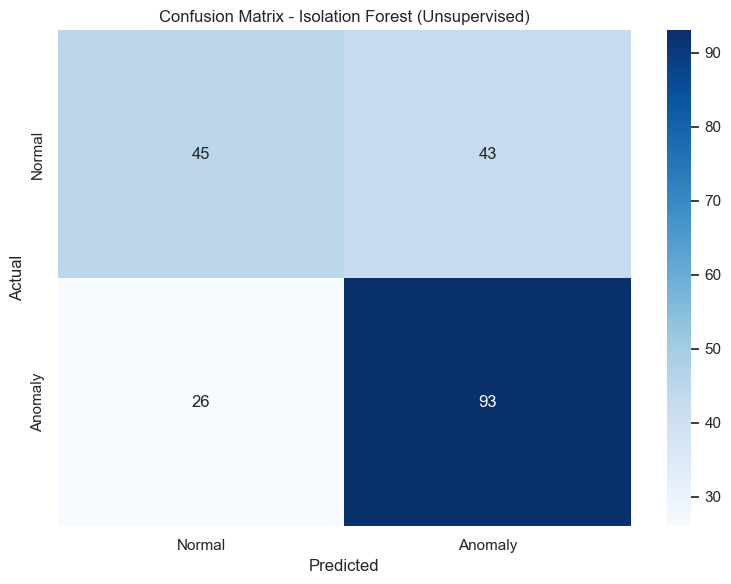

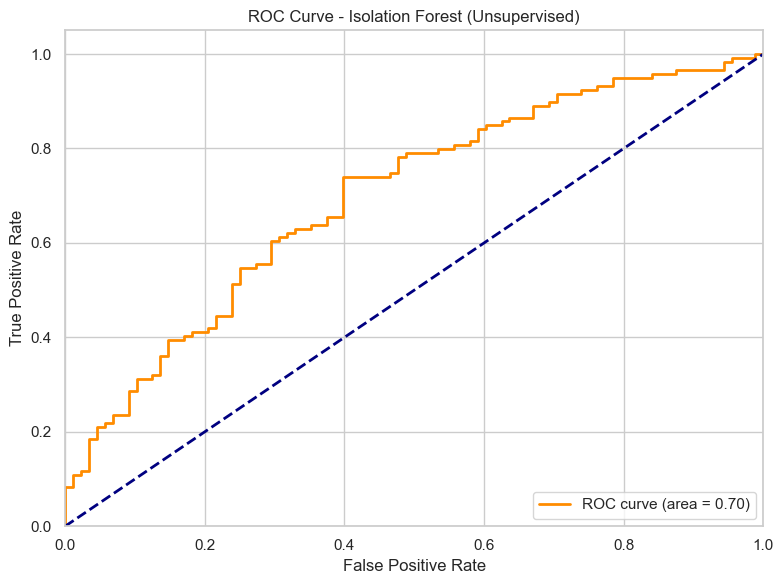

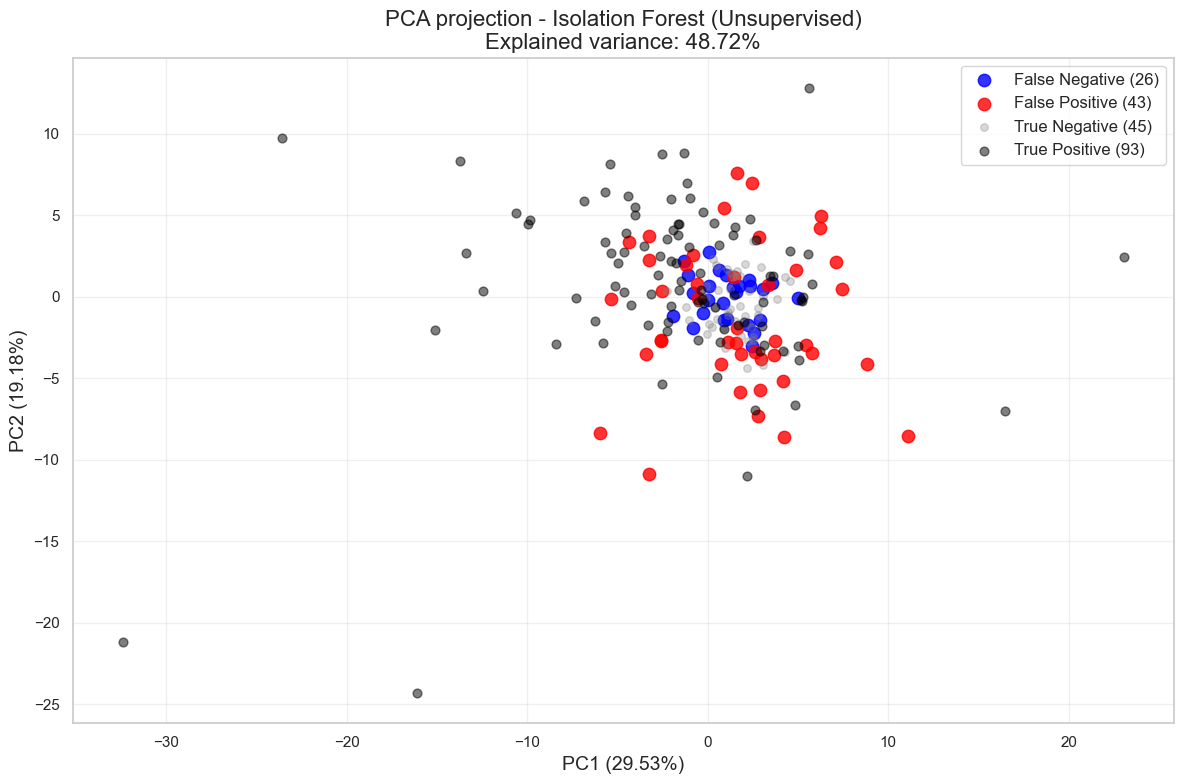

In [30]:
# 2.1 Isolation Forest
print("\nTraining Isolation Forest...")
iso_model = IsolationForest(contamination=contamination, random_state=42)
iso_model.fit(X_train_scaled)

# Predict on test set (convert from 1/-1 to 0/1, where 1 means anomaly)
iso_pred = (iso_model.predict(X_test_scaled) == -1).astype(int)
iso_score = -iso_model.score_samples(X_test_scaled)  # Negative of the anomaly score

# Evaluate
iso_metrics = evaluate_model(y_test, iso_pred, iso_score, "Isolation Forest (Unsupervised)")
visualize_pca(X_test_scaled, y_test, iso_pred, "Isolation Forest (Unsupervised)")
results.append(("Isolation Forest (Unsupervised)", *iso_metrics))


#### One-Class SVM

The One-Class SVM algorithm learns a soft boundary that encloses the majority of the data, treating anything outside this boundary as an anomaly.

It is sensitive to the **nu** parameter, which controls the upper bound on the anomaly fraction and the lower bound on the number of support vectors.

We set `nu` based on the estimated contamination rate, capped to avoid instability.

> 🧠 *Insight*:
> You can think of the One-Class SVM as a **non-linear version**  
> of our initial MVG-based model — both aim to define a boundary around “normal” data,  
> but OCSVM does so using a flexible, **kernel-based surface instead of ellipsoids**.

<br>


Training One-Class SVM...
Using nu value for OneClassSVM: 0.5000

One-Class SVM (Unsupervised) Performance:
Precision: 0.6643
Recall: 0.7983
F1 Score: 0.7252


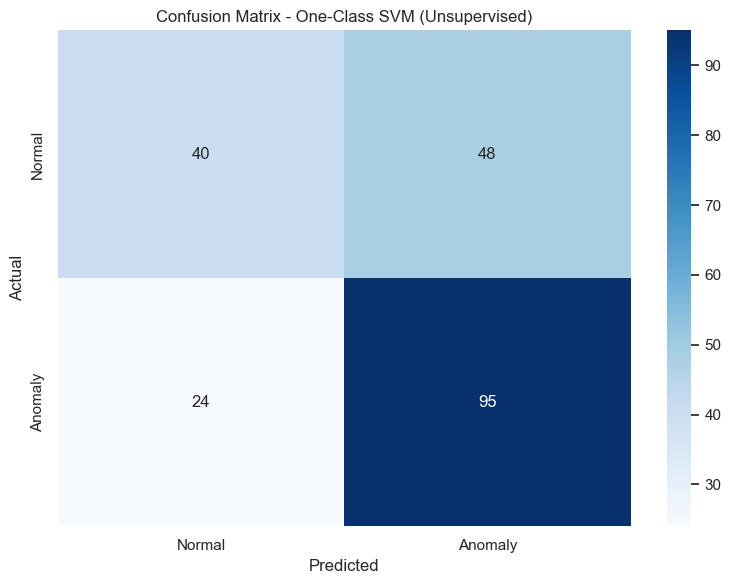

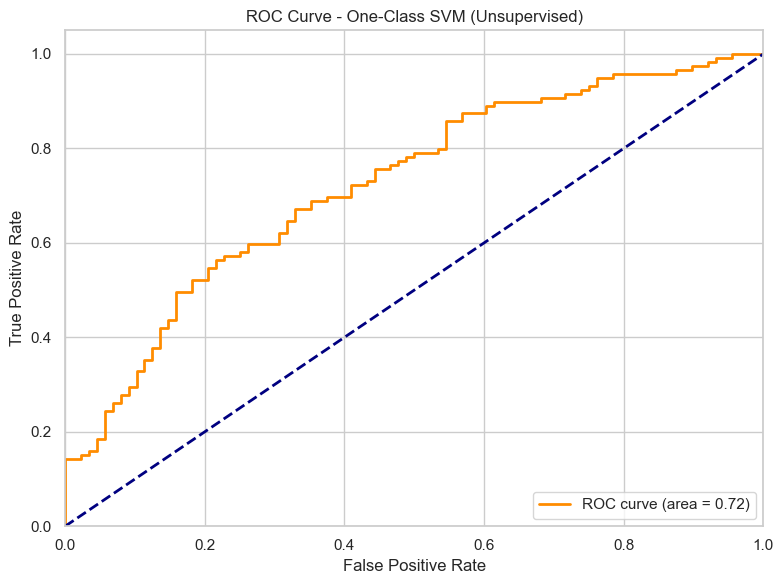

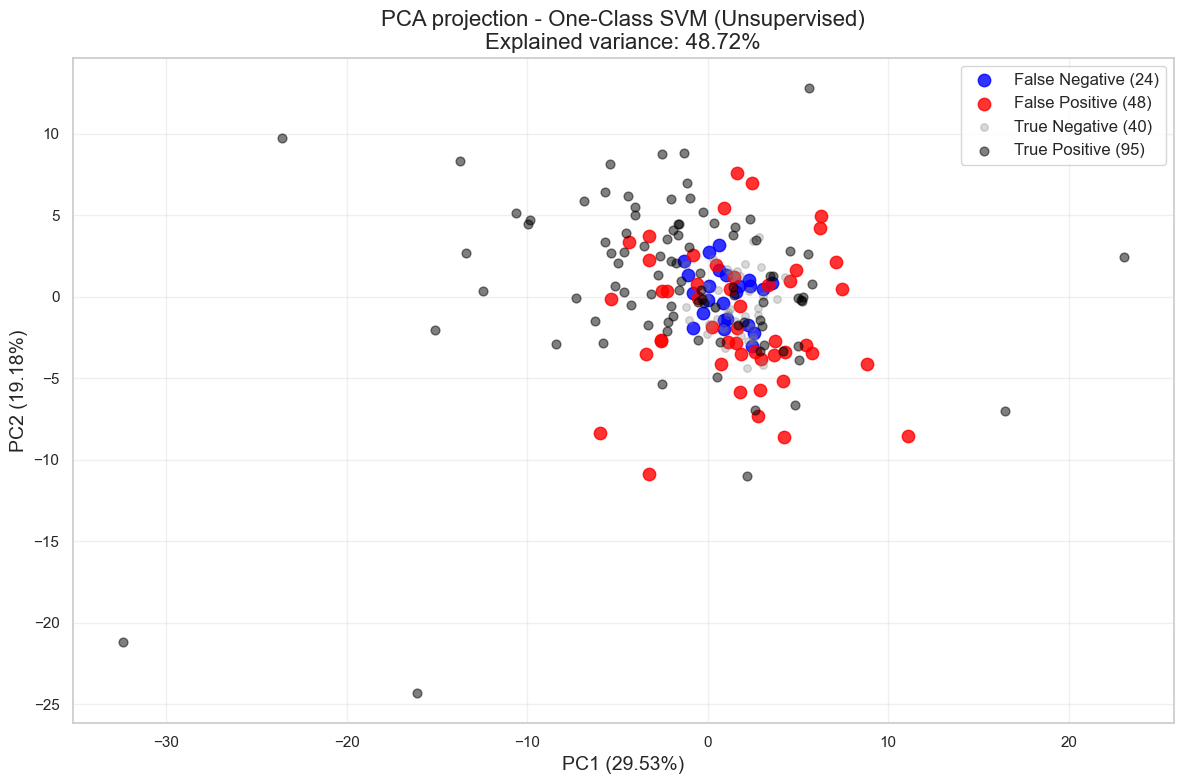

In [31]:
# 2.2 One-Class SVM
print("\nTraining One-Class SVM...")
# OneClassSVM's nu parameter is the upper bound on the fraction of training errors
# and the lower bound of the fraction of support vectors, so it should be in (0, 1)
nu = min(max(0.01, contamination), 0.99)
print(f"Using nu value for OneClassSVM: {nu:.4f}")

ocsvm_model = OneClassSVM(gamma='auto', nu=nu)
ocsvm_model.fit(X_train_scaled)

# Predict on test set
ocsvm_pred = (ocsvm_model.predict(X_test_scaled) == -1).astype(int)
ocsvm_score = -ocsvm_model.decision_function(X_test_scaled)  # Negative of the decision function

# Evaluate
ocsvm_metrics = evaluate_model(y_test, ocsvm_pred, ocsvm_score, "One-Class SVM (Unsupervised)")
visualize_pca(X_test_scaled, y_test, ocsvm_pred, "One-Class SVM (Unsupervised)")
results.append(("One-Class SVM (Unsupervised)", *ocsvm_metrics))


#### Local Outlier Factor (LOF)

LOF detects anomalies by comparing the **local density** of a point to that of its neighbors.

Points that reside in **sparser regions** relative to their surroundings are flagged as outliers.

It is sensitive to the number of neighbors and to the contamination parameter.  
We use `novelty=True` to enable scoring on new, unseen test data.

<br>



Training Local Outlier Factor...

Local Outlier Factor (Unsupervised) Performance:
Precision: 0.6735
Recall: 0.8319
F1 Score: 0.7444


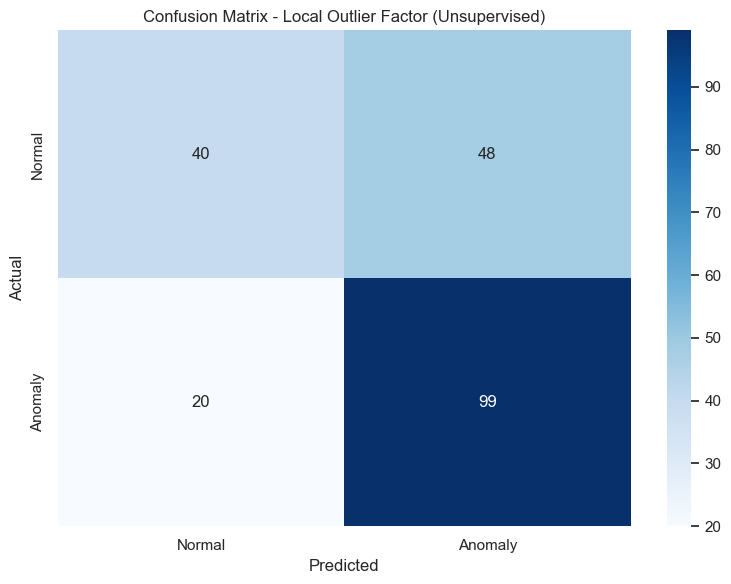

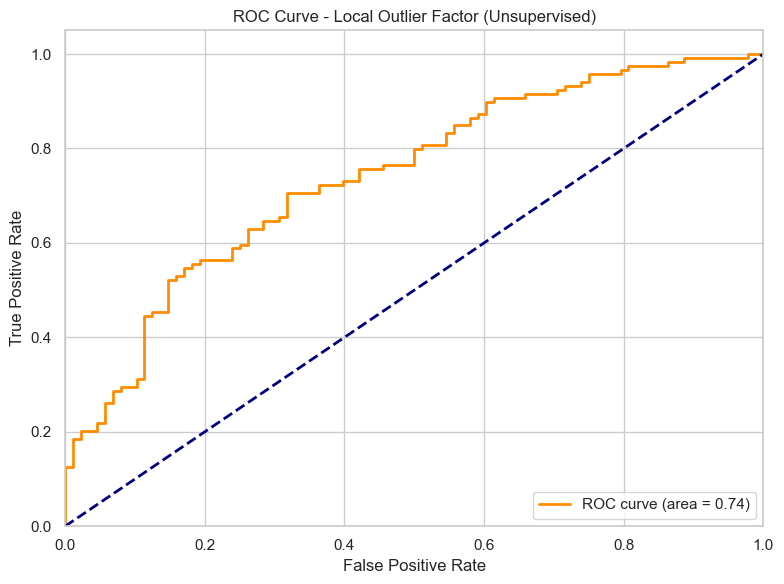

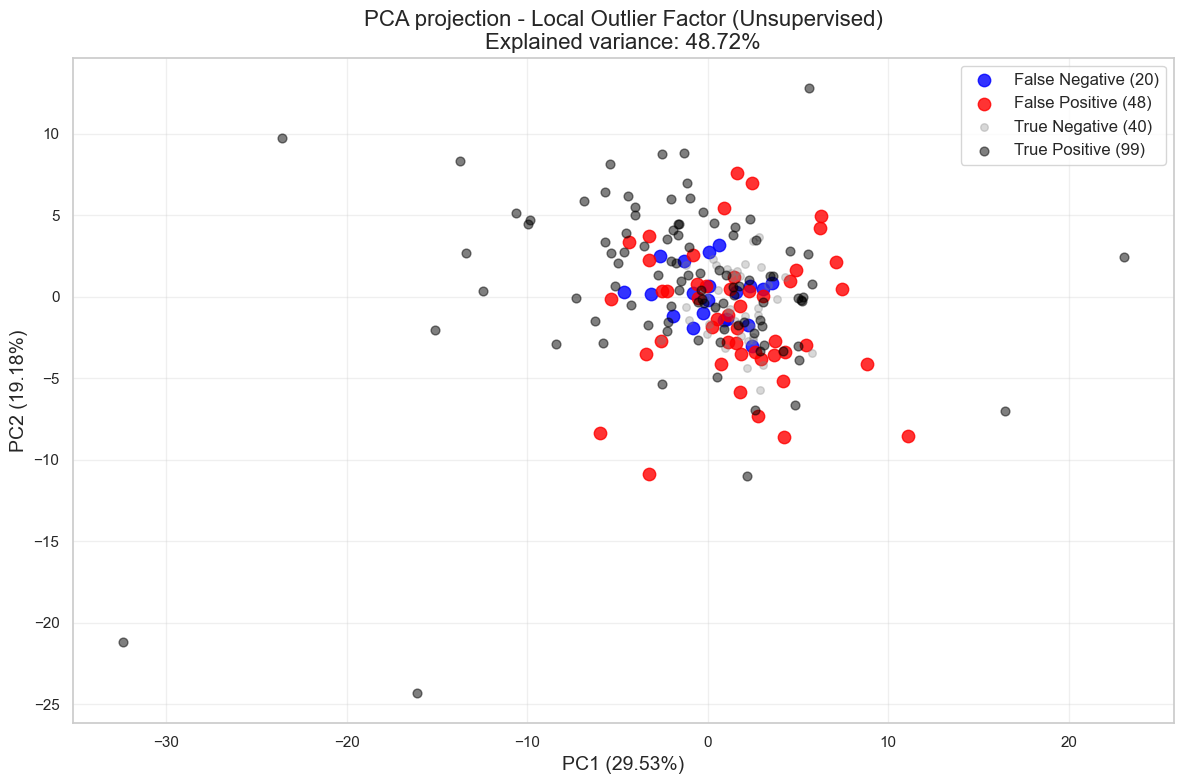

In [32]:
# 2.3 Local Outlier Factor
print("\nTraining Local Outlier Factor...")
# LOF also has a contamination parameter with the same constraints as Isolation Forest
lof_model = LocalOutlierFactor(n_neighbors=20, contamination=contamination, novelty=True)
lof_model.fit(X_train_scaled)

# Predict on test set
lof_pred = (lof_model.predict(X_test_scaled) == -1).astype(int)
lof_score = -lof_model.decision_function(X_test_scaled)  # Negative of the decision function

# Evaluate
lof_metrics = evaluate_model(y_test, lof_pred, lof_score, "Local Outlier Factor (Unsupervised)")
visualize_pca(X_test_scaled, y_test, lof_pred, "Local Outlier Factor (Unsupervised)")
results.append(("Local Outlier Factor (Unsupervised)", *lof_metrics))


#### Gaussian Mixture Model (GMM)

We now use a **2-component Gaussian Mixture Model** to estimate  the log-likelihood of each point under a flexible, **multimodal distribution**.

This approach can capture more complex patterns in the "normal" data,
compared to a single Gaussian (baseline model) which imposes an ellipsoidal structure.

The normal mixture is one of the most flexible distributions on Earth, adapting to skewness, leptokurtosis, and generally complex patterns.
(Be aware that using mixtures with 3 or more components is not trivial: the number of parameters explodes, overfitting and numerical instability are common, unless you have very large datasets.)

Points with **low likelihood** are flagged as anomalies.

We use the contamination rate from the validation set to define the decision threshold.

<br>


Training Gaussian Mixture Model...

Gaussian Mixture Model (Unsupervised) Performance:
Precision: 0.7227
Recall: 0.7227
F1 Score: 0.7227


/Users/mouadh/Fintech_Projects/Business_Case_4/venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mouadh/Fintech_Projects/Business_Case_4/venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mouadh/Fintech_Projects/Business_Case_4/venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


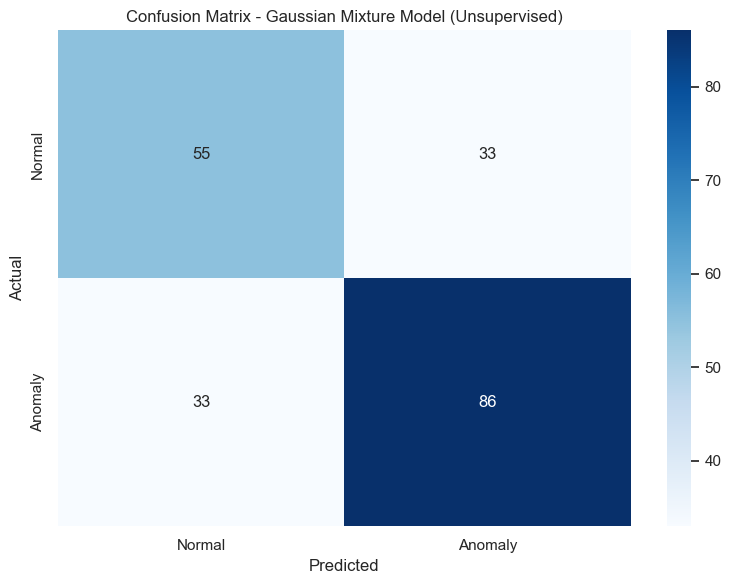

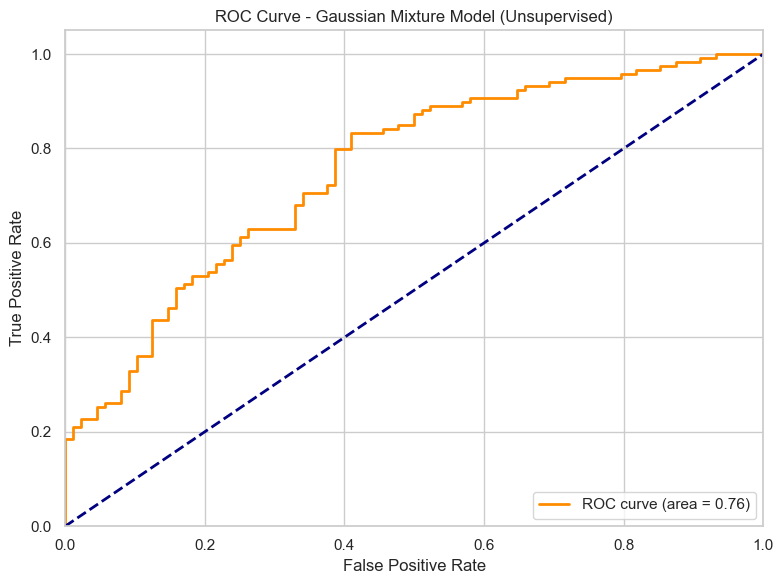

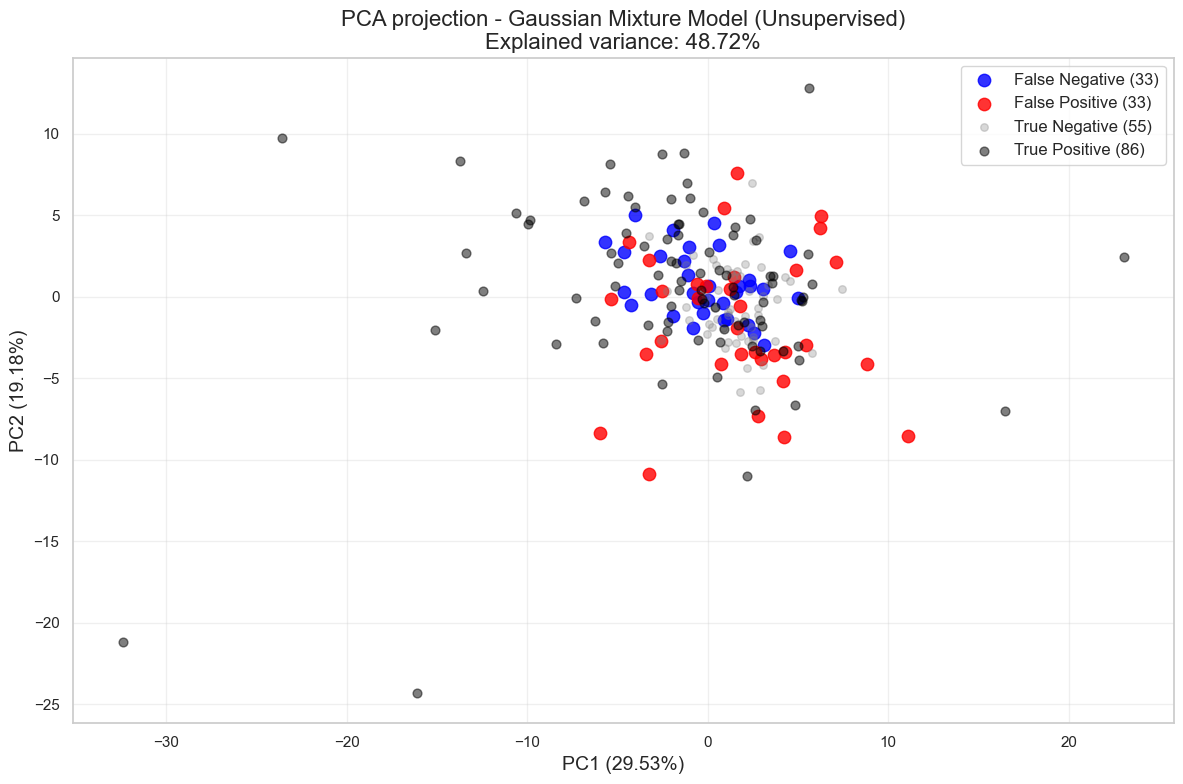

In [33]:
# 2.4 Gaussian Mixture Model - 2 components
from sklearn.mixture import GaussianMixture

print("\nTraining Gaussian Mixture Model...")
gmm_model = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm_model.fit(X_train_scaled)

# Predict on test set
gmm_score = -gmm_model.score_samples(X_test_scaled)  # Negative log-likelihood as anomaly score
# For GMM we can use the raw contamination as it doesn't have the same constraints
threshold = np.percentile(gmm_score, 100 * (1 - raw_contamination))
gmm_pred = (gmm_score > threshold).astype(int)

# Evaluate
gmm_metrics = evaluate_model(y_test, gmm_pred, gmm_score, "Gaussian Mixture Model (Unsupervised)")
visualize_pca(X_test_scaled, y_test, gmm_pred, "Gaussian Mixture Model (Unsupervised)")
results.append(("Gaussian Mixture Model (Unsupervised)", *gmm_metrics))


<br>

Let's **summarize unsupervised model and results** - without forgetting the (apparently stupid) initial model.

<br>


### 🧩 Unsupervised Models – Summary Table

<br>

| **Model**                   | **Uses Labels**                      | **Requires Contamination** | **Decision Boundary**         | **Notes** |
|-----------------------------|--------------------------------------|-----------------------------|-------------------------------|-----------|
| **MVG (baseline)**          | ✅ Partial (only for $\varepsilon$)  | ✅ Yes (for threshold)      | Elliptical (parametric)       | Fits only normal class; interpretable and simple |
| Gaussian Mixture (1 comp.)  | ❌ No                                | Optional                    | Elliptical (parametric)       | Equivalent to MVG, but fitted in unsupervised mode |
| Gaussian Mixture (2 comp.)  | ❌ No                                | Optional                    | Soft, multimodal              | Captures more complex “normal” structure |
| Isolation Forest            | ❌ No                                | ✅ Yes                      | Axis-aligned partitions       | Fast, scalable, non-parametric |
| One-Class SVM               | ❌ No                                | ✅ Yes (`nu`)               | Non-linear (kernel-based)     | Flexible but sensitive to `nu` |
| Local Outlier Factor        | ❌ No                                | ✅ Yes                      | Local density comparison      | Needs `novelty=True` to work as a detector |

---

<br>

> 💡 Note: **MVG vs GMM (1 component)**  
> Although mathematically identical  - both estimate $N(\mu, \Sigma)$ -
> they differ in **how they are used**:
> - MVG baseline fits **only normal data** and uses labels to tune the threshold i.e., it's supervised, or semi-supervised if you like.  
> - GMM (1 comp.) fits the **entire dataset blindly**, fully unsupervised.


<br>

In [34]:
# Create a DataFrame with results
results_df = pd.DataFrame(results, columns=['Model', 'Precision', 'Recall', 'F1 Score'])

# Print the results table
print("\nPerformance comparison: Supervised vs Unsupervised")
print(results_df.sort_values('F1 Score', ascending=False).to_string(index=False))

print("\nMemento: Baseline model performance:")
print(f"Precision: {MVG_precision:.4f}")
print(f"Recall: {MVG_recall:.4f}")
print(f"F1 Score: {MVG_f1:.4f}")



Performance comparison: Supervised vs Unsupervised
                                Model  Precision   Recall  F1 Score
  Local Outlier Factor (Unsupervised)   0.673469 0.831933  0.744361
      Isolation Forest (Unsupervised)   0.683824 0.781513  0.729412
         One-Class SVM (Unsupervised)   0.664336 0.798319  0.725191
Gaussian Mixture Model (Unsupervised)   0.722689 0.722689  0.722689
                     SVM (Supervised)   0.884058 0.512605  0.648936
           Random Forest (Supervised)   1.000000 0.025210  0.049180

Memento: Baseline model performance:
Precision: 0.6031
Recall: 0.9832
F1 Score: 0.7476


### 🔍 Autoencoder (Deep Learning) for Anomaly Detection

An **Autoencoder** is a type of **neural network** designed to learn a compressed representation of the data.

It consists of:

- An **encoder**: reduces the input to a lower-dimensional space (the **bottleneck**).
- A **decoder**: reconstructs the input from this compressed version.

The result is a model that learns to **encode the structure of normal data**.

Autoencoders belong to the family of **latent variable models**, just like:

- **PCA** (which finds linear projections).
- **Factor models** (which assume a linear dependence on unobserved factors).

However, an autoencoder can model **highly nonlinear structures** in the data,  
thanks to the expressive power of neural networks.

> The **bottleneck** forces the network to compress information.  
> The model must learn what's essential — and discard the rest.

Some readings:
- [Autoencoders](https://en.wikipedia.org/wiki/Autoencoder).
- [Deep Learning - Autoencoders](https://www.deeplearningbook.org/contents/autoencoders.html).
- [A comprehensive study of auto-encoders for anomaly detection: Efficiency and trade-offs](https://www.sciencedirect.com/science/article/pii/S2666827024000483?dgcid=rss_sd_all)


<br>

 <br>

Below is a schematic view of an Autoencoder: the bottleneck compresses the input into a latent representation, then the decoder tries to reconstruct the original input.


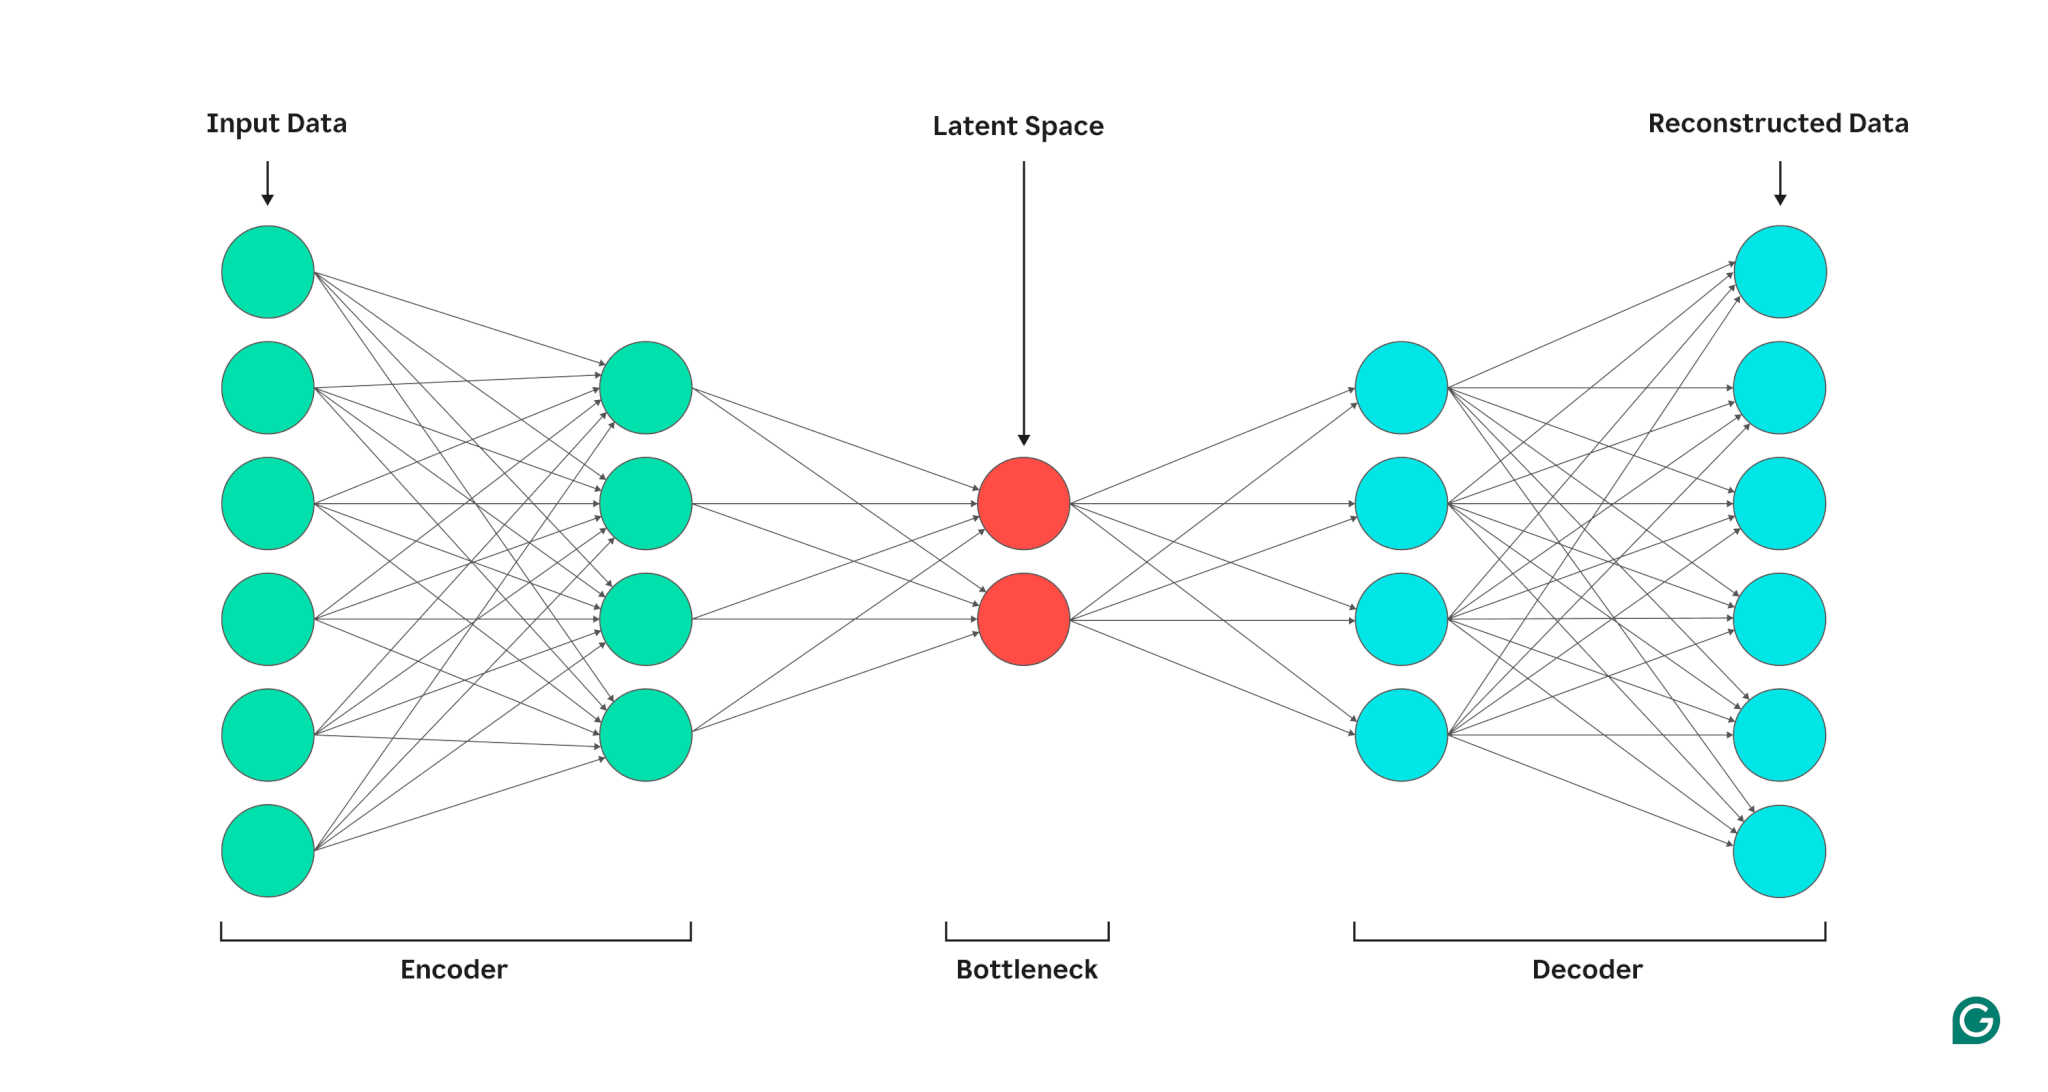


<br>

### 🧠 How does this Autoencoder work?

Unlike the other models we used, the autoencoder does **not** output a label or probability: It learns to **reconstruct the input** as accurately as possible, based on the structure it observes in the data.

>If a point is reconstructed **poorly**, we assume it's **anomalous**.  
>If it's reconstructed **well**, we assume it's **normal**.

This method focuses again - like the Gaussian baseline model - on modeling *normality* — just with a more flexible model: the difference is that the definition of “normal” is now learned via Deep Learning, and anomalies are detected based on how badly they are reconstructed — that is, by their reconstruction error.

This approach is:
- **Unsupervised during training**: we don’t use labels at all.
- **Supervised for threshold tuning**: we still use the validation set to set the anomaly threshold (just like before, with the Gaussian baseline model).

<br>

### 🧠 Neural Network architecture

More precisely, the Autoencoder is a symmetric feedforward Neural Network with two parts:

- The **encoder**, which compresses the input into a lower-dimensional representation (the **latent space**).
- The **decoder**, which tries to reconstruct the original input from this compressed code.

Both parts are trained **jointly** by minimizing the reconstruction error  
(we use **Mean Squared Error**, MSE, as the loss function).

We also use techniques like:

- **Batch Normalization**: to stabilize training.
- **Dropout**: to reduce overfitting.


In [35]:
# 3.  Deep Learning methods: Autoencoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Check if GPU is available
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
X_cv_tensor = torch.FloatTensor(X_cv_scaled).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)

# Create DataLoaders
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)  # Input = Output for autoencoder
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=16):
        super(Autoencoder, self).__init__()

        # Calculate layer sizes for a gradually decreasing architecture
        layer1_size = input_dim // 2
        layer2_size = layer1_size // 2

        # Ensure minimum size
        layer1_size = max(layer1_size, encoding_dim * 2)
        layer2_size = max(layer2_size, encoding_dim)

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, layer1_size),
            nn.BatchNorm1d(layer1_size),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(layer1_size, layer2_size),
            nn.BatchNorm1d(layer2_size),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(layer2_size, encoding_dim),
            nn.BatchNorm1d(encoding_dim),
            nn.ReLU(True)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, layer2_size),
            nn.BatchNorm1d(layer2_size),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(layer2_size, layer1_size),
            nn.BatchNorm1d(layer1_size),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(layer1_size, input_dim),
            nn.Tanh()  # Output activation to match standardized data range
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def encode(self, x):
        return self.encoder(x)

# Get input dimension from data
input_dim = X_train_scaled.shape[1]
print(f"Input dimension: {input_dim}")

# Create the autoencoder model
encoding_dim = min(16, input_dim // 4)  # Adjust encoding dimension based on input size
model = Autoencoder(input_dim, encoding_dim).to(device)
print(f"Encoding dimension: {encoding_dim}")
print(model)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training function
def train_autoencoder(model, train_loader, num_epochs=100, patience=10):
    # For early stopping
    best_loss = float('inf')
    no_improve_epochs = 0

    # For plotting
    train_losses = []

    print("Training autoencoder...")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for data, _ in train_loader:
            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, data)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * data.size(0)

        # Calculate epoch loss
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.6f}')

        # Early stopping
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            no_improve_epochs = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_autoencoder.pth')
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

    # Load the best model
    model.load_state_dict(torch.load('best_autoencoder.pth'))

    # Plot training loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses)
    plt.title('Autoencoder Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.grid(True)
    plt.show()

    return model


Using device: mps
Input dimension: 42
Encoding dimension: 10
Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=42, out_features=21, bias=True)
    (1): BatchNorm1d(21, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=21, out_features=10, bias=True)
    (5): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=10, out_features=10, bias=True)
    (9): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=10, out_features=2

### 🏋️‍♀️ Training with Early Stopping

As we have seen before, we train the model on **normal data only**, using reconstruction loss as the objective.  
To avoid overfitting and speed up training, we use **early stopping**: if the loss doesn't improve after a number of epochs, we stop the training.

We store the model with the **lowest validation loss**, not the final epoch.  

---

<br>

Once trained, the autoencoder can be used as follows:

1. Feed the input to the model.
2. Compute the **reconstruction error** for each point.
3. Use a **threshold** on the reconstruction error to classify anomalies.

We select the threshold by looking at the reconstruction errors on the cross-validation set and using the **contamination rate** (i.e., percentage of anomalies) to determine the cutoff.  

<br>

Training autoencoder...
Epoch 10/200, Loss: 0.936583
Epoch 20/200, Loss: 0.857709
Epoch 30/200, Loss: 0.799634
Epoch 40/200, Loss: 0.770428
Epoch 50/200, Loss: 0.745594
Epoch 60/200, Loss: 0.748907
Epoch 70/200, Loss: 0.740589
Epoch 80/200, Loss: 0.731490
Epoch 90/200, Loss: 0.729362
Epoch 100/200, Loss: 0.721930
Epoch 110/200, Loss: 0.722033
Epoch 120/200, Loss: 0.708858
Epoch 130/200, Loss: 0.716327
Epoch 140/200, Loss: 0.703322
Epoch 150/200, Loss: 0.702941
Epoch 160/200, Loss: 0.710559
Epoch 170/200, Loss: 0.709645
Early stopping at epoch 171


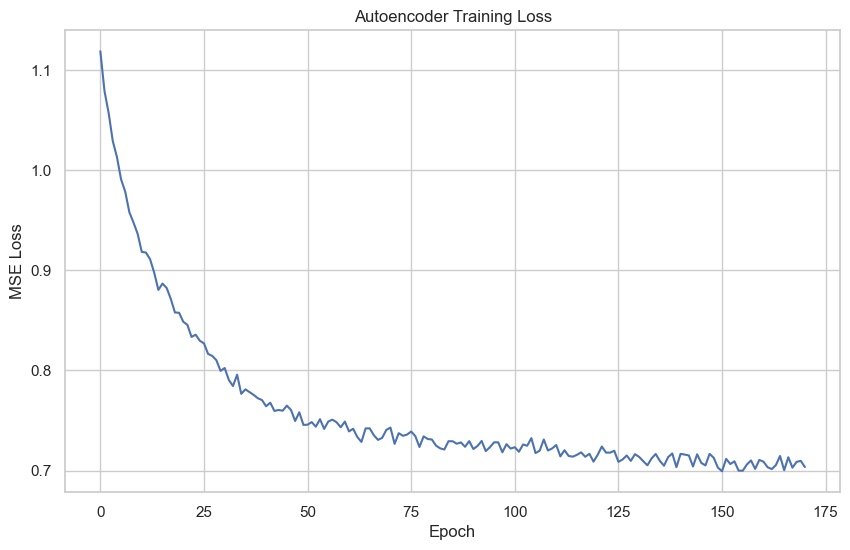

Contamination rate from cross-validation set: 0.5756


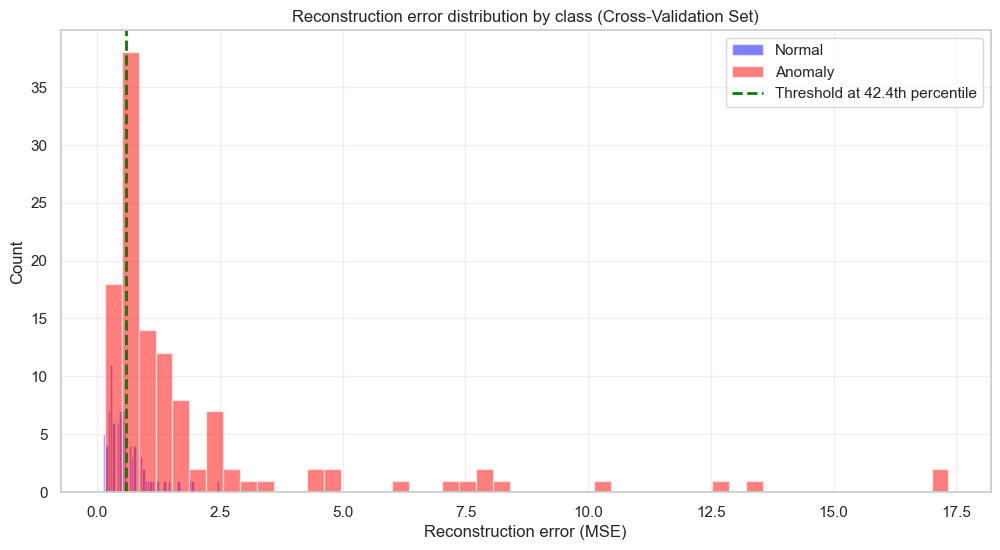

Threshold for anomaly detection: 0.582275


In [36]:
# Train the autoencoder
model = train_autoencoder(model, train_loader, num_epochs=200, patience=20)

# Function to compute reconstruction error
def compute_reconstruction_error(model, data_tensor):
    model.eval()
    with torch.no_grad():
        reconstructions = model(data_tensor)
        # Compute MSE for each sample
        mse = ((reconstructions - data_tensor) ** 2).mean(dim=1).cpu().numpy()
    return mse

# Compute reconstruction errors
train_errors = compute_reconstruction_error(model, X_train_tensor)
cv_errors = compute_reconstruction_error(model, X_cv_tensor)
test_errors = compute_reconstruction_error(model, X_test_tensor)

# Determine threshold for anomaly detection using cross-validation set
# We'll use the contamination rate from the cross-validation set
contamination = np.mean(y_cross_val)
print(f"Contamination rate from cross-validation set: {contamination:.4f}")

# Find the threshold that best separates normal and anomalous examples in the CV set
cv_errors_normal = cv_errors[y_cross_val == 0]
cv_errors_anomaly = cv_errors[y_cross_val == 1]

# Plot histogram of reconstruction errors by class
plt.figure(figsize=(12, 6))
plt.hist(cv_errors_normal, bins=50, alpha=0.5, label='Normal', color='blue')
plt.hist(cv_errors_anomaly, bins=50, alpha=0.5, label='Anomaly', color='red')
plt.axvline(x=np.percentile(cv_errors, 100 * (1 - contamination)),
            color='green', linestyle='dashed', linewidth=2,
            label=f'Threshold at {100 * (1 - contamination):.1f}th percentile')
plt.title('Reconstruction error distribution by class (Cross-Validation Set)')
plt.xlabel('Reconstruction error (MSE)')
plt.ylabel('Count')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Set threshold at the percentile corresponding to the contamination rate
threshold = np.percentile(cv_errors, 100 * (1 - contamination))
print(f"Threshold for anomaly detection: {threshold:.6f}")

# Make predictions on test set
y_pred = (test_errors > threshold).astype(int)



### Evaluation metrics

 In addition to the usual metrics, we show the plot with the **reconstruction error** for each point in the test set.

- Each dot is a data point.
- Color indicates the true label:  
  - 🔵 Blue for **normal**  
  - 🔴 Red for **anomalies**
- The green dashed line is the **threshold** used to classify a point as anomalous.

What does this chart tell us?

- Samples **above the threshold** are predicted as anomalies
- Samples **below** are classified as normal
- We can directly spot:
  - **False positives**: blue dots above the line
  - **False negatives**: red dots below the line

This is a simple but effective diagnostic tool to evaluate the classifier's behavior **based on its internal logic** (reconstruction error).  
It's also a sanity check: are anomalies really harder to reconstruct?

<br>

---

<br>

### 📊 A note on visualizing results with PCA and latent space

After training the autoencoder, we extract the **internal (latent) representation** of the test set.  
This is the output of the encoder — a compressed and abstract version of each input.

To make it visible, we apply **PCA** to this latent space.

Why?

- The latent space has too many dimensions to visualize.
- PCA gives us the two principal directions where the model encodes most variation.
- We use one **latent-variable model (PCA)** to inspect another **latent-variable model (the autoencoder)**

> 🌀 Like in the movie *Inception*, this is a model **within** a model.  
> 🧠 We *dive into the mind of the Autoencoder* to see how it thinks —  
> not through raw inputs, but through how it compresses and reconstructs the world. In order to do that, we need PCA to simplify the situation.


We then:

- Color the points based on **true vs predicted anomalies**.
- Explore the **structure of the latent space**.
- Visualize **where the reconstruction error is high**, and how it affects anomaly decisions.

These plots are not just for show: they provide some **qualitative insight** into the model’s logic, blind spots, and failure modes.

<br>


Autoencoder performance:
Precision: 0.6960
Recall: 0.7311
F1 Score: 0.7131


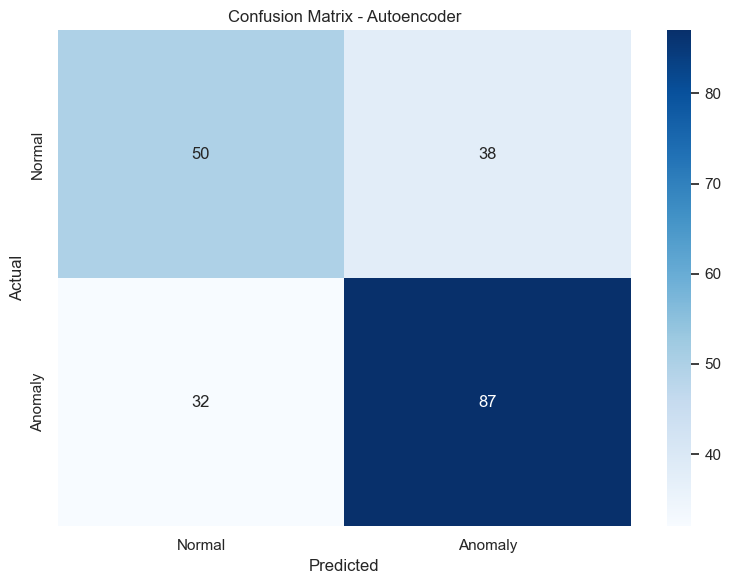

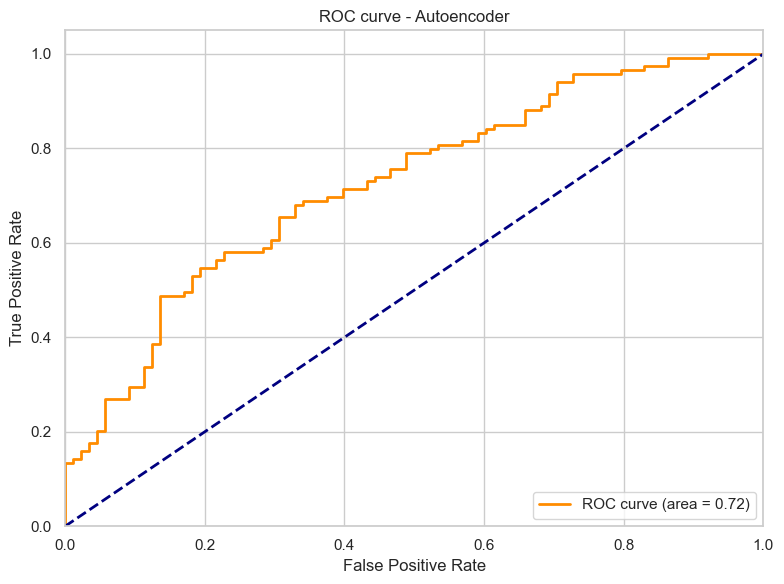

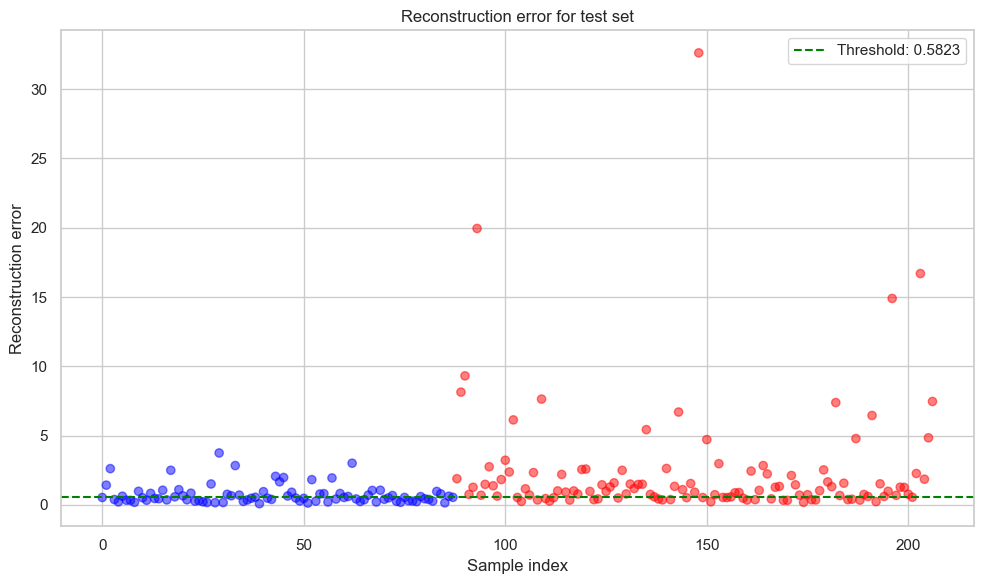

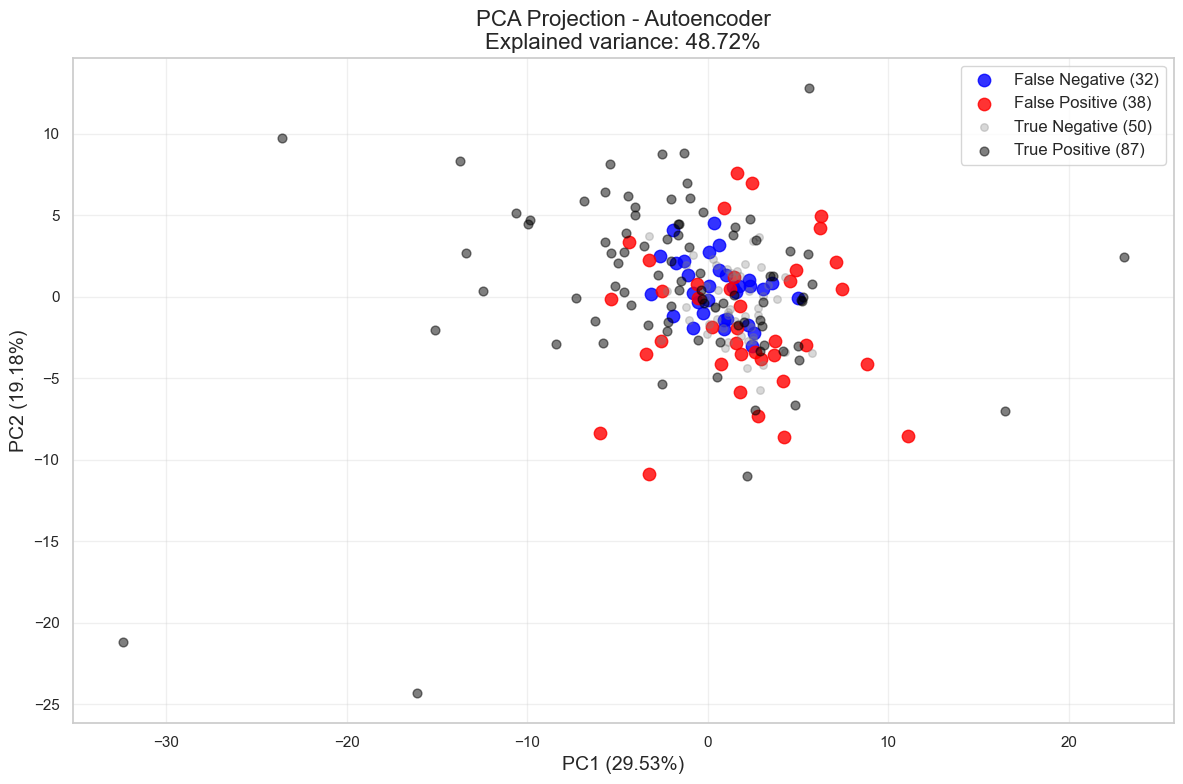

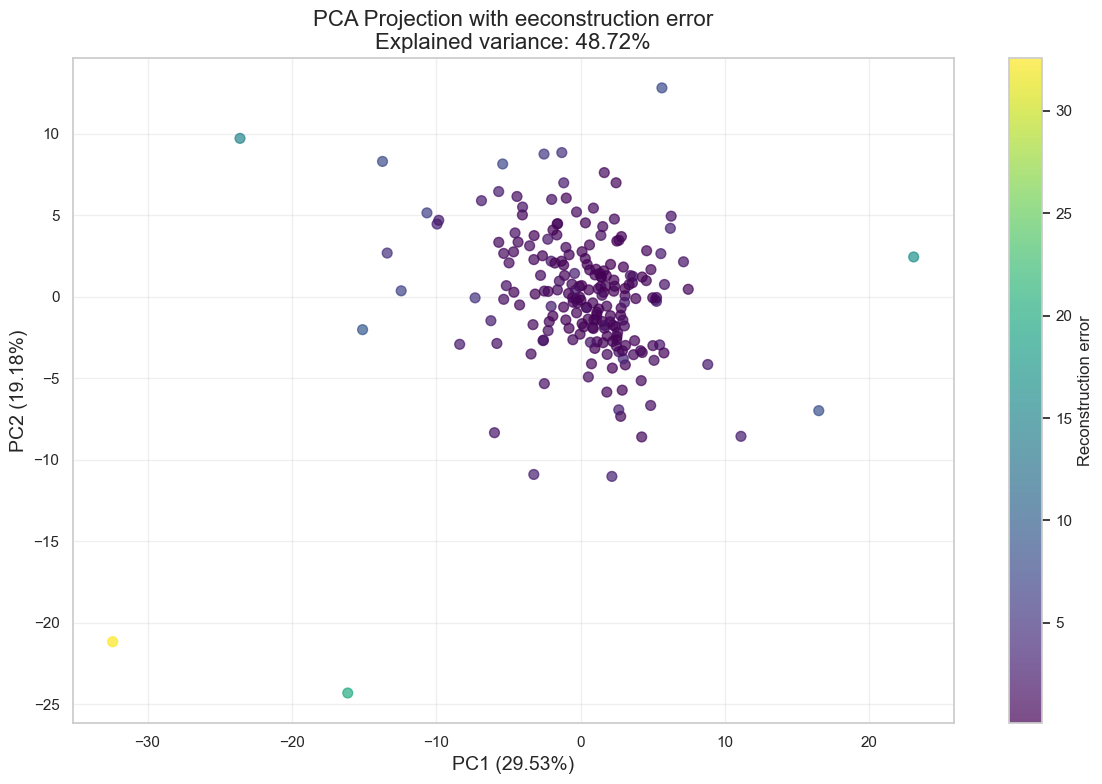

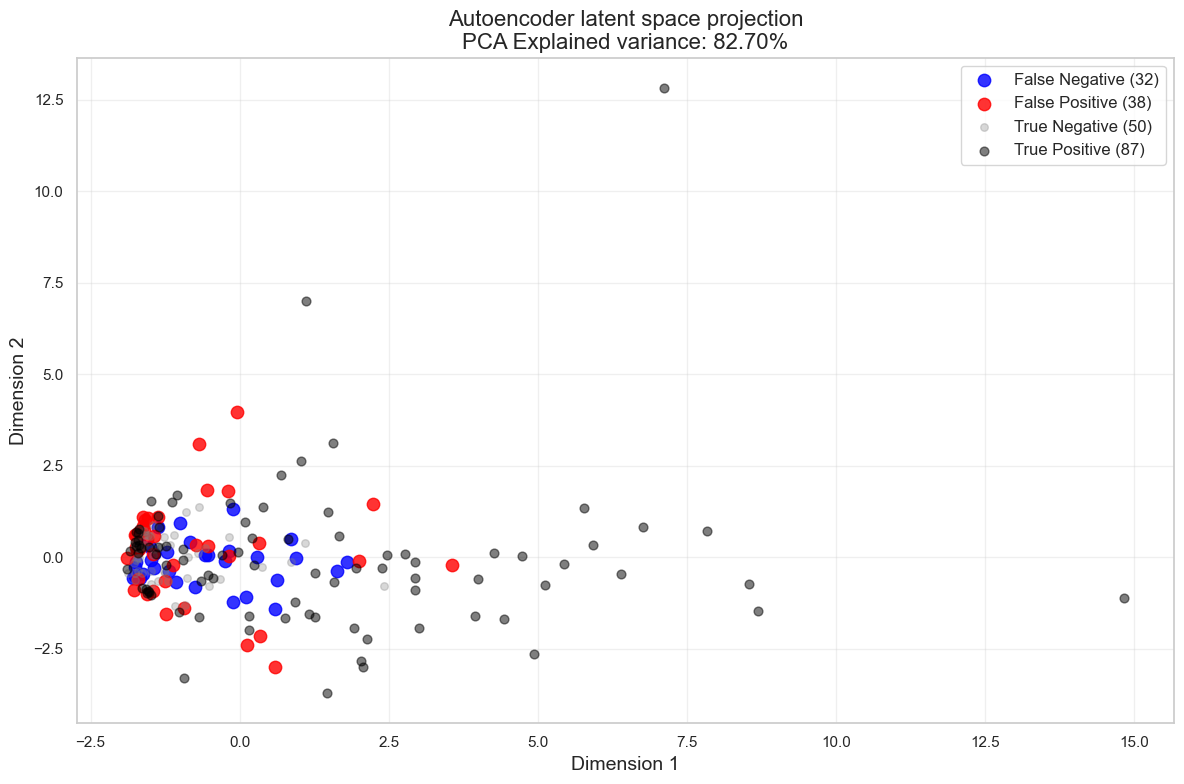

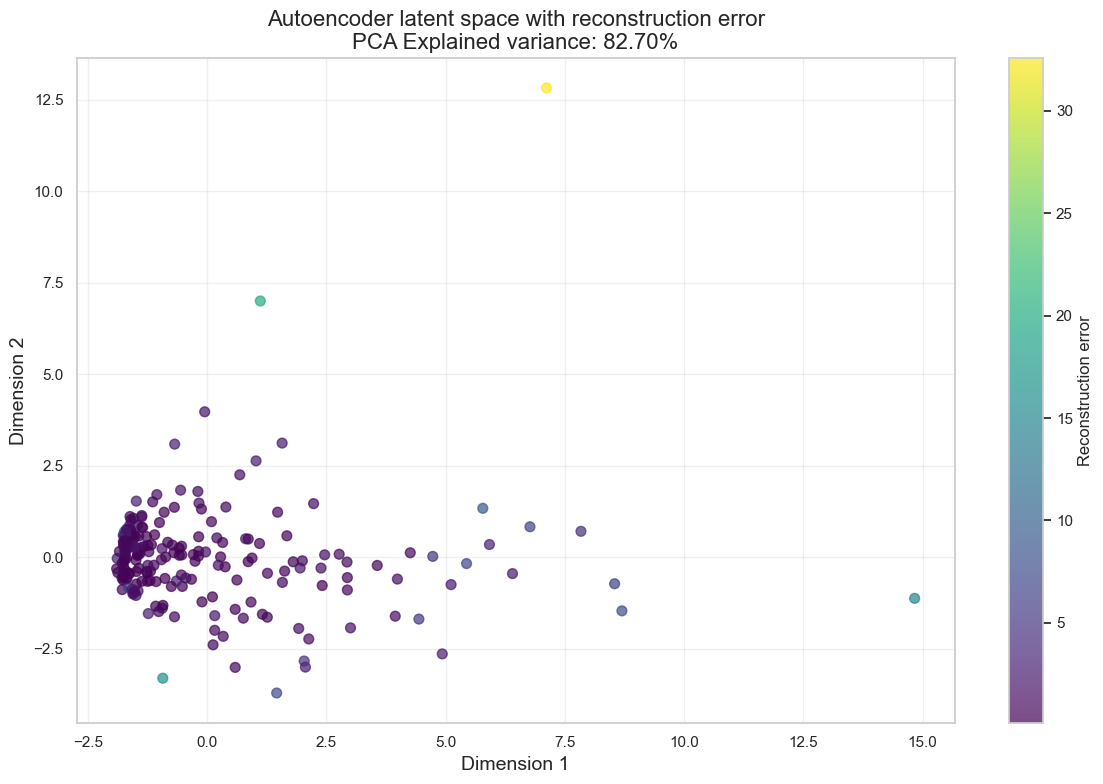


Performance comparison:
      Model  Precision   Recall  F1 Score
Autoencoder      0.696 0.731092  0.713115

Memento: Baseline model performance:
Precision: 0.6031
Recall: 0.9832
F1 Score: 0.7476


In [37]:
# Evaluate the autoencoder model
def evaluate_autoencoder(y_true, y_pred, reconstruction_errors, threshold):
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print("\nAutoencoder performance:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Anomaly'],
                yticklabels=['Normal', 'Anomaly'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - Autoencoder')
    plt.tight_layout()
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, reconstruction_errors)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve - Autoencoder')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    # Visualize reconstruction error distribution
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(reconstruction_errors)),
                reconstruction_errors,
                c=['blue' if label == 0 else 'red' for label in y_true],
                alpha=0.5)
    plt.axhline(y=threshold, color='green', linestyle='--', label=f'Threshold: {threshold:.4f}')
    plt.title('Reconstruction error for test set')
    plt.xlabel('Sample index')
    plt.ylabel('Reconstruction error')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return precision, recall, f1, roc_auc


# Visualize in PCA space
def visualize_autoencoder_pca(X, y_true, y_pred, reconstruction_errors, threshold):
    # Apply PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Create a DataFrame for plotting
    pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    pca_df['Actual'] = y_true
    pca_df['Predicted'] = y_pred
    pca_df['Error'] = reconstruction_errors

    # Create classification categories
    pca_df['Category'] = 'Unknown'
    pca_df.loc[(y_true == 0) & (y_pred == 0), 'Category'] = 'True Negative'
    pca_df.loc[(y_true == 0) & (y_pred == 1), 'Category'] = 'False Positive'
    pca_df.loc[(y_true == 1) & (y_pred == 0), 'Category'] = 'False Negative'
    pca_df.loc[(y_true == 1) & (y_pred == 1), 'Category'] = 'True Positive'

    # Calculate explained variance
    explained_variance = pca.explained_variance_ratio_
    total_variance = sum(explained_variance)

    # Plot
    plt.figure(figsize=(12, 8))

    # Define colors and sizes
    colors = {'True Negative': 'gray', 'True Positive': 'black',
              'False Positive': 'red', 'False Negative': 'blue'}
    alphas = {'True Negative': 0.3, 'True Positive': 0.5,
              'False Positive': 0.8, 'False Negative': 0.8}
    sizes = {'True Negative': 30, 'True Positive': 40,
             'False Positive': 80, 'False Negative': 80}

    # Plot each category
    for category, group in pca_df.groupby('Category'):
        plt.scatter(group['PC1'], group['PC2'],
                    color=colors[category],
                    alpha=alphas[category],
                    s=sizes[category],
                    label=f"{category} ({len(group)})")

    plt.title(f'PCA Projection - Autoencoder\nExplained variance: {total_variance:.2%}', fontsize=16)
    plt.xlabel(f'PC1 ({explained_variance[0]:.2%})', fontsize=14)
    plt.ylabel(f'PC2 ({explained_variance[1]:.2%})', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

    # Plot with reconstruction error as color intensity
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'],
                c=pca_df['Error'],
                cmap='viridis',
                alpha=0.7,
                s=50)
    plt.colorbar(scatter, label='Reconstruction error')
    plt.title(f'PCA Projection with eeconstruction error\nExplained variance: {total_variance:.2%}', fontsize=16)
    plt.xlabel(f'PC1 ({explained_variance[0]:.2%})', fontsize=14)
    plt.ylabel(f'PC2 ({explained_variance[1]:.2%})', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Visualize in latent space
    model.eval()
    with torch.no_grad():
        latent_vectors = model.encode(X_test_tensor).cpu().numpy()

    # Apply PCA if the latent space has more than 2 dimensions
    if latent_vectors.shape[1] > 2:
        pca_latent = PCA(n_components=2)
        latent_2d = pca_latent.fit_transform(latent_vectors)
        explained_var = pca_latent.explained_variance_ratio_
        total_var = sum(explained_var)
        title_suffix = f"\nPCA Explained variance: {total_var:.2%}"
    else:
        latent_2d = latent_vectors
        title_suffix = ""

    # Create DataFrame for latent space visualization
    latent_df = pd.DataFrame(latent_2d, columns=['Dim1', 'Dim2'])
    latent_df['Actual'] = y_test
    latent_df['Predicted'] = y_pred
    latent_df['Error'] = reconstruction_errors

    # Create classification categories
    latent_df['Category'] = 'Unknown'
    latent_df.loc[(y_true == 0) & (y_pred == 0), 'Category'] = 'True Negative'
    latent_df.loc[(y_true == 0) & (y_pred == 1), 'Category'] = 'False Positive'
    latent_df.loc[(y_true == 1) & (y_pred == 0), 'Category'] = 'False Negative'
    latent_df.loc[(y_true == 1) & (y_pred == 1), 'Category'] = 'True Positive'

    # Plot in latent space by category
    plt.figure(figsize=(12, 8))
    for category, group in latent_df.groupby('Category'):
        plt.scatter(group['Dim1'], group['Dim2'],
                    color=colors[category],
                    alpha=alphas[category],
                    s=sizes[category],
                    label=f"{category} ({len(group)})")

    plt.title(f'Autoencoder latent space projection{title_suffix}', fontsize=16)
    plt.xlabel('Dimension 1', fontsize=14)
    plt.ylabel('Dimension 2', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

    # Plot in latent space with reconstruction error as color
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(latent_df['Dim1'], latent_df['Dim2'],
                c=latent_df['Error'],
                cmap='viridis',
                alpha=0.7,
                s=50)
    plt.colorbar(scatter, label='Reconstruction error')
    plt.title(f'Autoencoder latent space with reconstruction error{title_suffix}', fontsize=16)
    plt.xlabel('Dimension 1', fontsize=14)
    plt.ylabel('Dimension 2', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# Evaluate autoencoder performance
ae_metrics = evaluate_autoencoder(y_test, y_pred, test_errors, threshold)

# Visualize the autoencoder results
visualize_autoencoder_pca(X_test_scaled, y_test, y_pred, test_errors, threshold)

# Compare with previous models
# Add autoencoder results to the comparison DataFrame
results_df = pd.DataFrame([
    ("Autoencoder", ae_metrics[0], ae_metrics[1], ae_metrics[2])
], columns=['Model', 'Precision', 'Recall', 'F1 Score'])

# Print the results table
print("\nPerformance comparison:")
print(results_df.sort_values('F1 Score', ascending=False).to_string(index=False))

print("\nMemento: Baseline model performance:")
print(f"Precision: {MVG_precision:.4f}")
print(f"Recall: {MVG_recall:.4f}")
print(f"F1 Score: {MVG_f1:.4f}")


### 📈 Feature importance

We estimate feature importance by **zeroing out** each feature (one at a time) and measuring how much the **reconstruction error increases**.

This tells us which variables are most critical to the model's understanding of “normality.”  

> Useful for interpretability — especially in financial or operational risk settings.

<br>

/var/folders/n7/c2d74g5n7vj2bbwp22w33n2h0000gn/T/ipykernel_56478/4164719277.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), palette='viridis')


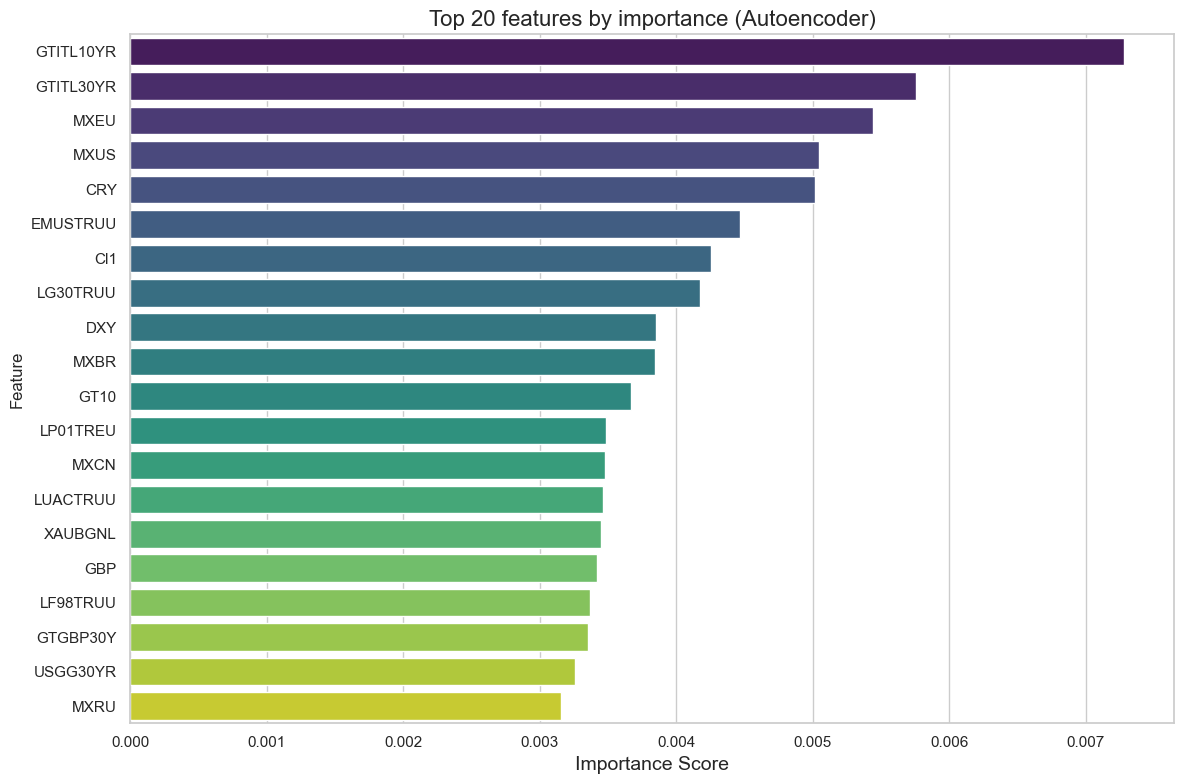


Top 10 most important features:
      Feature  Importance
31  GTITL10YR    0.007281
33  GTITL30YR    0.005757
16       MXEU    0.005440
20       MXUS    0.005048
1         CRY    0.005019
4    EMUSTRUU    0.004465
2         Cl1    0.004254
9    LG30TRUU    0.004174
3         DXY    0.003849
14       MXBR    0.003846


In [ ]:
# Feature importance analysis using the autoencoder
def analyze_feature_importance(model, X_tensor, feature_names):
    """
    Analyze feature importance by measuring the impact of each feature on reconstruction error
    """
    model.eval()
    n_features = X_tensor.shape[1]
    importance_scores = []

    # Original reconstruction error
    with torch.no_grad():
        original_output = model(X_tensor)
        original_error = ((original_output - X_tensor) ** 2).mean(dim=0).cpu().numpy()

    # Measure impact of perturbing each feature
    for i in range(n_features):
        # Create a copy with the i-th feature perturbed
        perturbed_input = X_tensor.clone()
        perturbed_input[:, i] = torch.zeros_like(perturbed_input[:, i])

        with torch.no_grad():
            perturbed_output = model(perturbed_input)
            perturbed_error = ((perturbed_output - X_tensor) ** 2).mean(dim=0).cpu().numpy()

        # Importance is the increase in error when the feature is perturbed
        feature_importance = np.mean(perturbed_error - original_error)
        importance_scores.append(feature_importance)

    # Create DataFrame with feature importance
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance_scores
    })

    # Sort by importance
    importance_df = importance_df.sort_values('Importance', ascending=False)

    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20), palette='viridis')
    plt.title('Top 20 features by importance (Autoencoder)', fontsize=16)
    plt.xlabel('Importance Score', fontsize=14)
    plt.tight_layout()
    plt.show()

    return importance_df

# Analyze feature importance
if 'stationary_df' in locals() and hasattr(stationary_df, 'columns'):
    feature_names = stationary_df.columns
    feature_importance = analyze_feature_importance(model, X_test_tensor, feature_names)
    print("\nTop 10 most important features:")
    print(feature_importance.head(10))

#you could also use shap to explain the model's predictions
#shap.summary_plot(shap_values, X_test_scaled)
#shap.dependence_plot("feature_name", shap_values, X_test_scaled)


<br>

This notebook you've just completed provides a good foundation for comparing anomaly detection techniques.

Now it's your turn to go further.

There are a lot of things you can do. Don't do them all, I'll just give you some ideas... Do reasonable things.

<br>

---

## HINTs

### 1. Improve the existing models
- You can fine-tune them using hyperparameter optimization libraries such as **[Optuna](https://www.google.com/url?q=https%3A%2F%2Foptuna.readthedocs.io%2Fen%2Fstable%2Findex.html%23)**, or try different scalers, data splits, loss functions, etc.  
- Once optimized, compare them on the same test set using the existing evaluation pipeline. It is also interesting to use synthetic data to compare different models.
- Also, explore **explainability**: SHAP, LIME, or [Gradient-based methods](https://pytorch.org/tutorials/beginner/introyt/captumyt.html) for neural models, but you already know.

---

### 🧪 2. Explore alternative models

Here are a few suggestions, of varying difficulty:

#### 📌 Variational Autoencoder (VAE)
- Adds a **Gaussian prior** to the latent space.
- Uses a loss function with two terms: reconstruction + **KL divergence**.
- Encourages **smoother generalization** and **better anomaly scoring**.
- Can also be used to **generate synthetic samples** of normal data.
- See:
  - [An Introduction to Variational Autoencoders](https://arxiv.org/abs/1906.02691).
  - [What is a variational autoencoder?](https://www.ibm.com/think/topics/variational-autoencoder).
  - [Deep Learning - Autoencoders](https://www.deeplearningbook.org/contents/autoencoders.html).

#### 📌 PCA and Linear Autoencoders
- PCA is equivalent to a **linear autoencoder** with no activation function.
- The reconstruction error can be used as anomaly score.
- Consider extensions, e.g., **[Kernel PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA)**, or **[Sparse PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.SparsePCA.html#sklearn.decomposition.SparsePCA)**.

#### 📌 [Isolation Mondrian Forest](https://paperswithcode.com/paper/isolation-mondrian-forest-for-batch-and)
- An enhancement of Isolation Forest with better robustness and generalization.

#### 📌 Gradient Boosted Trees (e.g., XGBoost)
- Try with imbalanced settings and anomaly-aware loss functions.

#### 📌 COPOD (Copula-Based Outlier Detection)
- A **density-based** method that models multivariate dependencies via [Copulas](https://en.wikipedia.org/wiki/Copula_(statistics)) - see also [A Practical Introduction to Copula](https://hudson-and-thames-arbitragelab.readthedocs-hosted.com/en/latest/copula_approach/copula_brief_intro.html).  
- More flexible than MVG and even Local Outlier Factor.
- For a good Python library, see [COPOD: Copula-Based Outlier Detection](https://arxiv.org/abs/2009.09463) and for the library I suggest [PyOD](https://pyod.readthedocs.io/en/latest/pyod.models.html#pyod.models.copod.COPOD)

#### 📌 [LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory) Autoencoder
- Useful for time series: captures temporal dependencies.
- Requires reshaping the data into sequences.
- See for example [A Gentle Introduction to LSTM Autoencoders](https://machinelearningmastery.com/lstm-autoencoders/),

#### 📌 [GAN](https://en.wikipedia.org/wiki/Generative_adversarial_network) for Anomaly Detection
- Use the **discriminator** to detect whether a point is "realistic".
- Similar principle to an autoencoder, but adversarial.
- Hard.
- See [A Survey on GANs for Anomaly Detection](https://arxiv.org/pdf/1906.11632).


>In general, **the library [PyOD](https://pyod.readthedocs.io/en/latest/)** includes a great variety of Anomaly Detection models, and the implementation in PyOD is efficient and well tested. It follows scikit-learn conventions (fit, predict, etc.). Many of the models mentioned, and many more, can be found there.So, enjoy...

---

### 🧭 3. Add financial domain knowledge

Machine Learning models can be greatly improved by embedding financial structure, i.e. business/financial knowledge:

- **Feature selection** by asset class, instrument type, or region.
- **Feature engineering** via statistical aggregates or dimensionality reduction (e.g. PCA per cluster of correlated assets).
- **Anomaly interpretation** based on macro/market context (e.g. clustering anomalies by cause).

---

### 🎯 4. Ensemble methods & uncertainty estimation

I know I'm repetitive. But. Another powerful direction is to build **an ensemble of models** (or model averaging). For instance:

- Combine **different anomaly detectors** (e.g. Autoencoder + LOF + Isolation Forest).
- Or use an ensemble of **Autoencoders** with different initializations (they provide different results). You can:
  - Average their anomaly scores
  - Or use their **disagreement (variance)** as a **proxy for predictive uncertainty**: models that disagree on a sample may be revealing an ambiguous or borderline case – which could be flagged for deeper analysis.

The ensemble approach helps mitigate overfitting and improves **robustness to noise** and model misspecification.

---

### 🔁 5. Semi-Supervised Anomaly Detection and Active Learning

When labels are scarce or expensive to obtain — a common situation in finance — it can be useful to explore **semi-supervised learning**, where:

- You start from a small set of labeled anomalies (or normal points).
- And propagate this information to the unlabeled data using **label propagation** or **graph-based methods**.

Another promising avenue is **[Active Learning](https://en.wikipedia.org/wiki/Active_learning_(machine_learning))**, where the model can **query** for the label of the most uncertain points — typically the ones near the decision boundary or where models disagree. So if the model is undecided, a Sapiens (human in the loop) decides.

This is especially relevant when a domain expert (e.g., a risk officer - you can assume you are a team of risk managers) can confirm whether specific events are truly anomalous. And the model learns.

📚 Some reading:

- [Chapelle, Scholkopf, Zien (2006)](https://www.oxfordreference.com/view/10.1093/acref/9780199676844.001.0001/acref-9780199676844): *Semi-Supervised Learning* — the classic reference on the topic  
- [Budd et al. (2021)](https://arxiv.org/abs/1906.10685): *A Survey on Active Learning and Human-in-the-Loop for Anomaly Detection* — a modern overview

These approaches allow us to **embed expert knowledge into the model loop** without requiring full supervision — a realistic compromise in most financial contexts.
